## COMP 484 Lab 5
Srishan Shakya

Roll No. 46

CE


# Classification - Detecting Poor Answers

## Sketching our roadmap
- Trying to build a mechanism that shows how good an answer is as it is being typed.
- Achieving 100 percent accuracy is near impossible as real data is very noisy and not all humans share the same opinion.
- Adjust our inital goals on the way
- Start with nearest neighbour approach. Find out it is not very good.
- Switch over to logistic regression, and arrive at a solution with good enough prediction quality on smaller part of the answers.
- Finally, look at how to extract the winner to deploy it on the target system.

## Learning to classify classy answers

In classification, we want to find corresponding **classes**, sometimes also called **labels**, for given data instances. For that we need to:
    - Tune the data instances
    - Tune the classifier model

## Fetching the data

In [1]:
import sys
import os
import re
try:
    import ujson as json  # UltraJSON if available
except:
    import json
from dateutil import parser as dateparser

from operator import itemgetter
from xml.etree import cElementTree as etree
from collections import defaultdict

In [2]:
DATA_DIR = "D:/"
CHART_DIR = "D:/"

filtered = os.path.join(DATA_DIR, "filtered.tsv")
filtered_meta = os.path.join(DATA_DIR, "filtered-meta.json")

chosen = os.path.join(DATA_DIR, "chosen.tsv")
chosen_meta = os.path.join(DATA_DIR, "chosen-meta.json")

In [3]:
filename = os.path.join(DATA_DIR, "Posts.xml")
print("Reading from xml %s" % filename)
filename_filtered = os.path.join(DATA_DIR, "filtered.tsv")
print("Filtered: %s" % filename_filtered)
filename_filtered_meta = os.path.join(DATA_DIR, "filtered-meta.json")
print("Meta: %s" % filename_filtered_meta)

q_creation = {}  # creation datetimes of questions
q_accepted = {}  # id of accepted answer

# question -> [(answer Id, IsAccepted, TimeToAnswer, Score), ...]
meta = defaultdict(list)

# regegx to find code snippets
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
img_match = re.compile('<img(.*?)/>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)

Reading from xml D:/Posts.xml
Filtered: D:/filtered.tsv
Meta: D:/filtered-meta.json


In [4]:
def filter_html(s):
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    num_images = len(img_match.findall(s))

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub("", code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links)

    link_count -= link_count_in_code

    link_free_s = re.sub(
        " +", " ", tag_match.sub('', code_free_s)).replace("\n", "")

    for link in links:
        if link.lower().startswith("http://"):
            link_free_s = link_free_s.replace(link, '')

    num_text_tokens = link_free_s.count(" ")

    return link_free_s, num_text_tokens, num_code_lines, link_count, num_images

years = defaultdict(int)
num_questions = 0
num_answers = 0

In [5]:
def parsexml(filename):
    global num_questions, num_answers

    counter = 0

    it = map(itemgetter(1),
             iter(etree.iterparse(filename, events=('start',))))

    root = next(it)  # get posts element

    for elem in it:
        if counter % 100000 == 0:
            print("Processed %i <row/> elements" % counter)

        counter += 1

        if elem.tag == 'row':
            creation_date = dateparser.parse(elem.get('CreationDate'))

            if creation_date.year == 2018 or creation_date.year == 2019: # Considering only data from year 2018 and 2019
                Id = int(elem.get('Id'))
                PostTypeId = int(elem.get('PostTypeId'))
                Score = int(elem.get('Score'))

                if PostTypeId == 1:
                    num_questions += 1
                    years[creation_date.year] += 1

                    ParentId = -1
                    TimeToAnswer = 0
                    q_creation[Id] = creation_date
                    accepted = elem.get('AcceptedAnswerId')
                    if accepted:
                        q_accepted[Id] = int(accepted)
                    IsAccepted = 0

                elif PostTypeId == 2:
                    num_answers += 1

                    ParentId = int(elem.get('ParentId'))
                    if not ParentId in q_creation:
                        # question was too far in the past
                        continue

                    TimeToAnswer = (creation_date - q_creation[ParentId]).seconds

                    if ParentId in q_accepted:
                        IsAccepted = int(q_accepted[ParentId] == Id)
                    else:
                        IsAccepted = 0

                    meta[ParentId].append((Id, IsAccepted, TimeToAnswer, Score))

                else:
                    continue

                Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = filter_html(elem.get('Body'))

                values = (Id, ParentId,
                          IsAccepted,
                          TimeToAnswer, Score,
                          Text.encode("utf-8"),
                          NumTextTokens, NumCodeLines, LinkCount, NumImages)

                yield values

            root.clear()  # preserve memory

In [6]:
with open(filename_filtered, "w") as f:
    for values in parsexml(filename):
        line = "\t".join(map(str, values))
        f.write(line + "\n")

with open(filename_filtered_meta, "w") as f:
    json.dump(meta, f)

print("years:", years)
print("#qestions: %i" % num_questions)
print("#answers: %i" % num_answers)

Processed 0 <row/> elements
Processed 100000 <row/> elements
Processed 200000 <row/> elements
Processed 300000 <row/> elements
Processed 400000 <row/> elements
Processed 500000 <row/> elements
Processed 600000 <row/> elements
Processed 700000 <row/> elements
Processed 800000 <row/> elements
Processed 900000 <row/> elements
Processed 1000000 <row/> elements
Processed 1100000 <row/> elements
Processed 1200000 <row/> elements
Processed 1300000 <row/> elements
Processed 1400000 <row/> elements
Processed 1500000 <row/> elements
Processed 1600000 <row/> elements
Processed 1700000 <row/> elements
Processed 1800000 <row/> elements
Processed 1900000 <row/> elements
Processed 2000000 <row/> elements
Processed 2100000 <row/> elements
Processed 2200000 <row/> elements
Processed 2300000 <row/> elements
Processed 2400000 <row/> elements
Processed 2500000 <row/> elements
Processed 2600000 <row/> elements
Processed 2700000 <row/> elements
Processed 2800000 <row/> elements
Processed 2900000 <row/> elem

Processed 23800000 <row/> elements
Processed 23900000 <row/> elements
Processed 24000000 <row/> elements
Processed 24100000 <row/> elements
Processed 24200000 <row/> elements
Processed 24300000 <row/> elements
Processed 24400000 <row/> elements
Processed 24500000 <row/> elements
Processed 24600000 <row/> elements
Processed 24700000 <row/> elements
Processed 24800000 <row/> elements
Processed 24900000 <row/> elements
Processed 25000000 <row/> elements
Processed 25100000 <row/> elements
Processed 25200000 <row/> elements
Processed 25300000 <row/> elements
Processed 25400000 <row/> elements
Processed 25500000 <row/> elements
Processed 25600000 <row/> elements
Processed 25700000 <row/> elements
Processed 25800000 <row/> elements
Processed 25900000 <row/> elements
Processed 26000000 <row/> elements
Processed 26100000 <row/> elements
Processed 26200000 <row/> elements
Processed 26300000 <row/> elements
Processed 26400000 <row/> elements
Processed 26500000 <row/> elements
Processed 26600000 <

In [7]:
# chose_instances.py
import os
try:
    import ujson as json  # UltraJSON if available
except:
    import json
import sys
from collections import defaultdict

try:
    import enchant
    speller = enchant.Dict("en_US")

except:
    print("""\
Enchant is not installed, which is not a problem since spell correction features
will not be used in the chapter.
""")

    class EnchantMock:

        def __init__(self):
            pass

        def check(self, word):
            return True
    speller = EnchantMock()

filtered_meta = json.load(open(filtered_meta, "r"))


def misspelled_fraction(p):
    tokens = p.split()
    if not tokens:
        return 0.0
    return 1 - float(sum(speller.check(t) for t in tokens)) / len(tokens)


def data(filename, col=None):
    for line in open(filename, "r"):
        data = line.strip().split("\t")

        # check format
        Id, ParentId, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = data

        if col:
            yield data[col]
        else:
            yield data

posts_to_keep = set()
found_questions = 0

num_qestion_sample = 1000

# keep the best and worst, but only if we have one with positive and one with negative score
# filter_method = "negative_positive"

# if true, only keep the lowest scoring answer per class in addition to the accepted one
# filter_method = "only_one_per_class "

# if not None, specifies the number of unaccepted per question
# filter_method = "sample_per_question"
filter_method = "negative_positive"  # warning: this does not retrieve many!
# filter_method = "only_one_per_class"
MaxAnswersPerQuestions = 10  # filter_method == "sample_per_question"

# filter_method = "all"

# equal share of questions that are unanswered and those that are answered
# filter_method = "half-half"

unaccepted_scores = {}

has_q_accepted_a = {}
num_q_with_accepted_a = 0
num_q_without_accepted_a = 0

for ParentId, posts in filtered_meta.items():
    assert ParentId != -1

    if len(posts) < 2:
        continue

    ParentId = int(ParentId)
    AllIds = set([ParentId])
    AcceptedId = None
    UnacceptedId = None
    UnacceptedIds = []
    UnacceptedScore = sys.maxsize

    NegativeScoreIds = []
    PositiveScoreIds = []

    if filter_method == "half-half":

        has_accepted_a = False
        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if IsAccepted:
                has_accepted_a = True
                break

        has_q_accepted_a[ParentId] = has_accepted_a

        if has_accepted_a:
            if num_q_with_accepted_a < num_qestion_sample / 2:
                num_q_with_accepted_a += 1
                posts_to_keep.add(ParentId)
        else:
            if num_q_without_accepted_a < num_qestion_sample / 2:
                num_q_without_accepted_a += 1
                posts_to_keep.add(ParentId)

        if num_q_without_accepted_a + num_q_with_accepted_a > num_qestion_sample:
            assert -1 not in posts_to_keep
            break

    else:

        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if filter_method == "all":
                AllIds.add(int(Id))

            elif filter_method == "only_one_per_class":
                if IsAccepted:
                    AcceptedId = Id
                elif Score < UnacceptedScore:
                    UnacceptedScore = Score
                    UnacceptedId = Id

            elif filter_method == "sample_per_question":
                if IsAccepted:
                    AcceptedId = Id
                else:
                    UnacceptedIds.append(Id)

            elif filter_method == "negative_positive":
                if Score < 0:
                    NegativeScoreIds.append((Score, Id))
                elif Score > 0:
                    PositiveScoreIds.append((Score, Id))

            else:
                raise ValueError(filter_method)

        added = False
        if filter_method == "all":
            posts_to_keep.update(AllIds)
            added = True
        elif filter_method == "only_one_per_class":
            if AcceptedId is not None and UnacceptedId is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.add(UnacceptedId)
                added = True

        elif filter_method == "sample_per_question":
            if AcceptedId is not None and UnacceptedIds is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.update(UnacceptedIds[:MaxAnswersPerQuestions])
                added = True

        elif filter_method == "negative_positive":
            if PositiveScoreIds and NegativeScoreIds:
                posts_to_keep.add(ParentId)

                posScore, posId = sorted(PositiveScoreIds)[-1]
                posts_to_keep.add(posId)

                negScore, negId = sorted(NegativeScoreIds)[0]
                posts_to_keep.add(negId)
                print("%i: %i/%i %i/%i" % (ParentId, posId,
                      posScore, negId, negScore))
                added = True

        if added:
            found_questions += 1

    if num_qestion_sample and found_questions >= num_qestion_sample:
        break

total = 0
kept = 0

already_written = set()
chosen_meta_dict = defaultdict(dict)

with open(chosen, "w") as f:
    for line in data(filtered):
        strId, ParentId, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = line
        Text = Text.strip()

        total += 1

        Id = int(strId)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            if kept % 100 == 0:
                print(kept)

            # setting meta info
            post = chosen_meta_dict[Id]
            post['ParentId'] = int(ParentId)
            post['IsAccepted'] = int(IsAccepted)
            post['TimeToAnswer'] = int(TimeToAnswer)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['MisSpelledFraction'] = misspelled_fraction(Text)
            post['NumImages'] = int(NumImages)
            post['idx'] = kept  # index into the file

            if int(ParentId) == -1:
                q = chosen_meta_dict[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

                if filter_method == "half-half":
                    q['HasAcceptedAnswer'] = has_q_accepted_a[Id]

            else:
                q = chosen_meta_dict[int(ParentId)]

                if int(IsAccepted) == 1:
                    assert 'HasAcceptedAnswer' not in q
                    q['HasAcceptedAnswer'] = True

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(chosen_meta, "w") as fm:
    json.dump(chosen_meta_dict, fm)

print("total=", total)
print("kept=", kept)

Enchant is not installed, which is not a problem since spell correction features
will not be used in the chapter.

48046448: 48046480/2 48046486/-1
48047305: 48047346/1 48047318/-1
48047497: 48048523/3 48058711/-1
48047657: 48047679/1 48047677/-2
48048081: 48048166/1 48048178/-1
48048455: 54520568/1 48048467/-1
48048591: 48048649/3 48048870/-1
48048935: 48049335/1 48049007/-1
48048950: 48049139/1 48049109/-1
48049776: 48050619/2 48049797/-1
48049757: 48050079/1 48049863/-1
48049837: 48050829/2 48049926/-2
48049815: 48050140/6 48049937/-1
48049965: 48050118/6 48050033/-1
48049128: 48050898/2 48050171/-1
48049781: 48050886/6 48051276/-1
48050434: 48050492/1 48050495/-1
48050508: 48051110/1 48051191/-1
48051208: 48051589/1 48051285/-1
48049405: 49542322/3 48051385/-1
48051699: 48052490/8 48051824/-1
48049938: 48054558/3 48056519/-1
48052171: 48052234/2 48052215/-3
48049242: 52891409/1 48052308/-1
48052461: 48052558/1 48052693/-1
48052657: 48052802/6 48052699/-1
48053127: 48064157/3 581636

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
total= 8072983
kept= 3000


## Creating our first classifier

In [8]:
from sklearn import neighbors

In [10]:
# Starting with kNN
knn = neighbors.KNeighborsClassifier(n_neighbors = 2)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')


In [12]:
knn.fit([[1],[2],[3],[4],[5],[6]], [0,0,0,1,1,1])
knn.predict([[1.5]])

array([0])

In [13]:
knn.predict([[37]])

array([1])

In [16]:
knn.predict([[3]])

array([0])

In [14]:
knn.predict_proba([[1.5]])

array([[1., 0.]])

In [18]:
knn.predict_proba([[37]])

array([[0., 1.]])

In [19]:
knn.predict_proba([[3.5]])

array([[0.5, 0.5]])

In [28]:
# utils.py
import os

try:
    import ujson as json  # UltraJSON if available
except:
    import json

from matplotlib import pylab
import numpy as np


def fetch_data(filename, col=None, line_count=-1, only_questions=False):
    count = 0

    for line in open(filename, "r"):
        count += 1
        if line_count > 0 and count > line_count:
            break

        data = Id, ParentId, IsQuestion, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, MisSpelledFraction = line.split(
            "\t")

        IsQuestion = int(IsQuestion)

        if only_questions and not IsQuestion:
            continue

        if col:
            if col < 6:
                val = int(data[col])
            else:
                val = data[col]

            yield val

        else:
            Id = int(Id)
            assert Id >= 0, line

            ParentId = int(ParentId)

            IsAccepted = int(IsAccepted)

            assert not IsQuestion == IsAccepted == 1, "%i %i --- %s" % (
                IsQuestion, IsAccepted, line)
            assert (ParentId == -1 and IsQuestion) or (
                ParentId >= 0 and not IsQuestion), "%i %i --- %s" % (ParentId, IsQuestion, line)

            TimeToAnswer = int(TimeToAnswer)
            Score = int(Score)
            NumTextTokens = int(NumTextTokens)
            NumCodeLines = int(NumCodeLines)
            LinkCount = int(LinkCount)
            MisSpelledFraction = float(MisSpelledFraction)
            yield Id, ParentId, IsQuestion, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, MisSpelledFraction


def fetch_posts(filename, with_index=True, line_count=-1):
    count = 0

    for line in open(filename, "r"):
        count += 1
        if line_count > 0 and count > line_count:
            break

        Id, Text = line.split("\t")
        Text = Text.strip()

        if with_index:

            yield int(Id), Text

        else:

            yield Text


def load_meta(filename):
    meta = json.load(open(filename, "r"))
    keys = list(meta.keys())

    # JSON only allows string keys, changing that to int
    for key in keys:
        meta[int(key)] = meta[key]
        del meta[key]

    # post Id to index in vectorized
    id_to_idx = {}
    # and back
    idx_to_id = {}

    for PostId, Info in meta.items():
        id_to_idx[PostId] = idx = Info['idx']
        idx_to_id[idx] = PostId

    return meta, id_to_idx, idx_to_id


def plot_roc(auc_score, name, fpr, tpr):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.plot([0, 1], [0, 1], 'k--')
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('False Positive Rate')
    pylab.ylabel('True Positive Rate')
    pylab.title('Receiver operating characteristic (AUC=%0.2f)\n%s' % (
        auc_score, name))
    pylab.legend(loc="lower right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.fill_between(tpr, fpr, alpha=0.5)
    pylab.plot(fpr, tpr, lw=1)
    pylab.savefig(
        os.path.join(CHART_DIR, "roc_" + name.replace(" ", "_") + ".png"))


def plot_pr(auc_score, name, precision, recall, label=None):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    pylab.fill_between(recall, precision, alpha=0.5)
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(CHART_DIR, "pr_" + filename + ".png"))


def show_most_informative_features(vectorizer, clf, n=20):
    c_f = sorted(zip(clf.coef_[0], vectorizer.get_feature_names()))
    top = list(zip(c_f[:n], c_f[:-(n + 1):-1]))
    for (c1, f1), (c2, f2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (c1, f1, c2, f2))


def plot_feat_importance(feature_names, clf, name):
    pylab.figure(num=None, figsize=(6, 5))
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    pylab.bar(xpos, coef, width=1)

    pylab.title('Feature importance for %s' % (name))
    ax = pylab.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(
        CHART_DIR, "feat_imp_%s.png" % filename), bbox_inches="tight")


def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    pylab.figure(num=None, figsize=(8, 6))
    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    pylab.figure(figsize=(5 * num_cols, 4 * num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            pylab.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            pylab.title(name)
            pylab.xlabel('Value')
            pylab.ylabel('Fraction')
            # the histogram of the data
            max_val = np.max(x)
            if max_val <= 1.0:
                bins = 50
            elif max_val > 50:
                bins = 50
            else:
                bins = max_val
            n, bins, patches = pylab.hist(x, bins=int(bins), density=1, alpha=0.75)

            pylab.grid(True)

    if not filename:
        filename = "feat_hist_%s.png" % name.replace(" ", "_")

    pylab.savefig(os.path.join(CHART_DIR, filename), bbox_inches="tight")


def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Data set size')
    pylab.ylabel('Error')
    pylab.title("Bias-Variance for '%s'" % name)
    pylab.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    pylab.legend(["test error", "train error"], loc="upper right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.savefig(
        os.path.join(CHART_DIR, "bv_" + name.replace(" ", "_") + ".png"), bbox_inches="tight")


def plot_k_complexity(ks, train_errors, test_errors):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('k')
    pylab.ylabel('Error')
    pylab.title('Errors for for different values of $k$')
    pylab.plot(
        ks, test_errors, "--", ks, train_errors, "-", lw=1)
    pylab.legend(["test error", "train error"], loc="upper right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.savefig(
        os.path.join(CHART_DIR, "kcomplexity.png"), bbox_inches="tight")

Clone #0
              precision    recall  f1-score   support

not accepted       0.50      0.67      0.57         3
    accepted       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.60      1.00      0.75         3
    accepted       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.67      0.50      0.57         4
    accepted       0.33      0.50      0.40         2

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.56      0.50      0.51    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

not accepted       0.60      1.00      0.75         3
    accepted       1.00      0.50      0.67         4

    accuracy                           0.71         7
   macro avg       0.80      0.75      0.71         7
weighted avg       0.83      0.71      0.70         7

Clone #7
              precision    recall  f1-score   support

not accepted       0.50      0.67      0.57         3
    accepted       0.67      0.50      0.57         4

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7

Clone #8
              precision    recall  f1-score   support

not accepted       1.00      0.80      0.89         5
    accepted       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



Clone #3
              precision    recall  f1-score   support

not accepted       0.33      0.50      0.40         2
    accepted       0.80      0.67      0.73         6

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8

Clone #4
              precision    recall  f1-score   support

not accepted       0.67      0.33      0.44         6
    accepted       0.20      0.50      0.29         2

    accuracy                           0.38         8
   macro avg       0.43      0.42      0.37         8
weighted avg       0.55      0.38      0.40         8

Clone #5
              precision    recall  f1-score   support

not accepted       0.80      1.00      0.89         4
    accepted       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87    

              precision    recall  f1-score   support

not accepted       0.60      0.60      0.60         5
    accepted       0.33      0.33      0.33         3

    accuracy                           0.50         8
   macro avg       0.47      0.47      0.47         8
weighted avg       0.50      0.50      0.50         8

Medium clone is #8
('5NN', 0.5555555555555556, 0.1469861839480328, 0.6155555555555555, 0.15937377450509227, 0.6252380952380953, 0.20576760604418018, 0.06993627548217773)
P=1.00 R=0.20 thresh=0.60
Clone #0
              precision    recall  f1-score   support

not accepted       0.40      0.40      0.40         5
    accepted       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10

Clone #1
              precision    recall  f1-score   support

not accepted       0.83      0.71      0.77         7
    accepted       0.50

              precision    recall  f1-score   support

not accepted       0.50      0.20      0.29         5
    accepted       0.50      0.80      0.62         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10

Clone #6
              precision    recall  f1-score   support

not accepted       0.50      0.67      0.57         6
    accepted       0.00      0.00      0.00         4

    accuracy                           0.40        10
   macro avg       0.25      0.33      0.29        10
weighted avg       0.30      0.40      0.34        10

Clone #7
              precision    recall  f1-score   support

not accepted       0.50      0.75      0.60         4
    accepted       0.75      0.50      0.60         6

    accuracy                           0.60        10
   macro avg       0.62      0.62      0.60        10
weighted avg       0.65      0.60      0.60        10

C

Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.50      0.55         6
    accepted       0.57      0.67      0.62         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      0.57      0.53         7
    accepted       0.25      0.20      0.22         5

    accuracy                           0.42        12
   macro avg       0.38      0.39      0.38        12
weighted avg       0.40      0.42      0.40        12

Clone #2
              precision    recall  f1-score   support

not accepted       0.20      0.20      0.20         5
    accepted       0.33      0.33      0.33         6

    accuracy                           0.27        11
   macro avg       0.27      0.27      0.27        11
weighted avg       0.27      0.27      0.27    

              precision    recall  f1-score   support

not accepted       0.83      0.71      0.77         7
    accepted       0.71      0.83      0.77         6

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13

Clone #6
              precision    recall  f1-score   support

not accepted       0.45      0.83      0.59         6
    accepted       0.50      0.14      0.22         7

    accuracy                           0.46        13
   macro avg       0.48      0.49      0.41        13
weighted avg       0.48      0.46      0.39        13

Clone #7
              precision    recall  f1-score   support

not accepted       0.20      0.20      0.20         5
    accepted       0.50      0.50      0.50         8

    accuracy                           0.38        13
   macro avg       0.35      0.35      0.35        13
weighted avg       0.38      0.38      0.38        13

C

              precision    recall  f1-score   support

not accepted       0.71      0.62      0.67         8
    accepted       0.62      0.71      0.67         7

    accuracy                           0.67        15
   macro avg       0.67      0.67      0.67        15
weighted avg       0.67      0.67      0.67        15

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      0.57      0.53         7
    accepted       0.57      0.50      0.53         8

    accuracy                           0.53        15
   macro avg       0.54      0.54      0.53        15
weighted avg       0.54      0.53      0.53        15

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.78      0.70         9
    accepted       0.50      0.33      0.40         6

    accuracy                           0.60        15
   macro avg       0.57      0.56      0.55        15
weighted avg       0.58      0.60      0.58        15

C

              precision    recall  f1-score   support

not accepted       0.56      0.56      0.56         9
    accepted       0.43      0.43      0.43         7

    accuracy                           0.50        16
   macro avg       0.49      0.49      0.49        16
weighted avg       0.50      0.50      0.50        16

Medium clone is #0
('5NN', 0.575, 0.1, 0.6116294642857143, 0.13387188801303138, 0.6689499507877484, 0.11047941232357947, 0.10355019569396973)
P=1.00 R=0.00 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.56      0.59         9
    accepted       0.56      0.62      0.59         8

    accuracy                           0.59        17
   macro avg       0.59      0.59      0.59        17
weighted avg       0.59      0.59      0.59        17

Clone #1
              precision    recall  f1-score   support

not accepted       0.38      0.38      0.38         8
    accepted       0.44      0.44      0.44        

              precision    recall  f1-score   support

not accepted       0.44      0.44      0.44         9
    accepted       0.38      0.38      0.38         8

    accuracy                           0.41        17
   macro avg       0.41      0.41      0.41        17
weighted avg       0.41      0.41      0.41        17

Medium clone is #0
('5NN', 0.5330065359477125, 0.16198374290635856, 0.5612263508096842, 0.15704822902789906, 0.6075826176915988, 0.1362843977531754, 0.09044790267944336)
P=1.00 R=0.00 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.60      0.60        10
    accepted       0.50      0.50      0.50         8

    accuracy                           0.56        18
   macro avg       0.55      0.55      0.55        18
weighted avg       0.56      0.56      0.56        18

Clone #1
              precision    recall  f1-score   support

not accepted       0.40      0.44      0.42         9
    accepted       0.38

              precision    recall  f1-score   support

not accepted       0.44      0.40      0.42        10
    accepted       0.40      0.44      0.42         9

    accuracy                           0.42        19
   macro avg       0.42      0.42      0.42        19
weighted avg       0.42      0.42      0.42        19

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.78      0.61         9
    accepted       0.60      0.30      0.40        10

    accuracy                           0.53        19
   macro avg       0.55      0.54      0.50        19
weighted avg       0.55      0.53      0.50        19

Medium clone is #9
('5NN', 0.5578947368421052, 0.12356657339645633, 0.5886174242424242, 0.13299823272982508, 0.6253654097736916, 0.13499824487717288, 0.09870362281799316)
P=1.00 R=0.30 thresh=0.60
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.50      0.57        12
    accepted       0.4

              precision    recall  f1-score   support

not accepted       0.58      0.58      0.58        12
    accepted       0.44      0.44      0.44         9

    accuracy                           0.52        21
   macro avg       0.51      0.51      0.51        21
weighted avg       0.52      0.52      0.52        21

Clone #8
              precision    recall  f1-score   support

not accepted       0.50      0.67      0.57         9
    accepted       0.62      0.45      0.53        11

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.58      0.56        12
    accepted       0.29      0.25      0.27         8

    accuracy                           0.45        20
   macro avg       0.41      0.42      0.41        20
weighted avg       0.44      0.45      0.44        20

M

              precision    recall  f1-score   support

not accepted       0.54      0.64      0.58        11
    accepted       0.60      0.50      0.55        12

    accuracy                           0.57        23
   macro avg       0.57      0.57      0.56        23
weighted avg       0.57      0.57      0.56        23

Clone #4
              precision    recall  f1-score   support

not accepted       0.64      0.69      0.67        13
    accepted       0.50      0.44      0.47         9

    accuracy                           0.59        22
   macro avg       0.57      0.57      0.57        22
weighted avg       0.58      0.59      0.59        22

Clone #5
              precision    recall  f1-score   support

not accepted       0.45      0.56      0.50         9
    accepted       0.64      0.54      0.58        13

    accuracy                           0.55        22
   macro avg       0.55      0.55      0.54        22
weighted avg       0.56      0.55      0.55        22

C

              precision    recall  f1-score   support

not accepted       0.46      0.60      0.52        10
    accepted       0.60      0.46      0.52        13

    accuracy                           0.52        23
   macro avg       0.53      0.53      0.52        23
weighted avg       0.54      0.52      0.52        23

Medium clone is #1
('5NN', 0.5626811594202898, 0.08872817794261637, 0.5832153263403264, 0.10719028555253025, 0.6225573731751369, 0.1332239348641874, 0.10614228248596191)
P=1.00 R=0.08 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.64      0.54      0.58        13
    accepted       0.54      0.64      0.58        11

    accuracy                           0.58        24
   macro avg       0.59      0.59      0.58        24
weighted avg       0.59      0.58      0.58        24

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.67      0.59        12
    accepted       0.56

              precision    recall  f1-score   support

not accepted       0.50      0.69      0.58        13
    accepted       0.50      0.31      0.38        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.48        26
weighted avg       0.50      0.50      0.48        26

Clone #2
              precision    recall  f1-score   support

not accepted       0.75      0.64      0.69        14
    accepted       0.62      0.73      0.67        11

    accuracy                           0.68        25
   macro avg       0.68      0.69      0.68        25
weighted avg       0.69      0.68      0.68        25

Clone #3
              precision    recall  f1-score   support

not accepted       0.39      0.78      0.52         9
    accepted       0.71      0.31      0.43        16

    accuracy                           0.48        25
   macro avg       0.55      0.55      0.48        25
weighted avg       0.60      0.48      0.46        25

C

Clone #1
              precision    recall  f1-score   support

not accepted       0.47      0.75      0.58        12
    accepted       0.62      0.33      0.43        15

    accuracy                           0.52        27
   macro avg       0.55      0.54      0.51        27
weighted avg       0.56      0.52      0.50        27

Clone #2
              precision    recall  f1-score   support

not accepted       0.73      0.73      0.73        15
    accepted       0.67      0.67      0.67        12

    accuracy                           0.70        27
   macro avg       0.70      0.70      0.70        27
weighted avg       0.70      0.70      0.70        27

Clone #3
              precision    recall  f1-score   support

not accepted       0.45      0.69      0.55        13
    accepted       0.43      0.21      0.29        14

    accuracy                           0.44        27
   macro avg       0.44      0.45      0.42        27
weighted avg       0.44      0.44      0.41    

              precision    recall  f1-score   support

not accepted       0.40      0.33      0.36        12
    accepted       0.56      0.62      0.59        16

    accuracy                           0.50        28
   macro avg       0.48      0.48      0.48        28
weighted avg       0.49      0.50      0.49        28

Clone #5
              precision    recall  f1-score   support

not accepted       0.47      0.47      0.47        15
    accepted       0.38      0.38      0.38        13

    accuracy                           0.43        28
   macro avg       0.43      0.43      0.43        28
weighted avg       0.43      0.43      0.43        28

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.85      0.69        13
    accepted       0.75      0.43      0.55        14

    accuracy                           0.63        27
   macro avg       0.66      0.64      0.62        27
weighted avg       0.67      0.63      0.61        27

C


Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.73      0.63        15
    accepted       0.56      0.36      0.43        14

    accuracy                           0.55        29
   macro avg       0.55      0.55      0.53        29
weighted avg       0.55      0.55      0.54        29

Clone #7
              precision    recall  f1-score   support

not accepted       0.46      0.50      0.48        12
    accepted       0.62      0.59      0.61        17

    accuracy                           0.55        29
   macro avg       0.54      0.54      0.54        29
weighted avg       0.56      0.55      0.55        29

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.67      0.59        15
    accepted       0.44      0.31      0.36        13

    accuracy                           0.50        28
   macro avg       0.49      0.49      0.48        28
weighted avg       0.49      0.50      0.48   

Clone #7
              precision    recall  f1-score   support

not accepted       0.42      0.38      0.40        13
    accepted       0.56      0.59      0.57        17

    accuracy                           0.50        30
   macro avg       0.49      0.49      0.49        30
weighted avg       0.50      0.50      0.50        30

Clone #8
              precision    recall  f1-score   support

not accepted       0.45      0.67      0.54        15
    accepted       0.38      0.20      0.26        15

    accuracy                           0.43        30
   macro avg       0.41      0.43      0.40        30
weighted avg       0.41      0.43      0.40        30

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.82      0.67        11
    accepted       0.86      0.63      0.73        19

    accuracy                           0.70        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.75      0.70      0.71    

              precision    recall  f1-score   support

not accepted       0.59      0.71      0.65        14
    accepted       0.71      0.59      0.65        17

    accuracy                           0.65        31
   macro avg       0.65      0.65      0.65        31
weighted avg       0.66      0.65      0.65        31

Clone #8
              precision    recall  f1-score   support

not accepted       0.37      0.58      0.45        12
    accepted       0.58      0.37      0.45        19

    accuracy                           0.45        31
   macro avg       0.48      0.48      0.45        31
weighted avg       0.50      0.45      0.45        31

Clone #9
              precision    recall  f1-score   support

not accepted       0.65      0.87      0.74        15
    accepted       0.82      0.56      0.67        16

    accuracy                           0.71        31
   macro avg       0.73      0.71      0.70        31
weighted avg       0.74      0.71      0.70        31

M

              precision    recall  f1-score   support

not accepted       0.47      0.56      0.51        16
    accepted       0.46      0.38      0.41        16

    accuracy                           0.47        32
   macro avg       0.47      0.47      0.46        32
weighted avg       0.47      0.47      0.46        32

Clone #8
              precision    recall  f1-score   support

not accepted       0.50      0.73      0.59        11
    accepted       0.81      0.62      0.70        21

    accuracy                           0.66        32
   macro avg       0.66      0.67      0.65        32
weighted avg       0.71      0.66      0.66        32

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.80      0.63        15
    accepted       0.67      0.35      0.46        17

    accuracy                           0.56        32
   macro avg       0.59      0.58      0.55        32
weighted avg       0.60      0.56      0.54        32

M

Clone #6
              precision    recall  f1-score   support

not accepted       0.46      0.40      0.43        15
    accepted       0.55      0.61      0.58        18

    accuracy                           0.52        33
   macro avg       0.51      0.51      0.50        33
weighted avg       0.51      0.52      0.51        33

Clone #7
              precision    recall  f1-score   support

not accepted       0.46      0.69      0.55        16
    accepted       0.44      0.24      0.31        17

    accuracy                           0.45        33
   macro avg       0.45      0.46      0.43        33
weighted avg       0.45      0.45      0.43        33

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.83      0.65        12
    accepted       0.86      0.57      0.69        21

    accuracy                           0.67        33
   macro avg       0.69      0.70      0.67        33
weighted avg       0.74      0.67      0.67    

              precision    recall  f1-score   support

not accepted       0.47      0.39      0.42        18
    accepted       0.45      0.53      0.49        17

    accuracy                           0.46        35
   macro avg       0.46      0.46      0.46        35
weighted avg       0.46      0.46      0.45        35

Clone #5
              precision    recall  f1-score   support

not accepted       0.50      0.50      0.50        18
    accepted       0.47      0.47      0.47        17

    accuracy                           0.49        35
   macro avg       0.49      0.49      0.49        35
weighted avg       0.49      0.49      0.49        35

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.44      0.50        16
    accepted       0.61      0.74      0.67        19

    accuracy                           0.60        35
   macro avg       0.60      0.59      0.58        35
weighted avg       0.60      0.60      0.59        35

C

              precision    recall  f1-score   support

not accepted       0.57      0.76      0.65        17
    accepted       0.69      0.47      0.56        19

    accuracy                           0.61        36
   macro avg       0.63      0.62      0.61        36
weighted avg       0.63      0.61      0.60        36

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.41      0.45        17
    accepted       0.55      0.63      0.59        19

    accuracy                           0.53        36
   macro avg       0.52      0.52      0.52        36
weighted avg       0.52      0.53      0.52        36

Clone #4
              precision    recall  f1-score   support

not accepted       0.53      0.42      0.47        19
    accepted       0.48      0.59      0.53        17

    accuracy                           0.50        36
   macro avg       0.50      0.50      0.50        36
weighted avg       0.51      0.50      0.50        36

C


Medium clone is #5
('5NN', 0.5544294294294294, 0.04939375133150475, 0.5781755646575946, 0.09880343921993474, 0.6014842897714325, 0.11453383704207679, 0.13638091087341309)
P=1.00 R=0.00 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.55      0.58        20
    accepted       0.55      0.61      0.58        18

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38

Clone #1
              precision    recall  f1-score   support

not accepted       0.64      0.70      0.67        20
    accepted       0.62      0.56      0.59        18

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.63      0.63      0.63        38

Clone #2
              precision    recall  f1-score   support

not accepted       0.60      0.79      0.68        19
    accepted

              precision    recall  f1-score   support

not accepted       0.48      0.61      0.54        18
    accepted       0.53      0.40      0.46        20

    accuracy                           0.50        38
   macro avg       0.51      0.51      0.50        38
weighted avg       0.51      0.50      0.49        38

Clone #7
              precision    recall  f1-score   support

not accepted       0.46      0.73      0.56        15
    accepted       0.71      0.43      0.54        23

    accuracy                           0.55        38
   macro avg       0.59      0.58      0.55        38
weighted avg       0.61      0.55      0.55        38

Clone #8
              precision    recall  f1-score   support

not accepted       0.64      0.67      0.65        21
    accepted       0.56      0.53      0.55        17

    accuracy                           0.61        38
   macro avg       0.60      0.60      0.60        38
weighted avg       0.60      0.61      0.60        38

C

              precision    recall  f1-score   support

not accepted       0.45      0.26      0.33        19
    accepted       0.50      0.70      0.58        20

    accuracy                           0.49        39
   macro avg       0.48      0.48      0.46        39
weighted avg       0.48      0.49      0.46        39

Clone #4
              precision    recall  f1-score   support

not accepted       0.47      0.47      0.47        19
    accepted       0.50      0.50      0.50        20

    accuracy                           0.49        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.49      0.49      0.49        39

Clone #5
              precision    recall  f1-score   support

not accepted       0.46      0.33      0.39        18
    accepted       0.54      0.67      0.60        21

    accuracy                           0.51        39
   macro avg       0.50      0.50      0.49        39
weighted avg       0.50      0.51      0.50        39

C

              precision    recall  f1-score   support

not accepted       0.52      0.48      0.50        23
    accepted       0.37      0.41      0.39        17

    accuracy                           0.45        40
   macro avg       0.45      0.45      0.44        40
weighted avg       0.46      0.45      0.45        40

Medium clone is #6
('5NN', 0.5325, 0.0725, 0.5321720562158709, 0.09110734854038768, 0.5386800677102491, 0.1081621799831237, 0.14185571670532227)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.64      0.65        22
    accepted       0.60      0.63      0.62        19

    accuracy                           0.63        41
   macro avg       0.63      0.63      0.63        41
weighted avg       0.64      0.63      0.63        41

Clone #1
              precision    recall  f1-score   support

not accepted       0.67      0.67      0.67        21
    accepted       0.65      0.65      0.65     

              precision    recall  f1-score   support

not accepted       0.47      0.42      0.44        19
    accepted       0.54      0.59      0.57        22

    accuracy                           0.51        41
   macro avg       0.51      0.51      0.50        41
weighted avg       0.51      0.51      0.51        41

Clone #6
              precision    recall  f1-score   support

not accepted       0.38      0.50      0.43        16
    accepted       0.60      0.48      0.53        25

    accuracy                           0.49        41
   macro avg       0.49      0.49      0.48        41
weighted avg       0.51      0.49      0.49        41

Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.75      0.65        20
    accepted       0.67      0.48      0.56        21

    accuracy                           0.61        41
   macro avg       0.62      0.61      0.60        41
weighted avg       0.62      0.61      0.60        41

C

              precision    recall  f1-score   support

not accepted       0.65      0.59      0.62        22
    accepted       0.61      0.67      0.64        21

    accuracy                           0.63        43
   macro avg       0.63      0.63      0.63        43
weighted avg       0.63      0.63      0.63        43

Clone #1
              precision    recall  f1-score   support

not accepted       0.68      0.74      0.71        23
    accepted       0.67      0.60      0.63        20

    accuracy                           0.67        43
   macro avg       0.67      0.67      0.67        43
weighted avg       0.67      0.67      0.67        43

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.64      0.60        22
    accepted       0.56      0.48      0.51        21

    accuracy                           0.56        43
   macro avg       0.56      0.56      0.55        43
weighted avg       0.56      0.56      0.56        43

C

              precision    recall  f1-score   support

not accepted       0.41      0.69      0.51        16
    accepted       0.69      0.41      0.51        27

    accuracy                           0.51        43
   macro avg       0.55      0.55      0.51        43
weighted avg       0.58      0.51      0.51        43

Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.56      0.57        25
    accepted       0.42      0.44      0.43        18

    accuracy                           0.51        43
   macro avg       0.50      0.50      0.50        43
weighted avg       0.52      0.51      0.51        43

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.52      0.55        23
    accepted       0.50      0.55      0.52        20

    accuracy                           0.53        43
   macro avg       0.54      0.54      0.53        43
weighted avg       0.54      0.53      0.54        43

C

              precision    recall  f1-score   support

not accepted       0.68      0.62      0.65        24
    accepted       0.61      0.67      0.64        21

    accuracy                           0.64        45
   macro avg       0.65      0.65      0.64        45
weighted avg       0.65      0.64      0.64        45

Clone #1
              precision    recall  f1-score   support

not accepted       0.62      0.65      0.64        23
    accepted       0.62      0.59      0.60        22

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.62      0.62      0.62        45

Clone #2
              precision    recall  f1-score   support

not accepted       0.50      0.64      0.56        22
    accepted       0.53      0.39      0.45        23

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.52      0.51      0.50        45

C

              precision    recall  f1-score   support

not accepted       0.50      0.48      0.49        23
    accepted       0.48      0.50      0.49        22

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.49      0.49      0.49        45

Clone #5
              precision    recall  f1-score   support

not accepted       0.46      0.62      0.53        21
    accepted       0.53      0.38      0.44        24

    accuracy                           0.49        45
   macro avg       0.50      0.50      0.48        45
weighted avg       0.50      0.49      0.48        45

Clone #6
              precision    recall  f1-score   support

not accepted       0.43      0.67      0.52        18
    accepted       0.65      0.41      0.50        27

    accuracy                           0.51        45
   macro avg       0.54      0.54      0.51        45
weighted avg       0.56      0.51      0.51        45

C

              precision    recall  f1-score   support

not accepted       0.62      0.59      0.60        27
    accepted       0.45      0.47      0.46        19

    accuracy                           0.54        46
   macro avg       0.53      0.53      0.53        46
weighted avg       0.55      0.54      0.55        46

Clone #9
              precision    recall  f1-score   support

not accepted       0.68      0.68      0.68        22
    accepted       0.71      0.71      0.71        24

    accuracy                           0.70        46
   macro avg       0.70      0.70      0.70        46
weighted avg       0.70      0.70      0.70        46

Medium clone is #1
('5NN', 0.55, 0.07213330444798721, 0.582706333659597, 0.0633405089863086, 0.5932787900935121, 0.09073562060064498, 0.15624046325683594)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.68      0.62      0.65        24
    accepted       0.64      0.70     

              precision    recall  f1-score   support

not accepted       0.46      0.48      0.47        23
    accepted       0.48      0.46      0.47        24

    accuracy                           0.47        47
   macro avg       0.47      0.47      0.47        47
weighted avg       0.47      0.47      0.47        47

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.42      0.45        24
    accepted       0.48      0.57      0.52        23

    accuracy                           0.49        47
   macro avg       0.49      0.49      0.49        47
weighted avg       0.49      0.49      0.49        47

Clone #4
              precision    recall  f1-score   support

not accepted       0.47      0.39      0.43        23
    accepted       0.50      0.58      0.54        24

    accuracy                           0.49        47
   macro avg       0.49      0.49      0.48        47
weighted avg       0.49      0.49      0.48        47

C

              precision    recall  f1-score   support

not accepted       0.62      0.48      0.54        27
    accepted       0.48      0.62      0.54        21

    accuracy                           0.54        48
   macro avg       0.55      0.55      0.54        48
weighted avg       0.56      0.54      0.54        48

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.48      0.52        25
    accepted       0.52      0.61      0.56        23

    accuracy                           0.54        48
   macro avg       0.54      0.54      0.54        48
weighted avg       0.55      0.54      0.54        48

Clone #9
              precision    recall  f1-score   support

not accepted       0.58      0.75      0.65        20
    accepted       0.77      0.61      0.68        28

    accuracy                           0.67        48
   macro avg       0.67      0.68      0.67        48
weighted avg       0.69      0.67      0.67        48

M

              precision    recall  f1-score   support

not accepted       0.67      0.69      0.68        26
    accepted       0.65      0.62      0.64        24

    accuracy                           0.66        50
   macro avg       0.66      0.66      0.66        50
weighted avg       0.66      0.66      0.66        50

Clone #1
              precision    recall  f1-score   support

not accepted       0.48      0.61      0.54        23
    accepted       0.57      0.44      0.50        27

    accuracy                           0.52        50
   macro avg       0.53      0.53      0.52        50
weighted avg       0.53      0.52      0.52        50

Clone #2
              precision    recall  f1-score   support

not accepted       0.50      0.41      0.45        27
    accepted       0.43      0.52      0.47        23

    accuracy                           0.46        50
   macro avg       0.46      0.46      0.46        50
weighted avg       0.47      0.46      0.46        50

C

              precision    recall  f1-score   support

not accepted       0.52      0.71      0.60        21
    accepted       0.73      0.53      0.62        30

    accuracy                           0.61        51
   macro avg       0.62      0.62      0.61        51
weighted avg       0.64      0.61      0.61        51

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.50      0.53        28
    accepted       0.46      0.52      0.49        23

    accuracy                           0.51        51
   macro avg       0.51      0.51      0.51        51
weighted avg       0.52      0.51      0.51        51

Clone #7
              precision    recall  f1-score   support

not accepted       0.60      0.62      0.61        29
    accepted       0.48      0.45      0.47        22

    accuracy                           0.55        51
   macro avg       0.54      0.54      0.54        51
weighted avg       0.55      0.55      0.55        51

C

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.73      0.63        22
    accepted       0.74      0.57      0.64        30

    accuracy                           0.63        52
   macro avg       0.65      0.65      0.63        52
weighted avg       0.66      0.63      0.64        52

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.50      0.50        26
    accepted       0.50      0.50      0.50        26

    accuracy                           0.50        52
   macro avg       0.50      0.50      0.50        52
weighted avg       0.50      0.50      0.50        52

Medium clone is #1
('5NN', 0.553410740203193, 0.060885038342288283, 0.5836978151145334, 0.05554103594539007, 0.5936268618147172, 0.08750516641379574, 0.1696319580078125)
P=0.80 R=0.15 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.64      0.78      0.70        27
    accepted  

Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.78      0.69        27
    accepted       0.70      0.52      0.60        27

    accuracy                           0.65        54
   macro avg       0.66      0.65      0.64        54
weighted avg       0.66      0.65      0.64        54

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.68      0.62        28
    accepted       0.57      0.46      0.51        26

    accuracy                           0.57        54
   macro avg       0.57      0.57      0.57        54
weighted avg       0.57      0.57      0.57        54

Clone #2
              precision    recall  f1-score   support

not accepted       0.50      0.44      0.47        27
    accepted       0.50      0.56      0.53        27

    accuracy                           0.50        54
   macro avg       0.50      0.50      0.50        54
weighted avg       0.50      0.50      0.50    

              precision    recall  f1-score   support

not accepted       0.58      0.70      0.64        30
    accepted       0.55      0.42      0.48        26

    accuracy                           0.57        56
   macro avg       0.57      0.56      0.56        56
weighted avg       0.57      0.57      0.56        56

Clone #2
              precision    recall  f1-score   support

not accepted       0.45      0.37      0.41        27
    accepted       0.48      0.57      0.52        28

    accuracy                           0.47        55
   macro avg       0.47      0.47      0.47        55
weighted avg       0.47      0.47      0.47        55

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.54      0.56        26
    accepted       0.61      0.66      0.63        29

    accuracy                           0.60        55
   macro avg       0.60      0.60      0.60        55
weighted avg       0.60      0.60      0.60        55

C

              precision    recall  f1-score   support

not accepted       0.43      0.38      0.41        26
    accepted       0.53      0.58      0.55        31

    accuracy                           0.49        57
   macro avg       0.48      0.48      0.48        57
weighted avg       0.49      0.49      0.49        57

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.54      0.57        28
    accepted       0.59      0.66      0.62        29

    accuracy                           0.60        57
   macro avg       0.60      0.60      0.59        57
weighted avg       0.60      0.60      0.59        57

Clone #4
              precision    recall  f1-score   support

not accepted       0.45      0.52      0.48        25
    accepted       0.56      0.48      0.52        31

    accuracy                           0.50        56
   macro avg       0.50      0.50      0.50        56
weighted avg       0.51      0.50      0.50        56

C

              precision    recall  f1-score   support

not accepted       0.46      0.52      0.49        25
    accepted       0.60      0.55      0.57        33

    accuracy                           0.53        58
   macro avg       0.53      0.53      0.53        58
weighted avg       0.54      0.53      0.54        58

Clone #5
              precision    recall  f1-score   support

not accepted       0.62      0.64      0.63        33
    accepted       0.50      0.48      0.49        25

    accuracy                           0.57        58
   macro avg       0.56      0.56      0.56        58
weighted avg       0.57      0.57      0.57        58

Clone #6
              precision    recall  f1-score   support

not accepted       0.60      0.58      0.59        31
    accepted       0.52      0.54      0.53        26

    accuracy                           0.56        57
   macro avg       0.56      0.56      0.56        57
weighted avg       0.56      0.56      0.56        57

C

              precision    recall  f1-score   support

not accepted       0.48      0.60      0.54        25
    accepted       0.64      0.53      0.58        34

    accuracy                           0.56        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.58      0.56      0.56        59

Clone #5
              precision    recall  f1-score   support

not accepted       0.62      0.64      0.63        33
    accepted       0.52      0.50      0.51        26

    accuracy                           0.58        59
   macro avg       0.57      0.57      0.57        59
weighted avg       0.57      0.58      0.58        59

Clone #6
              precision    recall  f1-score   support

not accepted       0.62      0.62      0.62        32
    accepted       0.56      0.56      0.56        27

    accuracy                           0.59        59
   macro avg       0.59      0.59      0.59        59
weighted avg       0.59      0.59      0.59        59

C

              precision    recall  f1-score   support

not accepted       0.52      0.65      0.58        26
    accepted       0.67      0.53      0.59        34

    accuracy                           0.58        60
   macro avg       0.59      0.59      0.58        60
weighted avg       0.60      0.58      0.58        60

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.58      0.59        33
    accepted       0.52      0.56      0.54        27

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.56        60
weighted avg       0.57      0.57      0.57        60

Clone #6
              precision    recall  f1-score   support

not accepted       0.62      0.64      0.63        33
    accepted       0.54      0.52      0.53        27

    accuracy                           0.58        60
   macro avg       0.58      0.58      0.58        60
weighted avg       0.58      0.58      0.58        60

C

              precision    recall  f1-score   support

not accepted       0.56      0.45      0.50        33
    accepted       0.47      0.57      0.52        28

    accuracy                           0.51        61
   macro avg       0.51      0.51      0.51        61
weighted avg       0.52      0.51      0.51        61

Clone #6
              precision    recall  f1-score   support

not accepted       0.67      0.67      0.67        33
    accepted       0.61      0.61      0.61        28

    accuracy                           0.64        61
   macro avg       0.64      0.64      0.64        61
weighted avg       0.64      0.64      0.64        61

Clone #7
              precision    recall  f1-score   support

not accepted       0.61      0.63      0.62        27
    accepted       0.70      0.68      0.69        34

    accuracy                           0.66        61
   macro avg       0.65      0.65      0.65        61
weighted avg       0.66      0.66      0.66        61

C


Clone #5
              precision    recall  f1-score   support

not accepted       0.60      0.44      0.51        34
    accepted       0.49      0.64      0.55        28

    accuracy                           0.53        62
   macro avg       0.54      0.54      0.53        62
weighted avg       0.55      0.53      0.53        62

Clone #6
              precision    recall  f1-score   support

not accepted       0.69      0.65      0.67        34
    accepted       0.60      0.64      0.62        28

    accuracy                           0.65        62
   macro avg       0.64      0.64      0.64        62
weighted avg       0.65      0.65      0.65        62

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.59      0.56        27
    accepted       0.66      0.60      0.63        35

    accuracy                           0.60        62
   macro avg       0.59      0.60      0.59        62
weighted avg       0.60      0.60      0.60   

              precision    recall  f1-score   support

not accepted       0.54      0.79      0.64        28
    accepted       0.74      0.47      0.58        36

    accuracy                           0.61        64
   macro avg       0.64      0.63      0.61        64
weighted avg       0.65      0.61      0.60        64

Clone #5
              precision    recall  f1-score   support

not accepted       0.60      0.42      0.49        36
    accepted       0.46      0.64      0.54        28

    accuracy                           0.52        64
   macro avg       0.53      0.53      0.51        64
weighted avg       0.54      0.52      0.51        64

Clone #6
              precision    recall  f1-score   support

not accepted       0.68      0.64      0.66        33
    accepted       0.62      0.67      0.65        30

    accuracy                           0.65        63
   macro avg       0.65      0.65      0.65        63
weighted avg       0.65      0.65      0.65        63

C

              precision    recall  f1-score   support

not accepted       0.54      0.45      0.49        31
    accepted       0.56      0.65      0.60        34

    accuracy                           0.55        65
   macro avg       0.55      0.55      0.55        65
weighted avg       0.55      0.55      0.55        65

Clone #3
              precision    recall  f1-score   support

not accepted       0.52      0.47      0.49        32
    accepted       0.53      0.58      0.55        33

    accuracy                           0.52        65
   macro avg       0.52      0.52      0.52        65
weighted avg       0.52      0.52      0.52        65

Clone #4
              precision    recall  f1-score   support

not accepted       0.53      0.74      0.62        27
    accepted       0.74      0.53      0.62        38

    accuracy                           0.62        65
   macro avg       0.63      0.63      0.62        65
weighted avg       0.65      0.62      0.62        65

C

              precision    recall  f1-score   support

not accepted       0.56      0.74      0.64        31
    accepted       0.67      0.47      0.55        34

    accuracy                           0.60        65
   macro avg       0.61      0.61      0.60        65
weighted avg       0.62      0.60      0.59        65

Medium clone is #6
('5NN', 0.5931934731934732, 0.04702421541135015, 0.6133684487337522, 0.06679231771095746, 0.632477537089386, 0.06978578884256714, 0.2117917537689209)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.54      0.56        35
    accepted       0.52      0.55      0.53        31

    accuracy                           0.55        66
   macro avg       0.55      0.55      0.55        66
weighted avg       0.55      0.55      0.55        66

Clone #1
              precision    recall  f1-score   support

not accepted       0.61      0.61      0.61        33
    accepted       0.61 

              precision    recall  f1-score   support

not accepted       0.57      0.57      0.57        30
    accepted       0.65      0.65      0.65        37

    accuracy                           0.61        67
   macro avg       0.61      0.61      0.61        67
weighted avg       0.61      0.61      0.61        67

Clone #7
              precision    recall  f1-score   support

not accepted       0.56      0.62      0.59        32
    accepted       0.61      0.54      0.58        35

    accuracy                           0.58        67
   macro avg       0.58      0.58      0.58        67
weighted avg       0.59      0.58      0.58        67

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.77      0.71        31
    accepted       0.76      0.63      0.69        35

    accuracy                           0.70        66
   macro avg       0.70      0.70      0.70        66
weighted avg       0.71      0.70      0.70        66

C

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.71      0.62        31
    accepted       0.68      0.51      0.58        37

    accuracy                           0.60        68
   macro avg       0.61      0.61      0.60        68
weighted avg       0.62      0.60      0.60        68

Clone #5
              precision    recall  f1-score   support

not accepted       0.62      0.51      0.56        39
    accepted       0.47      0.59      0.52        29

    accuracy                           0.54        68
   macro avg       0.55      0.55      0.54        68
weighted avg       0.56      0.54      0.55        68

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.57      0.57        30
    accepted       0.66      0.66      0.66        38

    accuracy                           0.62        68
   macro avg       0.61      0.61      0.61        68
weighted avg       0.62      0.62      0.62    

              precision    recall  f1-score   support

not accepted       0.55      0.52      0.53        33
    accepted       0.59      0.62      0.61        37

    accuracy                           0.57        70
   macro avg       0.57      0.57      0.57        70
weighted avg       0.57      0.57      0.57        70

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.50      0.55        36
    accepted       0.55      0.67      0.60        33

    accuracy                           0.58        69
   macro avg       0.59      0.58      0.58        69
weighted avg       0.59      0.58      0.58        69

Clone #3
              precision    recall  f1-score   support

not accepted       0.41      0.47      0.44        30
    accepted       0.54      0.49      0.51        39

    accuracy                           0.48        69
   macro avg       0.48      0.48      0.48        69
weighted avg       0.49      0.48      0.48        69

C

              precision    recall  f1-score   support

not accepted       0.60      0.73      0.66        33
    accepted       0.70      0.57      0.63        37

    accuracy                           0.64        70
   macro avg       0.65      0.65      0.64        70
weighted avg       0.65      0.64      0.64        70

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.64      0.60        36
    accepted       0.55      0.47      0.51        34

    accuracy                           0.56        70
   macro avg       0.56      0.55      0.55        70
weighted avg       0.56      0.56      0.55        70

Medium clone is #2
('5NN', 0.5771428571428572, 0.04997958767010259, 0.6139971523120433, 0.050688398459743676, 0.6445050341472208, 0.060021248230779034, 0.21518254280090332)
P=1.00 R=0.09 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.58      0.58        38
    accepted       0

              precision    recall  f1-score   support

not accepted       0.58      0.55      0.57        38
    accepted       0.51      0.55      0.53        33

    accuracy                           0.55        71
   macro avg       0.55      0.55      0.55        71
weighted avg       0.55      0.55      0.55        71

Clone #6
              precision    recall  f1-score   support

not accepted       0.59      0.62      0.61        32
    accepted       0.68      0.64      0.66        39

    accuracy                           0.63        71
   macro avg       0.63      0.63      0.63        71
weighted avg       0.64      0.63      0.63        71

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.72      0.65        36
    accepted       0.63      0.49      0.55        35

    accuracy                           0.61        71
   macro avg       0.61      0.60      0.60        71
weighted avg       0.61      0.61      0.60        71

C

              precision    recall  f1-score   support

not accepted       0.55      0.49      0.52        35
    accepted       0.57      0.63      0.60        38

    accuracy                           0.56        73
   macro avg       0.56      0.56      0.56        73
weighted avg       0.56      0.56      0.56        73

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.54      0.58        37
    accepted       0.59      0.67      0.62        36

    accuracy                           0.60        73
   macro avg       0.61      0.60      0.60        73
weighted avg       0.61      0.60      0.60        73

Clone #3
              precision    recall  f1-score   support

not accepted       0.44      0.55      0.49        31
    accepted       0.59      0.48      0.53        42

    accuracy                           0.51        73
   macro avg       0.51      0.51      0.51        73
weighted avg       0.52      0.51      0.51        73

C

              precision    recall  f1-score   support

not accepted       0.60      0.77      0.68        35
    accepted       0.71      0.53      0.61        38

    accuracy                           0.64        73
   macro avg       0.66      0.65      0.64        73
weighted avg       0.66      0.64      0.64        73

Clone #8
              precision    recall  f1-score   support

not accepted       0.59      0.64      0.61        36
    accepted       0.62      0.57      0.59        37

    accuracy                           0.60        73
   macro avg       0.60      0.60      0.60        73
weighted avg       0.60      0.60      0.60        73

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.57      0.53        35
    accepted       0.55      0.47      0.51        38

    accuracy                           0.52        73
   macro avg       0.52      0.52      0.52        73
weighted avg       0.52      0.52      0.52        73

M

              precision    recall  f1-score   support

not accepted       0.62      0.53      0.57        40
    accepted       0.53      0.62      0.57        34

    accuracy                           0.57        74
   macro avg       0.57      0.57      0.57        74
weighted avg       0.58      0.57      0.57        74

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.57      0.59        40
    accepted       0.53      0.56      0.54        34

    accuracy                           0.57        74
   macro avg       0.57      0.57      0.57        74
weighted avg       0.57      0.57      0.57        74

Clone #6
              precision    recall  f1-score   support

not accepted       0.51      0.56      0.54        32
    accepted       0.64      0.60      0.62        42

    accuracy                           0.58        74
   macro avg       0.58      0.58      0.58        74
weighted avg       0.59      0.58      0.58        74

C

              precision    recall  f1-score   support

not accepted       0.55      0.73      0.63        37
    accepted       0.62      0.42      0.50        38

    accuracy                           0.57        75
   macro avg       0.58      0.58      0.56        75
weighted avg       0.58      0.57      0.56        75

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.61      0.58        38
    accepted       0.56      0.51      0.54        37

    accuracy                           0.56        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.56      0.56      0.56        75

Medium clone is #2
('5NN', 0.5838596491228071, 0.03360855905290798, 0.6223238600737985, 0.05039829989197919, 0.6468504936332125, 0.0754089638157034, 0.24155282974243164)
P=1.00 R=0.08 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.56      0.57      0.57        40
    accepted       0.51

              precision    recall  f1-score   support

not accepted       0.52      0.43      0.47        37
    accepted       0.54      0.62      0.58        40

    accuracy                           0.53        77
   macro avg       0.53      0.53      0.53        77
weighted avg       0.53      0.53      0.53        77

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.54      0.56        37
    accepted       0.60      0.62      0.61        40

    accuracy                           0.58        77
   macro avg       0.58      0.58      0.58        77
weighted avg       0.58      0.58      0.58        77

Clone #3
              precision    recall  f1-score   support

not accepted       0.51      0.65      0.57        34
    accepted       0.65      0.51      0.57        43

    accuracy                           0.57        77
   macro avg       0.58      0.58      0.57        77
weighted avg       0.59      0.57      0.57        77

C

              precision    recall  f1-score   support

not accepted       0.61      0.66      0.63        38
    accepted       0.64      0.59      0.61        39

    accuracy                           0.62        77
   macro avg       0.62      0.62      0.62        77
weighted avg       0.62      0.62      0.62        77

Clone #6
              precision    recall  f1-score   support

not accepted       0.47      0.53      0.50        34
    accepted       0.59      0.53      0.56        43

    accuracy                           0.53        77
   macro avg       0.53      0.53      0.53        77
weighted avg       0.54      0.53      0.53        77

Clone #7
              precision    recall  f1-score   support

not accepted       0.67      0.74      0.70        38
    accepted       0.71      0.64      0.68        39

    accuracy                           0.69        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.69      0.69      0.69        77

C

              precision    recall  f1-score   support

not accepted       0.56      0.71      0.63        35
    accepted       0.70      0.53      0.61        43

    accuracy                           0.62        78
   macro avg       0.63      0.62      0.62        78
weighted avg       0.63      0.62      0.61        78

Medium clone is #0
('5NN', 0.5846153846153845, 0.041819247257179726, 0.6298728991616415, 0.060597065330358045, 0.6532854458491051, 0.0771878380989412, 0.23262381553649902)
P=1.00 R=0.11 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.59      0.59        41
    accepted       0.55      0.55      0.55        38

    accuracy                           0.57        79
   macro avg       0.57      0.57      0.57        79
weighted avg       0.57      0.57      0.57        79

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.46      0.50        39
    accepted       0.

              precision    recall  f1-score   support

not accepted       0.57      0.72      0.63        36
    accepted       0.70      0.53      0.61        43

    accuracy                           0.62        79
   macro avg       0.63      0.63      0.62        79
weighted avg       0.64      0.62      0.62        79

Clone #4
              precision    recall  f1-score   support

not accepted       0.63      0.53      0.58        45
    accepted       0.49      0.59      0.53        34

    accuracy                           0.56        79
   macro avg       0.56      0.56      0.56        79
weighted avg       0.57      0.56      0.56        79

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.58      0.55        36
    accepted       0.62      0.56      0.59        43

    accuracy                           0.57        79
   macro avg       0.57      0.57      0.57        79
weighted avg       0.57      0.57      0.57        79

C

              precision    recall  f1-score   support

not accepted       0.60      0.76      0.67        38
    accepted       0.72      0.55      0.62        42

    accuracy                           0.65        80
   macro avg       0.66      0.66      0.65        80
weighted avg       0.66      0.65      0.65        80

Clone #8
              precision    recall  f1-score   support

not accepted       0.52      0.62      0.57        40
    accepted       0.53      0.42      0.47        40

    accuracy                           0.53        80
   macro avg       0.53      0.53      0.52        80
weighted avg       0.53      0.53      0.52        80

Clone #9
              precision    recall  f1-score   support

not accepted       0.63      0.65      0.64        40
    accepted       0.64      0.62      0.63        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80

M

              precision    recall  f1-score   support

not accepted       0.54      0.50      0.52        40
    accepted       0.56      0.60      0.57        42

    accuracy                           0.55        82
   macro avg       0.55      0.55      0.55        82
weighted avg       0.55      0.55      0.55        82

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.49      0.52        39
    accepted       0.57      0.64      0.61        42

    accuracy                           0.57        81
   macro avg       0.57      0.57      0.56        81
weighted avg       0.57      0.57      0.57        81

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.67      0.60        36
    accepted       0.68      0.56      0.61        45

    accuracy                           0.60        81
   macro avg       0.61      0.61      0.60        81
weighted avg       0.62      0.60      0.61        81

C

              precision    recall  f1-score   support

not accepted       0.54      0.51      0.53        37
    accepted       0.62      0.64      0.63        45

    accuracy                           0.59        82
   macro avg       0.58      0.58      0.58        82
weighted avg       0.58      0.59      0.58        82

Clone #6
              precision    recall  f1-score   support

not accepted       0.59      0.72      0.65        40
    accepted       0.67      0.52      0.59        42

    accuracy                           0.62        82
   macro avg       0.63      0.62      0.62        82
weighted avg       0.63      0.62      0.62        82

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.64      0.59        39
    accepted       0.61      0.51      0.56        43

    accuracy                           0.57        82
   macro avg       0.58      0.58      0.57        82
weighted avg       0.58      0.57      0.57        82

C

              precision    recall  f1-score   support

not accepted       0.55      0.62      0.58        39
    accepted       0.61      0.53      0.57        43

    accuracy                           0.57        82
   macro avg       0.58      0.58      0.57        82
weighted avg       0.58      0.57      0.57        82

Medium clone is #8
('5NN', 0.5785189538642375, 0.03181532147953091, 0.6193048785561696, 0.03587353019447712, 0.6282772054773673, 0.045846012781976024, 0.24572968482971191)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.56      0.53      0.55        43
    accepted       0.53      0.56      0.55        41

    accuracy                           0.55        84
   macro avg       0.55      0.55      0.55        84
weighted avg       0.55      0.55      0.55        84

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.50      0.51        42
    accepted       0.

Clone #3
              precision    recall  f1-score   support

not accepted       0.53      0.66      0.59        38
    accepted       0.65      0.52      0.58        46

    accuracy                           0.58        84
   macro avg       0.59      0.59      0.58        84
weighted avg       0.60      0.58      0.58        84

Clone #4
              precision    recall  f1-score   support

not accepted       0.69      0.50      0.58        48
    accepted       0.51      0.69      0.59        36

    accuracy                           0.58        84
   macro avg       0.60      0.60      0.58        84
weighted avg       0.61      0.58      0.58        84

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.54      0.56        39
    accepted       0.62      0.67      0.65        45

    accuracy                           0.61        84
   macro avg       0.60      0.60      0.60        84
weighted avg       0.61      0.61      0.61    

              precision    recall  f1-score   support

not accepted       0.54      0.71      0.61        42
    accepted       0.59      0.40      0.47        43

    accuracy                           0.55        85
   macro avg       0.56      0.55      0.54        85
weighted avg       0.56      0.55      0.54        85

Clone #8
              precision    recall  f1-score   support

not accepted       0.59      0.62      0.60        42
    accepted       0.60      0.57      0.59        42

    accuracy                           0.60        84
   macro avg       0.60      0.60      0.60        84
weighted avg       0.60      0.60      0.60        84

Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.57      0.55        40
    accepted       0.59      0.55      0.56        44

    accuracy                           0.56        84
   macro avg       0.56      0.56      0.56        84
weighted avg       0.56      0.56      0.56        84

M

              precision    recall  f1-score   support

not accepted       0.49      0.43      0.46        42
    accepted       0.51      0.57      0.54        44

    accuracy                           0.50        86
   macro avg       0.50      0.50      0.50        86
weighted avg       0.50      0.50      0.50        86

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.51      0.52        41
    accepted       0.57      0.58      0.57        45

    accuracy                           0.55        86
   macro avg       0.55      0.54      0.54        86
weighted avg       0.55      0.55      0.55        86

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.61      0.59        41
    accepted       0.62      0.58      0.60        45

    accuracy                           0.59        86
   macro avg       0.59      0.59      0.59        86
weighted avg       0.59      0.59      0.59        86

C

              precision    recall  f1-score   support

not accepted       0.57      0.53      0.55        40
    accepted       0.62      0.66      0.64        47

    accuracy                           0.60        87
   macro avg       0.59      0.59      0.59        87
weighted avg       0.60      0.60      0.60        87

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.66      0.61        41
    accepted       0.64      0.54      0.59        46

    accuracy                           0.60        87
   macro avg       0.60      0.60      0.60        87
weighted avg       0.60      0.60      0.60        87

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.75      0.63        44
    accepted       0.59      0.37      0.46        43

    accuracy                           0.56        87
   macro avg       0.57      0.56      0.55        87
weighted avg       0.57      0.56      0.55        87

C

              precision    recall  f1-score   support

not accepted       0.56      0.70      0.62        40
    accepted       0.68      0.54      0.60        48

    accuracy                           0.61        88
   macro avg       0.62      0.62      0.61        88
weighted avg       0.63      0.61      0.61        88

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.67      0.61        46
    accepted       0.53      0.40      0.46        42

    accuracy                           0.55        88
   macro avg       0.54      0.54      0.53        88
weighted avg       0.54      0.55      0.54        88

Clone #8
              precision    recall  f1-score   support

not accepted       0.60      0.64      0.62        44
    accepted       0.61      0.57      0.59        44

    accuracy                           0.60        88
   macro avg       0.60      0.60      0.60        88
weighted avg       0.60      0.60      0.60        88

C

              precision    recall  f1-score   support

not accepted       0.54      0.67      0.59        45
    accepted       0.55      0.41      0.47        44

    accuracy                           0.54        89
   macro avg       0.54      0.54      0.53        89
weighted avg       0.54      0.54      0.53        89

Clone #8
              precision    recall  f1-score   support

not accepted       0.64      0.60      0.62        45
    accepted       0.62      0.66      0.64        44

    accuracy                           0.63        89
   macro avg       0.63      0.63      0.63        89
weighted avg       0.63      0.63      0.63        89

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.68      0.59        40
    accepted       0.65      0.49      0.56        49

    accuracy                           0.57        89
   macro avg       0.58      0.58      0.57        89
weighted avg       0.59      0.57      0.57        89

M

              precision    recall  f1-score   support

not accepted       0.63      0.70      0.67        44
    accepted       0.68      0.61      0.64        46

    accuracy                           0.66        90
   macro avg       0.66      0.66      0.66        90
weighted avg       0.66      0.66      0.65        90

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.58      0.55        45
    accepted       0.53      0.47      0.49        45

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.52        90
weighted avg       0.52      0.52      0.52        90

Clone #8
              precision    recall  f1-score   support

not accepted       0.59      0.60      0.59        45
    accepted       0.59      0.58      0.58        45

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.59      0.59      0.59        90

C

Clone #6
              precision    recall  f1-score   support

not accepted       0.60      0.67      0.63        45
    accepted       0.63      0.57      0.60        46

    accuracy                           0.62        91
   macro avg       0.62      0.62      0.61        91
weighted avg       0.62      0.62      0.61        91

Clone #7
              precision    recall  f1-score   support

not accepted       0.51      0.56      0.53        43
    accepted       0.57      0.52      0.54        48

    accuracy                           0.54        91
   macro avg       0.54      0.54      0.54        91
weighted avg       0.54      0.54      0.54        91

Clone #8
              precision    recall  f1-score   support

not accepted       0.60      0.62      0.61        45
    accepted       0.61      0.59      0.60        46

    accuracy                           0.60        91
   macro avg       0.60      0.60      0.60        91
weighted avg       0.60      0.60      0.60    

              precision    recall  f1-score   support

not accepted       0.62      0.55      0.58        47
    accepted       0.59      0.65      0.62        46

    accuracy                           0.60        93
   macro avg       0.60      0.60      0.60        93
weighted avg       0.60      0.60      0.60        93

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.57      0.57        44
    accepted       0.62      0.63      0.63        49

    accuracy                           0.60        93
   macro avg       0.60      0.60      0.60        93
weighted avg       0.60      0.60      0.60        93

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.66      0.62        44
    accepted       0.65      0.57      0.61        49

    accuracy                           0.61        93
   macro avg       0.62      0.62      0.61        93
weighted avg       0.62      0.61      0.61        93

C

              precision    recall  f1-score   support

not accepted       0.51      0.49      0.50        43
    accepted       0.58      0.61      0.60        51

    accuracy                           0.55        94
   macro avg       0.55      0.55      0.55        94
weighted avg       0.55      0.55      0.55        94

Clone #3
              precision    recall  f1-score   support

not accepted       0.64      0.59      0.62        49
    accepted       0.59      0.64      0.62        45

    accuracy                           0.62        94
   macro avg       0.62      0.62      0.62        94
weighted avg       0.62      0.62      0.62        94

Clone #4
              precision    recall  f1-score   support

not accepted       0.68      0.57      0.62        46
    accepted       0.64      0.75      0.69        48

    accuracy                           0.66        94
   macro avg       0.66      0.66      0.66        94
weighted avg       0.66      0.66      0.66        94

C

              precision    recall  f1-score   support

not accepted       0.63      0.71      0.67        48
    accepted       0.67      0.58      0.62        48

    accuracy                           0.65        96
   macro avg       0.65      0.65      0.64        96
weighted avg       0.65      0.65      0.64        96

Clone #1
              precision    recall  f1-score   support

not accepted       0.47      0.35      0.40        49
    accepted       0.47      0.60      0.52        47

    accuracy                           0.47        96
   macro avg       0.47      0.47      0.46        96
weighted avg       0.47      0.47      0.46        96

Clone #2
              precision    recall  f1-score   support

not accepted       0.50      0.48      0.49        42
    accepted       0.60      0.62      0.61        53

    accuracy                           0.56        95
   macro avg       0.55      0.55      0.55        95
weighted avg       0.56      0.56      0.56        95

C

              precision    recall  f1-score   support

not accepted       0.52      0.57      0.54        46
    accepted       0.57      0.52      0.54        50

    accuracy                           0.54        96
   macro avg       0.54      0.54      0.54        96
weighted avg       0.54      0.54      0.54        96

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.68      0.64        44
    accepted       0.70      0.62      0.65        52

    accuracy                           0.65        96
   macro avg       0.65      0.65      0.65        96
weighted avg       0.65      0.65      0.65        96

Medium clone is #2
('5NN', 0.5833333333333333, 0.057054433073454806, 0.621780314902391, 0.04986323499644586, 0.6398393800945884, 0.05189658121429868, 0.27872419357299805)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.69      0.67        49
    accepted       0.6

              precision    recall  f1-score   support

not accepted       0.52      0.62      0.56        47
    accepted       0.56      0.46      0.51        50

    accuracy                           0.54        97
   macro avg       0.54      0.54      0.53        97
weighted avg       0.54      0.54      0.53        97

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.64      0.60        47
    accepted       0.61      0.54      0.57        50

    accuracy                           0.59        97
   macro avg       0.59      0.59      0.59        97
weighted avg       0.59      0.59      0.59        97

Clone #8
              precision    recall  f1-score   support

not accepted       0.54      0.57      0.56        47
    accepted       0.57      0.54      0.56        50

    accuracy                           0.56        97
   macro avg       0.56      0.56      0.56        97
weighted avg       0.56      0.56      0.56        97

C

              precision    recall  f1-score   support

not accepted       0.62      0.50      0.55        46
    accepted       0.62      0.73      0.67        52

    accuracy                           0.62        98
   macro avg       0.62      0.62      0.61        98
weighted avg       0.62      0.62      0.62        98

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.68      0.63        47
    accepted       0.66      0.57      0.61        51

    accuracy                           0.62        98
   macro avg       0.63      0.62      0.62        98
weighted avg       0.63      0.62      0.62        98

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.68      0.60        47
    accepted       0.62      0.47      0.53        51

    accuracy                           0.57        98
   macro avg       0.58      0.58      0.57        98
weighted avg       0.58      0.57      0.57        98

C

              precision    recall  f1-score   support

not accepted       0.50      0.55      0.52        44
    accepted       0.62      0.57      0.59        56

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100

Clone #3
              precision    recall  f1-score   support

not accepted       0.65      0.54      0.59        56
    accepted       0.52      0.64      0.57        44

    accuracy                           0.58       100
   macro avg       0.59      0.59      0.58       100
weighted avg       0.59      0.58      0.58       100

Clone #4
              precision    recall  f1-score   support

not accepted       0.64      0.54      0.59        46
    accepted       0.66      0.74      0.70        54

    accuracy                           0.65       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.65      0.65      0.65       100

C

              precision    recall  f1-score   support

not accepted       0.63      0.68      0.65        50
    accepted       0.66      0.61      0.63        51

    accuracy                           0.64       101
   macro avg       0.64      0.64      0.64       101
weighted avg       0.64      0.64      0.64       101

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.42      0.47        52
    accepted       0.50      0.61      0.55        49

    accuracy                           0.51       101
   macro avg       0.52      0.52      0.51       101
weighted avg       0.52      0.51      0.51       101

Clone #2
              precision    recall  f1-score   support

not accepted       0.51      0.57      0.54        44
    accepted       0.63      0.58      0.61        57

    accuracy                           0.57       101
   macro avg       0.57      0.57      0.57       101
weighted avg       0.58      0.57      0.58       101

C

              precision    recall  f1-score   support

not accepted       0.54      0.70      0.61        43
    accepted       0.71      0.55      0.62        58

    accuracy                           0.61       101
   macro avg       0.62      0.62      0.61       101
weighted avg       0.64      0.61      0.61       101

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.67      0.64        52
    accepted       0.60      0.53      0.57        49

    accuracy                           0.60       101
   macro avg       0.60      0.60      0.60       101
weighted avg       0.60      0.60      0.60       101

Medium clone is #9
('5NN', 0.5885653271209473, 0.04176016787490724, 0.6164910698378521, 0.04370850773349066, 0.6332397558533397, 0.06084552897330353, 0.2938849925994873)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.68      0.65        50
    accepted       0.67

              precision    recall  f1-score   support

not accepted       0.53      0.63      0.58        51
    accepted       0.56      0.46      0.51        52

    accuracy                           0.54       103
   macro avg       0.55      0.54      0.54       103
weighted avg       0.55      0.54      0.54       103

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.61      0.58        49
    accepted       0.60      0.54      0.57        54

    accuracy                           0.57       103
   macro avg       0.57      0.57      0.57       103
weighted avg       0.58      0.57      0.57       103

Clone #8
              precision    recall  f1-score   support

not accepted       0.60      0.71      0.65        48
    accepted       0.69      0.57      0.63        54

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.65      0.64      0.64       102

C

              precision    recall  f1-score   support

not accepted       0.63      0.53      0.58        58
    accepted       0.51      0.61      0.55        46

    accuracy                           0.57       104
   macro avg       0.57      0.57      0.57       104
weighted avg       0.58      0.57      0.57       104

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.45      0.49        47
    accepted       0.61      0.70      0.65        57

    accuracy                           0.59       104
   macro avg       0.58      0.57      0.57       104
weighted avg       0.58      0.59      0.58       104

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63        49
    accepted       0.67      0.58      0.62        55

    accuracy                           0.62       104
   macro avg       0.63      0.63      0.62       104
weighted avg       0.63      0.62      0.62       104

C

              precision    recall  f1-score   support

not accepted       0.66      0.69      0.67        54
    accepted       0.66      0.63      0.65        52

    accuracy                           0.66       106
   macro avg       0.66      0.66      0.66       106
weighted avg       0.66      0.66      0.66       106

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.43      0.48        53
    accepted       0.53      0.64      0.58        53

    accuracy                           0.54       106
   macro avg       0.54      0.54      0.53       106
weighted avg       0.54      0.54      0.53       106

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.63      0.59        46
    accepted       0.67      0.59      0.63        59

    accuracy                           0.61       105
   macro avg       0.61      0.61      0.61       105
weighted avg       0.62      0.61      0.61       105

C

              precision    recall  f1-score   support

not accepted       0.54      0.57      0.55        51
    accepted       0.58      0.55      0.56        55

    accuracy                           0.56       106
   macro avg       0.56      0.56      0.56       106
weighted avg       0.56      0.56      0.56       106

Clone #8
              precision    recall  f1-score   support

not accepted       0.56      0.69      0.62        48
    accepted       0.68      0.55      0.61        58

    accuracy                           0.61       106
   macro avg       0.62      0.62      0.61       106
weighted avg       0.63      0.61      0.61       106

Clone #9
              precision    recall  f1-score   support

not accepted       0.62      0.72      0.67        54
    accepted       0.65      0.54      0.59        52

    accuracy                           0.63       106
   macro avg       0.64      0.63      0.63       106
weighted avg       0.63      0.63      0.63       106

M

              precision    recall  f1-score   support

not accepted       0.65      0.48      0.55        58
    accepted       0.53      0.69      0.60        49

    accuracy                           0.58       107
   macro avg       0.59      0.59      0.58       107
weighted avg       0.60      0.58      0.58       107

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.56      0.56        50
    accepted       0.61      0.61      0.61        57

    accuracy                           0.59       107
   macro avg       0.59      0.59      0.59       107
weighted avg       0.59      0.59      0.59       107

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63        52
    accepted       0.65      0.56      0.60        55

    accuracy                           0.62       107
   macro avg       0.62      0.62      0.62       107
weighted avg       0.62      0.62      0.62       107

C

              precision    recall  f1-score   support

not accepted       0.60      0.67      0.63        51
    accepted       0.67      0.60      0.63        57

    accuracy                           0.63       108
   macro avg       0.63      0.63      0.63       108
weighted avg       0.63      0.63      0.63       108

Clone #9
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63        54
    accepted       0.62      0.54      0.57        54

    accuracy                           0.60       108
   macro avg       0.60      0.60      0.60       108
weighted avg       0.60      0.60      0.60       108

Medium clone is #9
('5NN', 0.5907407407407408, 0.04136723685868273, 0.6194258626311113, 0.05035849676664879, 0.6388862917381768, 0.04513711955066795, 0.30454397201538086)
P=0.80 R=0.07 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.66      0.68      0.67        56
    accepted       0.6

              precision    recall  f1-score   support

not accepted       0.52      0.56      0.54        48
    accepted       0.63      0.59      0.61        61

    accuracy                           0.58       109
   macro avg       0.58      0.58      0.58       109
weighted avg       0.58      0.58      0.58       109

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.65      0.63        54
    accepted       0.63      0.60      0.62        55

    accuracy                           0.62       109
   macro avg       0.62      0.62      0.62       109
weighted avg       0.62      0.62      0.62       109

Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.68      0.64        53
    accepted       0.66      0.59      0.62        56

    accuracy                           0.63       109
   macro avg       0.64      0.63      0.63       109
weighted avg       0.64      0.63      0.63       109

C

              precision    recall  f1-score   support

not accepted       0.61      0.61      0.61        54
    accepted       0.62      0.62      0.62        56

    accuracy                           0.62       110
   macro avg       0.62      0.62      0.62       110
weighted avg       0.62      0.62      0.62       110

Medium clone is #4
('5NN', 0.5909090909090909, 0.038138503569823706, 0.6185850047033369, 0.051350280679432814, 0.6417961672919373, 0.0533694658224227, 0.3062021732330322)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.64      0.68      0.66        57
    accepted       0.64      0.59      0.62        54

    accuracy                           0.64       111
   macro avg       0.64      0.64      0.64       111
weighted avg       0.64      0.64      0.64       111

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.43      0.47        54
    accepted       0.5

              precision    recall  f1-score   support

not accepted       0.68      0.52      0.59        62
    accepted       0.53      0.69      0.60        49

    accuracy                           0.59       111
   macro avg       0.61      0.61      0.59       111
weighted avg       0.61      0.59      0.59       111

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.60      0.57        50
    accepted       0.64      0.59      0.62        61

    accuracy                           0.59       111
   macro avg       0.59      0.60      0.59       111
weighted avg       0.60      0.59      0.60       111

Clone #5
              precision    recall  f1-score   support

not accepted       0.55      0.59      0.57        54
    accepted       0.58      0.54      0.56        57

    accuracy                           0.57       111
   macro avg       0.57      0.57      0.57       111
weighted avg       0.57      0.57      0.57       111

C

              precision    recall  f1-score   support

not accepted       0.52      0.56      0.54        52
    accepted       0.59      0.55      0.57        60

    accuracy                           0.55       112
   macro avg       0.55      0.55      0.55       112
weighted avg       0.56      0.55      0.55       112

Clone #8
              precision    recall  f1-score   support

not accepted       0.61      0.70      0.65        56
    accepted       0.65      0.55      0.60        56

    accuracy                           0.62       112
   macro avg       0.63      0.62      0.62       112
weighted avg       0.63      0.62      0.62       112

Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.60      0.58        52
    accepted       0.64      0.62      0.63        60

    accuracy                           0.61       112
   macro avg       0.61      0.61      0.61       112
weighted avg       0.61      0.61      0.61       112

M

              precision    recall  f1-score   support

not accepted       0.51      0.43      0.46        54
    accepted       0.55      0.63      0.59        60

    accuracy                           0.54       114
   macro avg       0.53      0.53      0.53       114
weighted avg       0.53      0.54      0.53       114

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.58      0.56        53
    accepted       0.60      0.55      0.57        60

    accuracy                           0.57       113
   macro avg       0.57      0.57      0.57       113
weighted avg       0.57      0.57      0.57       113

Clone #3
              precision    recall  f1-score   support

not accepted       0.64      0.53      0.58        60
    accepted       0.56      0.66      0.60        53

    accuracy                           0.59       113
   macro avg       0.60      0.60      0.59       113
weighted avg       0.60      0.59      0.59       113

C

Clone #5
              precision    recall  f1-score   support

not accepted       0.52      0.59      0.56        54
    accepted       0.58      0.52      0.55        60

    accuracy                           0.55       114
   macro avg       0.55      0.55      0.55       114
weighted avg       0.56      0.55      0.55       114

Clone #6
              precision    recall  f1-score   support

not accepted       0.65      0.67      0.66        58
    accepted       0.65      0.62      0.64        56

    accuracy                           0.65       114
   macro avg       0.65      0.65      0.65       114
weighted avg       0.65      0.65      0.65       114

Clone #7
              precision    recall  f1-score   support

not accepted       0.51      0.61      0.56        49
    accepted       0.65      0.55      0.60        65

    accuracy                           0.58       114
   macro avg       0.58      0.58      0.58       114
weighted avg       0.59      0.58      0.58    

Clone #9
              precision    recall  f1-score   support

not accepted       0.51      0.48      0.50        52
    accepted       0.58      0.61      0.60        62

    accuracy                           0.55       114
   macro avg       0.55      0.55      0.55       114
weighted avg       0.55      0.55      0.55       114

Medium clone is #0
('5NN', 0.5905644546147978, 0.030751456658812824, 0.6159786317087133, 0.029630315048345693, 0.6436921521011462, 0.03864884147755778, 0.3248889446258545)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.68      0.66        60
    accepted       0.63      0.57      0.60        56

    accuracy                           0.63       116
   macro avg       0.63      0.63      0.63       116
weighted avg       0.63      0.63      0.63       116

Clone #1
              precision    recall  f1-score   support

not accepted       0.52      0.42      0.46        55
    accepted

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.53      0.55        58
    accepted       0.56      0.60      0.58        58

    accuracy                           0.57       116
   macro avg       0.57      0.57      0.57       116
weighted avg       0.57      0.57      0.57       116

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.58      0.59        55
    accepted       0.63      0.64      0.63        61

    accuracy                           0.61       116
   macro avg       0.61      0.61      0.61       116
weighted avg       0.61      0.61      0.61       116

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.57      0.55        56
    accepted       0.57      0.53      0.55        60

    accuracy                           0.55       116
   macro avg       0.55      0.55      0.55       116
weighted avg       0.55      0.55      0.55    

              precision    recall  f1-score   support

not accepted       0.55      0.67      0.60        52
    accepted       0.68      0.55      0.61        65

    accuracy                           0.61       117
   macro avg       0.61      0.61      0.61       117
weighted avg       0.62      0.61      0.61       117

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.69      0.63        61
    accepted       0.57      0.45      0.51        55

    accuracy                           0.58       116
   macro avg       0.58      0.57      0.57       116
weighted avg       0.58      0.58      0.57       116

Clone #9
              precision    recall  f1-score   support

not accepted       0.48      0.44      0.46        52
    accepted       0.57      0.61      0.59        64

    accuracy                           0.53       116
   macro avg       0.53      0.53      0.53       116
weighted avg       0.53      0.53      0.53       116

M

Clone #1
              precision    recall  f1-score   support

not accepted       0.51      0.43      0.47        56
    accepted       0.55      0.63      0.59        62

    accuracy                           0.53       118
   macro avg       0.53      0.53      0.53       118
weighted avg       0.53      0.53      0.53       118

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.55      0.55        58
    accepted       0.57      0.57      0.57        60

    accuracy                           0.56       118
   macro avg       0.56      0.56      0.56       118
weighted avg       0.56      0.56      0.56       118

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.52      0.54        58
    accepted       0.56      0.60      0.58        60

    accuracy                           0.56       118
   macro avg       0.56      0.56      0.56       118
weighted avg       0.56      0.56      0.56    

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.63      0.58        60
    accepted       0.54      0.44      0.49        59

    accuracy                           0.54       119
   macro avg       0.54      0.54      0.53       119
weighted avg       0.54      0.54      0.53       119

Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.63      0.62        57
    accepted       0.65      0.63      0.64        62

    accuracy                           0.63       119
   macro avg       0.63      0.63      0.63       119
weighted avg       0.63      0.63      0.63       119

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.67      0.60        54
    accepted       0.66      0.54      0.59        65

    accuracy                           0.60       119
   macro avg       0.60      0.60      0.60       119
weighted avg       0.61      0.60      0.60    

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.51      0.50        55
    accepted       0.57      0.56      0.57        64

    accuracy                           0.54       119
   macro avg       0.54      0.54      0.54       119
weighted avg       0.54      0.54      0.54       119

Medium clone is #6
('5NN', 0.5911694677871149, 0.049181769092962346, 0.6177293091010103, 0.039347282146231705, 0.6463550025936767, 0.04619589952116336, 0.3343358039855957)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.64      0.60      0.62        62
    accepted       0.60      0.64      0.62        58

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.62       120
weighted avg       0.62      0.62      0.62       120

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      0.40      0.45        57
    accepted

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.59      0.57        58
    accepted       0.59      0.56      0.57        63

    accuracy                           0.57       121
   macro avg       0.57      0.57      0.57       121
weighted avg       0.57      0.57      0.57       121

Clone #4
              precision    recall  f1-score   support

not accepted       0.69      0.63      0.65        59
    accepted       0.67      0.73      0.70        62

    accuracy                           0.68       121
   macro avg       0.68      0.68      0.68       121
weighted avg       0.68      0.68      0.68       121

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.65      0.59        60
    accepted       0.56      0.44      0.50        61

    accuracy                           0.55       121
   macro avg       0.55      0.55      0.54       121
weighted avg       0.55      0.55      0.54    

Clone #7
              precision    recall  f1-score   support

not accepted       0.62      0.71      0.66        59
    accepted       0.68      0.58      0.63        62

    accuracy                           0.64       121
   macro avg       0.65      0.65      0.64       121
weighted avg       0.65      0.64      0.64       121

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.66      0.61        58
    accepted       0.64      0.56      0.59        63

    accuracy                           0.60       121
   macro avg       0.61      0.61      0.60       121
weighted avg       0.61      0.60      0.60       121

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.58      0.56        59
    accepted       0.57      0.53      0.55        62

    accuracy                           0.55       121
   macro avg       0.55      0.55      0.55       121
weighted avg       0.55      0.55      0.55    

Clone #1
              precision    recall  f1-score   support

not accepted       0.52      0.47      0.49        58
    accepted       0.56      0.62      0.59        65

    accuracy                           0.54       123
   macro avg       0.54      0.54      0.54       123
weighted avg       0.54      0.54      0.54       123

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.52      0.53        60
    accepted       0.56      0.59      0.57        63

    accuracy                           0.55       123
   macro avg       0.55      0.55      0.55       123
weighted avg       0.55      0.55      0.55       123

Clone #3
              precision    recall  f1-score   support

not accepted       0.59      0.56      0.57        61
    accepted       0.58      0.61      0.60        62

    accuracy                           0.59       123
   macro avg       0.59      0.59      0.58       123
weighted avg       0.59      0.59      0.59    

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.67      0.64        63
    accepted       0.62      0.56      0.59        61

    accuracy                           0.61       124
   macro avg       0.61      0.61      0.61       124
weighted avg       0.61      0.61      0.61       124

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.58      0.58        59
    accepted       0.61      0.61      0.61        64

    accuracy                           0.59       123
   macro avg       0.59      0.59      0.59       123
weighted avg       0.59      0.59      0.59       123

Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.71      0.64        58
    accepted       0.67      0.54      0.60        65

    accuracy                           0.62       123
   macro avg       0.63      0.62      0.62       123
weighted avg       0.63      0.62      0.62    

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.59      0.59        63
    accepted       0.58      0.59      0.59        61

    accuracy                           0.59       124
   macro avg       0.59      0.59      0.59       124
weighted avg       0.59      0.59      0.59       124

Medium clone is #9
('5NN', 0.5981354838709677, 0.033475298175359686, 0.6263944361606355, 0.03938851697223881, 0.6470380229753285, 0.04930881967746064, 0.3417084217071533)
P=0.90 R=0.15 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.60      0.62        65
    accepted       0.60      0.65      0.62        60

    accuracy                           0.62       125
   macro avg       0.62      0.62      0.62       125
weighted avg       0.63      0.62      0.62       125

Clone #1
              precision    recall  f1-score   support

not accepted       0.51      0.46      0.48        59
    accepted 

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.55      0.57        62
    accepted       0.59      0.64      0.62        64

    accuracy                           0.60       126
   macro avg       0.60      0.59      0.59       126
weighted avg       0.60      0.60      0.59       126

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.63      0.61        59
    accepted       0.66      0.63      0.64        67

    accuracy                           0.63       126
   macro avg       0.63      0.63      0.63       126
weighted avg       0.63      0.63      0.63       126

Clone #5
              precision    recall  f1-score   support

not accepted       0.64      0.67      0.65        63
    accepted       0.65      0.62      0.63        63

    accuracy                           0.64       126
   macro avg       0.64      0.64      0.64       126
weighted avg       0.64      0.64      0.64    

Clone #1
              precision    recall  f1-score   support

not accepted       0.52      0.48      0.50        60
    accepted       0.56      0.60      0.58        67

    accuracy                           0.54       127
   macro avg       0.54      0.54      0.54       127
weighted avg       0.54      0.54      0.54       127

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.56      0.56        63
    accepted       0.57      0.58      0.57        64

    accuracy                           0.57       127
   macro avg       0.57      0.57      0.57       127
weighted avg       0.57      0.57      0.57       127

Clone #3
              precision    recall  f1-score   support

not accepted       0.59      0.54      0.56        61
    accepted       0.61      0.65      0.63        66

    accuracy                           0.60       127
   macro avg       0.60      0.60      0.60       127
weighted avg       0.60      0.60      0.60    

Clone #5
              precision    recall  f1-score   support

not accepted       0.63      0.70      0.66        63
    accepted       0.67      0.60      0.63        65

    accuracy                           0.65       128
   macro avg       0.65      0.65      0.65       128
weighted avg       0.65      0.65      0.65       128

Clone #6
              precision    recall  f1-score   support

not accepted       0.51      0.53      0.52        59
    accepted       0.58      0.56      0.57        68

    accuracy                           0.54       127
   macro avg       0.54      0.54      0.54       127
weighted avg       0.54      0.54      0.54       127

Clone #7
              precision    recall  f1-score   support

not accepted       0.64      0.77      0.70        64
    accepted       0.70      0.56      0.62        63

    accuracy                           0.66       127
   macro avg       0.67      0.66      0.66       127
weighted avg       0.67      0.66      0.66    

              precision    recall  f1-score   support

not accepted       0.59      0.56      0.57        61
    accepted       0.62      0.65      0.63        68

    accuracy                           0.60       129
   macro avg       0.60      0.60      0.60       129
weighted avg       0.60      0.60      0.60       129

Clone #4
              precision    recall  f1-score   support

not accepted       0.58      0.63      0.60        62
    accepted       0.63      0.58      0.60        67

    accuracy                           0.60       129
   macro avg       0.61      0.61      0.60       129
weighted avg       0.61      0.60      0.60       129

Clone #5
              precision    recall  f1-score   support

not accepted       0.63      0.70      0.67        64
    accepted       0.67      0.60      0.63        65

    accuracy                           0.65       129
   macro avg       0.65      0.65      0.65       129
weighted avg       0.65      0.65      0.65       129

C

Clone #1
              precision    recall  f1-score   support

not accepted       0.52      0.46      0.49        63
    accepted       0.54      0.60      0.57        67

    accuracy                           0.53       130
   macro avg       0.53      0.53      0.53       130
weighted avg       0.53      0.53      0.53       130

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.53      0.54        64
    accepted       0.55      0.56      0.56        66

    accuracy                           0.55       130
   macro avg       0.55      0.55      0.55       130
weighted avg       0.55      0.55      0.55       130

Clone #3
              precision    recall  f1-score   support

not accepted       0.59      0.53      0.56        62
    accepted       0.61      0.66      0.63        68

    accuracy                           0.60       130
   macro avg       0.60      0.60      0.60       130
weighted avg       0.60      0.60      0.60    

Clone #8
              precision    recall  f1-score   support

not accepted       0.46      0.42      0.44        59
    accepted       0.55      0.59      0.57        71

    accuracy                           0.52       130
   macro avg       0.51      0.51      0.51       130
weighted avg       0.51      0.52      0.51       130

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.63      0.61        68
    accepted       0.57      0.53      0.55        62

    accuracy                           0.58       130
   macro avg       0.58      0.58      0.58       130
weighted avg       0.58      0.58      0.58       130

Medium clone is #6
('5NN', 0.5817557251908397, 0.036917649508692606, 0.6160667266134943, 0.038468593675269426, 0.6377284917862062, 0.04323414944136278, 0.35814499855041504)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.59      0.62        68
    accepte

              precision    recall  f1-score   support

not accepted       0.61      0.65      0.63        66
    accepted       0.62      0.58      0.60        66

    accuracy                           0.61       132
   macro avg       0.61      0.61      0.61       132
weighted avg       0.61      0.61      0.61       132

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.62      0.57        60
    accepted       0.63      0.54      0.58        72

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.58      0.58      0.58       132

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.78      0.68        65
    accepted       0.70      0.48      0.57        67

    accuracy                           0.63       132
   macro avg       0.64      0.63      0.62       132
weighted avg       0.65      0.63      0.62       132

C

              precision    recall  f1-score   support

not accepted       0.55      0.54      0.55        67
    accepted       0.54      0.56      0.55        66

    accuracy                           0.55       133
   macro avg       0.55      0.55      0.55       133
weighted avg       0.55      0.55      0.55       133

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.52      0.54        62
    accepted       0.61      0.66      0.64        71

    accuracy                           0.59       133
   macro avg       0.59      0.59      0.59       133
weighted avg       0.59      0.59      0.59       133

Clone #4
              precision    recall  f1-score   support

not accepted       0.58      0.62      0.60        65
    accepted       0.61      0.57      0.59        68

    accuracy                           0.59       133
   macro avg       0.59      0.59      0.59       133
weighted avg       0.59      0.59      0.59       133

C

Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.59      0.62        69
    accepted       0.61      0.67      0.64        66

    accuracy                           0.63       135
   macro avg       0.63      0.63      0.63       135
weighted avg       0.63      0.63      0.63       135

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.54      0.53        65
    accepted       0.57      0.56      0.56        70

    accuracy                           0.55       135
   macro avg       0.55      0.55      0.55       135
weighted avg       0.55      0.55      0.55       135

Clone #2
              precision    recall  f1-score   support

not accepted       0.58      0.54      0.56        70
    accepted       0.54      0.58      0.56        65

    accuracy                           0.56       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.56      0.56      0.56    

Clone #8
              precision    recall  f1-score   support

not accepted       0.49      0.49      0.49        65
    accepted       0.53      0.53      0.53        70

    accuracy                           0.51       135
   macro avg       0.51      0.51      0.51       135
weighted avg       0.51      0.51      0.51       135

Clone #9
              precision    recall  f1-score   support

not accepted       0.61      0.63      0.62        67
    accepted       0.62      0.60      0.61        68

    accuracy                           0.61       135
   macro avg       0.61      0.61      0.61       135
weighted avg       0.62      0.61      0.61       135

Medium clone is #9
('5NN', 0.5828376906318082, 0.034871784343656745, 0.6187142598654394, 0.035032207684701194, 0.6441571125877349, 0.04221068468071608, 0.36803531646728516)
P=0.91 R=0.15 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.64      0.59      0.62        69
    accepte

              precision    recall  f1-score   support

not accepted       0.62      0.61      0.61        66
    accepted       0.63      0.64      0.64        70

    accuracy                           0.62       136
   macro avg       0.62      0.62      0.62       136
weighted avg       0.62      0.62      0.62       136

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.65      0.59        63
    accepted       0.64      0.53      0.58        73

    accuracy                           0.59       136
   macro avg       0.59      0.59      0.59       136
weighted avg       0.60      0.59      0.59       136

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63        67
    accepted       0.63      0.55      0.59        69

    accuracy                           0.61       136
   macro avg       0.61      0.61      0.61       136
weighted avg       0.61      0.61      0.61       136

C

              precision    recall  f1-score   support

not accepted       0.63      0.61      0.62        69
    accepted       0.62      0.64      0.63        69

    accuracy                           0.62       138
   macro avg       0.62      0.62      0.62       138
weighted avg       0.62      0.62      0.62       138

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.49      0.51        67
    accepted       0.55      0.59      0.57        71

    accuracy                           0.54       138
   macro avg       0.54      0.54      0.54       138
weighted avg       0.54      0.54      0.54       138

Clone #2
              precision    recall  f1-score   support

not accepted       0.58      0.54      0.56        72
    accepted       0.54      0.58      0.55        66

    accuracy                           0.56       138
   macro avg       0.56      0.56      0.56       138
weighted avg       0.56      0.56      0.56       138

C

              precision    recall  f1-score   support

not accepted       0.58      0.62      0.60        68
    accepted       0.60      0.56      0.58        70

    accuracy                           0.59       138
   macro avg       0.59      0.59      0.59       138
weighted avg       0.59      0.59      0.59       138

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.66      0.61        64
    accepted       0.66      0.57      0.61        74

    accuracy                           0.61       138
   macro avg       0.61      0.61      0.61       138
weighted avg       0.62      0.61      0.61       138

Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.67      0.62        67
    accepted       0.64      0.55      0.59        71

    accuracy                           0.61       138
   macro avg       0.61      0.61      0.61       138
weighted avg       0.61      0.61      0.61       138

C

              precision    recall  f1-score   support

not accepted       0.52      0.52      0.52        66
    accepted       0.57      0.57      0.57        74

    accuracy                           0.54       140
   macro avg       0.54      0.54      0.54       140
weighted avg       0.54      0.54      0.54       140

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.55      0.59        75
    accepted       0.55      0.65      0.60        65

    accuracy                           0.59       140
   macro avg       0.60      0.60      0.59       140
weighted avg       0.60      0.59      0.59       140

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.51      0.53        65
    accepted       0.60      0.64      0.62        75

    accuracy                           0.58       140
   macro avg       0.57      0.57      0.57       140
weighted avg       0.58      0.58      0.58       140

C

              precision    recall  f1-score   support

not accepted       0.58      0.67      0.62        67
    accepted       0.65      0.55      0.59        73

    accuracy                           0.61       140
   macro avg       0.61      0.61      0.61       140
weighted avg       0.61      0.61      0.61       140

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.60      0.59        68
    accepted       0.61      0.60      0.61        72

    accuracy                           0.60       140
   macro avg       0.60      0.60      0.60       140
weighted avg       0.60      0.60      0.60       140

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.51      0.53        70
    accepted       0.55      0.59      0.57        70

    accuracy                           0.55       140
   macro avg       0.55      0.55      0.55       140
weighted avg       0.55      0.55      0.55       140

C

              precision    recall  f1-score   support

not accepted       0.53      0.51      0.52        68
    accepted       0.57      0.58      0.57        74

    accuracy                           0.55       142
   macro avg       0.55      0.55      0.55       142
weighted avg       0.55      0.55      0.55       142

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.52      0.57        75
    accepted       0.56      0.67      0.61        67

    accuracy                           0.59       142
   macro avg       0.60      0.60      0.59       142
weighted avg       0.60      0.59      0.59       142

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.54      0.55        67
    accepted       0.60      0.61      0.61        75

    accuracy                           0.58       142
   macro avg       0.58      0.58      0.58       142
weighted avg       0.58      0.58      0.58       142

C

              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        71
    accepted       0.64      0.55      0.59        71

    accuracy                           0.62       142
   macro avg       0.62      0.62      0.62       142
weighted avg       0.62      0.62      0.62       142

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.55      0.55        65
    accepted       0.61      0.60      0.61        77

    accuracy                           0.58       142
   macro avg       0.58      0.58      0.58       142
weighted avg       0.58      0.58      0.58       142

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.58      0.58        74
    accepted       0.54      0.54      0.54        68

    accuracy                           0.56       142
   macro avg       0.56      0.56      0.56       142
weighted avg       0.56      0.56      0.56       142

C

              precision    recall  f1-score   support

not accepted       0.51      0.54      0.53        67
    accepted       0.58      0.56      0.57        77

    accuracy                           0.55       144
   macro avg       0.55      0.55      0.55       144
weighted avg       0.55      0.55      0.55       144

Clone #2
              precision    recall  f1-score   support

not accepted       0.65      0.51      0.57        76
    accepted       0.56      0.69      0.62        68

    accuracy                           0.60       144
   macro avg       0.60      0.60      0.60       144
weighted avg       0.61      0.60      0.59       144

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.57      0.57        69
    accepted       0.61      0.63      0.62        75

    accuracy                           0.60       144
   macro avg       0.60      0.60      0.60       144
weighted avg       0.60      0.60      0.60       144

C

              precision    recall  f1-score   support

not accepted       0.59      0.72      0.65        71
    accepted       0.66      0.52      0.58        73

    accuracy                           0.62       144
   macro avg       0.62      0.62      0.61       144
weighted avg       0.62      0.62      0.61       144

Clone #7
              precision    recall  f1-score   support

not accepted       0.49      0.52      0.50        64
    accepted       0.60      0.57      0.59        80

    accuracy                           0.55       144
   macro avg       0.54      0.55      0.54       144
weighted avg       0.55      0.55      0.55       144

Clone #8
              precision    recall  f1-score   support

not accepted       0.61      0.59      0.60        76
    accepted       0.56      0.57      0.57        68

    accuracy                           0.58       144
   macro avg       0.58      0.58      0.58       144
weighted avg       0.58      0.58      0.58       144

C

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.59      0.57        68
    accepted       0.62      0.58      0.60        78

    accuracy                           0.58       146
   macro avg       0.58      0.58      0.58       146
weighted avg       0.58      0.58      0.58       146

Clone #2
              precision    recall  f1-score   support

not accepted       0.65      0.49      0.56        79
    accepted       0.53      0.69      0.60        67

    accuracy                           0.58       146
   macro avg       0.59      0.59      0.58       146
weighted avg       0.60      0.58      0.58       146

Clone #3
              precision    recall  f1-score   support

not accepted       0.59      0.58      0.59        67
    accepted       0.65      0.66      0.65        79

    accuracy                           0.62       146
   macro avg       0.62      0.62      0.62       146
weighted avg       0.62      0.62      0.62    

Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.74      0.67        72
    accepted       0.68      0.54      0.60        74

    accuracy                           0.64       146
   macro avg       0.64      0.64      0.63       146
weighted avg       0.64      0.64      0.63       146

Clone #7
              precision    recall  f1-score   support

not accepted       0.48      0.48      0.48        66
    accepted       0.57      0.56      0.57        80

    accuracy                           0.53       146
   macro avg       0.52      0.52      0.52       146
weighted avg       0.53      0.53      0.53       146

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.62      0.63        78
    accepted       0.58      0.62      0.60        68

    accuracy                           0.62       146
   macro avg       0.62      0.62      0.62       146
weighted avg       0.62      0.62      0.62    

              precision    recall  f1-score   support

not accepted       0.55      0.59      0.57        69
    accepted       0.62      0.57      0.59        79

    accuracy                           0.58       148
   macro avg       0.58      0.58      0.58       148
weighted avg       0.58      0.58      0.58       148

Clone #2
              precision    recall  f1-score   support

not accepted       0.66      0.49      0.56        80
    accepted       0.54      0.71      0.61        68

    accuracy                           0.59       148
   macro avg       0.60      0.60      0.59       148
weighted avg       0.61      0.59      0.58       148

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.56      0.57        68
    accepted       0.63      0.65      0.64        80

    accuracy                           0.61       148
   macro avg       0.60      0.60      0.60       148
weighted avg       0.61      0.61      0.61       148

C

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.74      0.65        72
    accepted       0.67      0.50      0.57        76

    accuracy                           0.61       148
   macro avg       0.62      0.62      0.61       148
weighted avg       0.63      0.61      0.61       148

Clone #7
              precision    recall  f1-score   support

not accepted       0.48      0.44      0.46        68
    accepted       0.55      0.59      0.57        80

    accuracy                           0.52       148
   macro avg       0.51      0.51      0.51       148
weighted avg       0.52      0.52      0.52       148

Clone #8
              precision    recall  f1-score   support

not accepted       0.66      0.62      0.64        77
    accepted       0.61      0.65      0.63        71

    accuracy                           0.64       148
   macro avg       0.64      0.64      0.64       148
weighted avg       0.64      0.64      0.64    

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.61      0.57        69
    accepted       0.62      0.54      0.58        81

    accuracy                           0.57       150
   macro avg       0.58      0.58      0.57       150
weighted avg       0.58      0.57      0.57       150

Clone #2
              precision    recall  f1-score   support

not accepted       0.67      0.53      0.59        81
    accepted       0.56      0.70      0.62        69

    accuracy                           0.61       150
   macro avg       0.62      0.61      0.61       150
weighted avg       0.62      0.61      0.61       150

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.56      0.57        68
    accepted       0.64      0.66      0.65        82

    accuracy                           0.61       150
   macro avg       0.61      0.61      0.61       150
weighted avg       0.61      0.61      0.61    

              precision    recall  f1-score   support

not accepted       0.60      0.74      0.66        74
    accepted       0.67      0.51      0.58        76

    accuracy                           0.63       150
   macro avg       0.64      0.63      0.62       150
weighted avg       0.64      0.63      0.62       150

Clone #7
              precision    recall  f1-score   support

not accepted       0.48      0.42      0.45        71
    accepted       0.53      0.58      0.55        79

    accuracy                           0.51       150
   macro avg       0.50      0.50      0.50       150
weighted avg       0.50      0.51      0.50       150

Clone #8
              precision    recall  f1-score   support

not accepted       0.66      0.61      0.63        75
    accepted       0.64      0.68      0.66        75

    accuracy                           0.65       150
   macro avg       0.65      0.65      0.65       150
weighted avg       0.65      0.65      0.65       150

C

Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.55      0.56        76
    accepted       0.57      0.59      0.58        76

    accuracy                           0.57       152
   macro avg       0.57      0.57      0.57       152
weighted avg       0.57      0.57      0.57       152

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.58      0.55        71
    accepted       0.60      0.56      0.58        81

    accuracy                           0.57       152
   macro avg       0.57      0.57      0.57       152
weighted avg       0.57      0.57      0.57       152

Clone #2
              precision    recall  f1-score   support

not accepted       0.63      0.54      0.58        80
    accepted       0.56      0.65      0.60        72

    accuracy                           0.59       152
   macro avg       0.60      0.60      0.59       152
weighted avg       0.60      0.59      0.59    

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.60      0.59        70
    accepted       0.65      0.62      0.63        82

    accuracy                           0.61       152
   macro avg       0.61      0.61      0.61       152
weighted avg       0.61      0.61      0.61       152

Clone #6
              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        77
    accepted       0.62      0.52      0.57        75

    accuracy                           0.61       152
   macro avg       0.61      0.60      0.60       152
weighted avg       0.61      0.61      0.60       152

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.46      0.49        74
    accepted       0.53      0.59      0.56        78

    accuracy                           0.53       152
   macro avg       0.53      0.52      0.52       152
weighted avg       0.53      0.53      0.52    

Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.53      0.55        78
    accepted       0.55      0.61      0.58        76

    accuracy                           0.56       154
   macro avg       0.57      0.57      0.56       154
weighted avg       0.57      0.56      0.56       154

Clone #1
              precision    recall  f1-score   support

not accepted       0.51      0.55      0.53        71
    accepted       0.58      0.54      0.56        83

    accuracy                           0.55       154
   macro avg       0.55      0.55      0.54       154
weighted avg       0.55      0.55      0.55       154

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.56      0.60        81
    accepted       0.57      0.66      0.61        73

    accuracy                           0.60       154
   macro avg       0.61      0.61      0.60       154
weighted avg       0.61      0.60      0.60    

              precision    recall  f1-score   support

not accepted       0.57      0.62      0.59        73
    accepted       0.63      0.58      0.60        81

    accuracy                           0.60       154
   macro avg       0.60      0.60      0.60       154
weighted avg       0.60      0.60      0.60       154

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.63      0.60        76
    accepted       0.60      0.54      0.57        78

    accuracy                           0.58       154
   macro avg       0.59      0.59      0.58       154
weighted avg       0.59      0.58      0.58       154

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.49      0.51        75
    accepted       0.54      0.57      0.56        79

    accuracy                           0.53       154
   macro avg       0.53      0.53      0.53       154
weighted avg       0.53      0.53      0.53       154

C

Clone #0
              precision    recall  f1-score   support

not accepted       0.57      0.49      0.53        79
    accepted       0.54      0.61      0.57        77

    accuracy                           0.55       156
   macro avg       0.55      0.55      0.55       156
weighted avg       0.55      0.55      0.55       156

Clone #1
              precision    recall  f1-score   support

not accepted       0.51      0.56      0.53        72
    accepted       0.59      0.55      0.57        84

    accuracy                           0.55       156
   macro avg       0.55      0.55      0.55       156
weighted avg       0.55      0.55      0.55       156

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.57      0.59        81
    accepted       0.57      0.63      0.60        75

    accuracy                           0.60       156
   macro avg       0.60      0.60      0.60       156
weighted avg       0.60      0.60      0.60    

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.60      0.59        73
    accepted       0.63      0.60      0.62        83

    accuracy                           0.60       156
   macro avg       0.60      0.60      0.60       156
weighted avg       0.60      0.60      0.60       156

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.58      0.57        77
    accepted       0.57      0.53      0.55        79

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.56       156
weighted avg       0.56      0.56      0.56       156

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.51      0.53        78
    accepted       0.54      0.58      0.56        78

    accuracy                           0.54       156
   macro avg       0.55      0.54      0.54       156
weighted avg       0.55      0.54      0.54    

Clone #0
              precision    recall  f1-score   support

not accepted       0.57      0.50      0.53        80
    accepted       0.55      0.62      0.58        78

    accuracy                           0.56       158
   macro avg       0.56      0.56      0.56       158
weighted avg       0.56      0.56      0.56       158

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      0.58      0.54        73
    accepted       0.58      0.51      0.54        85

    accuracy                           0.54       158
   macro avg       0.54      0.54      0.54       158
weighted avg       0.54      0.54      0.54       158

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.56      0.58        81
    accepted       0.58      0.64      0.60        77

    accuracy                           0.59       158
   macro avg       0.60      0.60      0.59       158
weighted avg       0.60      0.59      0.59    

Clone #5
              precision    recall  f1-score   support

not accepted       0.55      0.61      0.58        70
    accepted       0.66      0.60      0.63        88

    accuracy                           0.61       158
   macro avg       0.61      0.61      0.61       158
weighted avg       0.61      0.61      0.61       158

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.57      0.57        79
    accepted       0.56      0.56      0.56        79

    accuracy                           0.56       158
   macro avg       0.56      0.56      0.56       158
weighted avg       0.56      0.56      0.56       158

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.52      0.53        79
    accepted       0.54      0.57      0.56        79

    accuracy                           0.54       158
   macro avg       0.54      0.54      0.54       158
weighted avg       0.54      0.54      0.54    

Clone #0
              precision    recall  f1-score   support

not accepted       0.57      0.52      0.54        81
    accepted       0.55      0.59      0.57        79

    accuracy                           0.56       160
   macro avg       0.56      0.56      0.56       160
weighted avg       0.56      0.56      0.56       160

Clone #1
              precision    recall  f1-score   support

not accepted       0.49      0.57      0.53        74
    accepted       0.57      0.49      0.53        86

    accuracy                           0.53       160
   macro avg       0.53      0.53      0.53       160
weighted avg       0.53      0.53      0.53       160

Clone #2
              precision    recall  f1-score   support

not accepted       0.63      0.56      0.59        82
    accepted       0.59      0.65      0.62        78

    accuracy                           0.61       160
   macro avg       0.61      0.61      0.61       160
weighted avg       0.61      0.61      0.61    

Clone #4
              precision    recall  f1-score   support

not accepted       0.67      0.71      0.69        80
    accepted       0.69      0.65      0.67        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.68       160
weighted avg       0.68      0.68      0.68       160

Clone #5
              precision    recall  f1-score   support

not accepted       0.55      0.62      0.58        72
    accepted       0.65      0.58      0.61        88

    accuracy                           0.60       160
   macro avg       0.60      0.60      0.60       160
weighted avg       0.61      0.60      0.60       160

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.57      0.57        80
    accepted       0.56      0.55      0.56        80

    accuracy                           0.56       160
   macro avg       0.56      0.56      0.56       160
weighted avg       0.56      0.56      0.56    

Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.46      0.49        80
    accepted       0.53      0.59      0.56        81

    accuracy                           0.53       161
   macro avg       0.53      0.53      0.53       161
weighted avg       0.53      0.53      0.53       161

Medium clone is #8
('5NN', 0.5738708687984051, 0.041931898574642947, 0.6161300978080093, 0.03590549408620078, 0.6434487736955015, 0.03992027324757023, 0.4354386329650879)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.55      0.50      0.52        82
    accepted       0.53      0.57      0.55        80

    accuracy                           0.54       162
   macro avg       0.54      0.54      0.54       162
weighted avg       0.54      0.54      0.54       162

Clone #1
              precision    recall  f1-score   support

not accepted       0.49      0.58      0.53        74
    accepted 

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.55      0.56        78
    accepted       0.60      0.62      0.61        85

    accuracy                           0.59       163
   macro avg       0.59      0.59      0.59       163
weighted avg       0.59      0.59      0.59       163

Clone #4
              precision    recall  f1-score   support

not accepted       0.66      0.68      0.67        82
    accepted       0.66      0.64      0.65        80

    accuracy                           0.66       162
   macro avg       0.66      0.66      0.66       162
weighted avg       0.66      0.66      0.66       162

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.59      0.56        75
    accepted       0.61      0.56      0.59        87

    accuracy                           0.57       162
   macro avg       0.57      0.57      0.57       162
weighted avg       0.58      0.57      0.57    

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.47      0.51        76
    accepted       0.59      0.66      0.62        87

    accuracy                           0.57       163
   macro avg       0.57      0.56      0.56       163
weighted avg       0.57      0.57      0.57       163

Clone #9
              precision    recall  f1-score   support

not accepted       0.49      0.49      0.49        78
    accepted       0.53      0.53      0.53        85

    accuracy                           0.51       163
   macro avg       0.51      0.51      0.51       163
weighted avg       0.51      0.51      0.51       163

Medium clone is #8
('5NN', 0.5754077510100255, 0.03985406557541798, 0.6171192181974032, 0.0327270658443729, 0.6396545292784543, 0.03234977831507818, 0.4374709129333496)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.55      0.52      0.53        83
    accepted   

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.57      0.60        84
    accepted       0.59      0.64      0.62        81

    accuracy                           0.61       165
   macro avg       0.61      0.61      0.61       165
weighted avg       0.61      0.61      0.61       165

Clone #3
              precision    recall  f1-score   support

not accepted       0.59      0.57      0.58        81
    accepted       0.60      0.62      0.61        84

    accuracy                           0.59       165
   macro avg       0.59      0.59      0.59       165
weighted avg       0.59      0.59      0.59       165

Clone #4
              precision    recall  f1-score   support

not accepted       0.61      0.69      0.65        78
    accepted       0.68      0.59      0.63        86

    accuracy                           0.64       164
   macro avg       0.64      0.64      0.64       164
weighted avg       0.65      0.64      0.64    

Clone #6
              precision    recall  f1-score   support

not accepted       0.52      0.53      0.53        75
    accepted       0.60      0.59      0.60        90

    accuracy                           0.56       165
   macro avg       0.56      0.56      0.56       165
weighted avg       0.56      0.56      0.56       165

Clone #7
              precision    recall  f1-score   support

not accepted       0.60      0.59      0.59        87
    accepted       0.55      0.56      0.56        78

    accuracy                           0.58       165
   macro avg       0.57      0.58      0.57       165
weighted avg       0.58      0.58      0.58       165

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.45      0.49        77
    accepted       0.58      0.65      0.61        88

    accuracy                           0.56       165
   macro avg       0.55      0.55      0.55       165
weighted avg       0.55      0.56      0.55    

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        80
    accepted       0.66      0.57      0.61        86

    accuracy                           0.63       166
   macro avg       0.63      0.63      0.63       166
weighted avg       0.63      0.63      0.63       166

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.66      0.63        82
    accepted       0.64      0.58      0.61        84

    accuracy                           0.62       166
   macro avg       0.62      0.62      0.62       166
weighted avg       0.62      0.62      0.62       166

Clone #6
              precision    recall  f1-score   support

not accepted       0.51      0.53      0.52        76
    accepted       0.59      0.57      0.58        90

    accuracy                           0.55       166
   macro avg       0.55      0.55      0.55       166
weighted avg       0.55      0.55      0.55    

Clone #2
              precision    recall  f1-score   support

not accepted       0.63      0.55      0.59        87
    accepted       0.58      0.65      0.61        81

    accuracy                           0.60       168
   macro avg       0.60      0.60      0.60       168
weighted avg       0.60      0.60      0.60       168

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.61      0.59        80
    accepted       0.63      0.59      0.61        88

    accuracy                           0.60       168
   macro avg       0.60      0.60      0.60       168
weighted avg       0.60      0.60      0.60       168

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.62        81
    accepted       0.64      0.56      0.60        87

    accuracy                           0.61       168
   macro avg       0.62      0.61      0.61       168
weighted avg       0.62      0.61      0.61    

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.50      0.52        82
    accepted       0.55      0.59      0.57        86

    accuracy                           0.55       168
   macro avg       0.55      0.55      0.55       168
weighted avg       0.55      0.55      0.55       168

Medium clone is #8
('5NN', 0.577785996055227, 0.033789595090633145, 0.6152442480386953, 0.03215664045264796, 0.6331017731513737, 0.03484643920675368, 0.47865819931030273)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.54      0.51      0.53        86
    accepted       0.52      0.55      0.54        83

    accuracy                           0.53       169
   macro avg       0.53      0.53      0.53       169
weighted avg       0.53      0.53      0.53       169

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.59      0.57        79
    accepted 

              precision    recall  f1-score   support

not accepted       0.60      0.70      0.64        83
    accepted       0.66      0.55      0.60        87

    accuracy                           0.62       170
   macro avg       0.63      0.63      0.62       170
weighted avg       0.63      0.62      0.62       170

Clone #6
              precision    recall  f1-score   support

not accepted       0.49      0.49      0.49        78
    accepted       0.57      0.57      0.57        91

    accuracy                           0.53       169
   macro avg       0.53      0.53      0.53       169
weighted avg       0.53      0.53      0.53       169

Clone #7
              precision    recall  f1-score   support

not accepted       0.61      0.53      0.57        87
    accepted       0.56      0.65      0.60        82

    accuracy                           0.59       169
   macro avg       0.59      0.59      0.59       169
weighted avg       0.59      0.59      0.58       169

C

              precision    recall  f1-score   support

not accepted       0.54      0.50      0.52        86
    accepted       0.53      0.58      0.55        85

    accuracy                           0.54       171
   macro avg       0.54      0.54      0.54       171
weighted avg       0.54      0.54      0.54       171

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.59      0.56        82
    accepted       0.59      0.54      0.56        89

    accuracy                           0.56       171
   macro avg       0.56      0.56      0.56       171
weighted avg       0.56      0.56      0.56       171

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.55      0.58        85
    accepted       0.60      0.66      0.63        86

    accuracy                           0.61       171
   macro avg       0.61      0.61      0.61       171
weighted avg       0.61      0.61      0.61       171

C

              precision    recall  f1-score   support

not accepted       0.51      0.49      0.50        81
    accepted       0.55      0.57      0.56        90

    accuracy                           0.53       171
   macro avg       0.53      0.53      0.53       171
weighted avg       0.53      0.53      0.53       171

Clone #7
              precision    recall  f1-score   support

not accepted       0.62      0.55      0.58        86
    accepted       0.59      0.66      0.62        85

    accuracy                           0.60       171
   macro avg       0.60      0.60      0.60       171
weighted avg       0.60      0.60      0.60       171

Clone #8
              precision    recall  f1-score   support

not accepted       0.49      0.49      0.49        80
    accepted       0.55      0.55      0.55        91

    accuracy                           0.52       171
   macro avg       0.52      0.52      0.52       171
weighted avg       0.52      0.52      0.52       171

C

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.61      0.58        83
    accepted       0.60      0.54      0.57        90

    accuracy                           0.58       173
   macro avg       0.58      0.58      0.58       173
weighted avg       0.58      0.58      0.58       173

Clone #2
              precision    recall  f1-score   support

not accepted       0.61      0.54      0.57        85
    accepted       0.60      0.66      0.63        88

    accuracy                           0.60       173
   macro avg       0.60      0.60      0.60       173
weighted avg       0.60      0.60      0.60       173

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.65      0.61        83
    accepted       0.63      0.56      0.59        90

    accuracy                           0.60       173
   macro avg       0.60      0.60      0.60       173
weighted avg       0.60      0.60      0.60    

              precision    recall  f1-score   support

not accepted       0.54      0.49      0.51        84
    accepted       0.56      0.61      0.58        89

    accuracy                           0.55       173
   macro avg       0.55      0.55      0.55       173
weighted avg       0.55      0.55      0.55       173

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.52      0.53        82
    accepted       0.59      0.60      0.59        91

    accuracy                           0.57       173
   macro avg       0.56      0.56      0.56       173
weighted avg       0.57      0.57      0.57       173

Clone #8
              precision    recall  f1-score   support

not accepted       0.51      0.48      0.50        83
    accepted       0.55      0.58      0.56        90

    accuracy                           0.53       173
   macro avg       0.53      0.53      0.53       173
weighted avg       0.53      0.53      0.53       173

C

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.63      0.60        86
    accepted       0.60      0.55      0.58        89

    accuracy                           0.59       175
   macro avg       0.59      0.59      0.59       175
weighted avg       0.59      0.59      0.59       175

Clone #2
              precision    recall  f1-score   support

not accepted       0.59      0.52      0.56        86
    accepted       0.59      0.65      0.62        89

    accuracy                           0.59       175
   macro avg       0.59      0.59      0.59       175
weighted avg       0.59      0.59      0.59       175

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.66      0.61        85
    accepted       0.62      0.53      0.57        90

    accuracy                           0.59       175
   macro avg       0.60      0.60      0.59       175
weighted avg       0.60      0.59      0.59    

              precision    recall  f1-score   support

not accepted       0.61      0.74      0.67        86
    accepted       0.69      0.54      0.61        90

    accuracy                           0.64       176
   macro avg       0.65      0.64      0.64       176
weighted avg       0.65      0.64      0.64       176

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.48      0.50        86
    accepted       0.54      0.60      0.57        89

    accuracy                           0.54       175
   macro avg       0.54      0.54      0.53       175
weighted avg       0.54      0.54      0.54       175

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.53      0.53        81
    accepted       0.60      0.60      0.60        94

    accuracy                           0.57       175
   macro avg       0.56      0.56      0.56       175
weighted avg       0.57      0.57      0.57       175

C

              precision    recall  f1-score   support

not accepted       0.67      0.65      0.66        86
    accepted       0.68      0.70      0.69        90

    accuracy                           0.68       176
   macro avg       0.68      0.68      0.68       176
weighted avg       0.68      0.68      0.68       176

Medium clone is #7
('5NN', 0.5895833333333332, 0.04853474260266071, 0.6315333431690984, 0.04993309811709536, 0.6481379675855571, 0.04381710766999415, 0.48009347915649414)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.55      0.52      0.53        89
    accepted       0.54      0.58      0.56        88

    accuracy                           0.55       177
   macro avg       0.55      0.55      0.55       177
weighted avg       0.55      0.55      0.55       177

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.63      0.60        86
    accepted       0.6

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.66      0.63        88
    accepted       0.63      0.58      0.60        90

    accuracy                           0.62       178
   macro avg       0.62      0.62      0.62       178
weighted avg       0.62      0.62      0.62       178

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.64      0.62        84
    accepted       0.66      0.62      0.64        94

    accuracy                           0.63       178
   macro avg       0.63      0.63      0.63       178
weighted avg       0.63      0.63      0.63       178

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.72      0.66        87
    accepted       0.68      0.55      0.61        91

    accuracy                           0.63       178
   macro avg       0.64      0.64      0.63       178
weighted avg       0.64      0.63      0.63    

              precision    recall  f1-score   support

not accepted       0.51      0.51      0.51        82
    accepted       0.58      0.57      0.58        96

    accuracy                           0.54       178
   macro avg       0.54      0.54      0.54       178
weighted avg       0.55      0.54      0.55       178

Clone #8
              precision    recall  f1-score   support

not accepted       0.56      0.52      0.54        85
    accepted       0.59      0.63      0.61        93

    accuracy                           0.58       178
   macro avg       0.58      0.58      0.58       178
weighted avg       0.58      0.58      0.58       178

Clone #9
              precision    recall  f1-score   support

not accepted       0.67      0.63      0.65        89
    accepted       0.65      0.69      0.67        89

    accuracy                           0.66       178
   macro avg       0.66      0.66      0.66       178
weighted avg       0.66      0.66      0.66       178

M

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.63      0.60        87
    accepted       0.62      0.57      0.60        93

    accuracy                           0.60       180
   macro avg       0.60      0.60      0.60       180
weighted avg       0.60      0.60      0.60       180

Clone #2
              precision    recall  f1-score   support

not accepted       0.58      0.57      0.58        87
    accepted       0.61      0.61      0.61        93

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.59       180
weighted avg       0.59      0.59      0.59       180

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.65      0.63        89
    accepted       0.63      0.58      0.61        91

    accuracy                           0.62       180
   macro avg       0.62      0.62      0.62       180
weighted avg       0.62      0.62      0.62    

              precision    recall  f1-score   support

not accepted       0.64      0.72      0.68        88
    accepted       0.70      0.62      0.66        92

    accuracy                           0.67       180
   macro avg       0.67      0.67      0.67       180
weighted avg       0.67      0.67      0.67       180

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.54      0.54        89
    accepted       0.55      0.56      0.56        91

    accuracy                           0.55       180
   macro avg       0.55      0.55      0.55       180
weighted avg       0.55      0.55      0.55       180

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.49      0.51        83
    accepted       0.58      0.61      0.60        97

    accuracy                           0.56       180
   macro avg       0.55      0.55      0.55       180
weighted avg       0.55      0.56      0.55       180

C

              precision    recall  f1-score   support

not accepted       0.66      0.61      0.64        90
    accepted       0.64      0.69      0.67        91

    accuracy                           0.65       181
   macro avg       0.65      0.65      0.65       181
weighted avg       0.65      0.65      0.65       181

Medium clone is #5
('5NN', 0.5944022828000729, 0.04330811535719499, 0.633079798089239, 0.03934994939093374, 0.6545776375852835, 0.03579705049696989, 0.48114871978759766)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.53      0.51      0.52        91
    accepted       0.53      0.55      0.54        91

    accuracy                           0.53       182
   macro avg       0.53      0.53      0.53       182
weighted avg       0.53      0.53      0.53       182

Clone #1
              precision    recall  f1-score   support

not accepted       0.59      0.63      0.61        89
    accepted       0.62

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.62      0.61        90
    accepted       0.62      0.60      0.61        93

    accuracy                           0.61       183
   macro avg       0.61      0.61      0.61       183
weighted avg       0.61      0.61      0.61       183

Clone #4
              precision    recall  f1-score   support

not accepted       0.61      0.64      0.62        85
    accepted       0.67      0.64      0.65        97

    accuracy                           0.64       182
   macro avg       0.64      0.64      0.64       182
weighted avg       0.64      0.64      0.64       182

Clone #5
              precision    recall  f1-score   support

not accepted       0.64      0.68      0.66        91
    accepted       0.66      0.62      0.64        91

    accuracy                           0.65       182
   macro avg       0.65      0.65      0.65       182
weighted avg       0.65      0.65      0.65    

Clone #0
              precision    recall  f1-score   support

not accepted       0.53      0.50      0.51        92
    accepted       0.53      0.55      0.54        92

    accuracy                           0.53       184
   macro avg       0.53      0.53      0.53       184
weighted avg       0.53      0.53      0.53       184

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.64      0.61        89
    accepted       0.63      0.57      0.60        95

    accuracy                           0.60       184
   macro avg       0.60      0.60      0.60       184
weighted avg       0.61      0.60      0.60       184

Clone #2
              precision    recall  f1-score   support

not accepted       0.60      0.57      0.58        90
    accepted       0.61      0.64      0.62        94

    accuracy                           0.60       184
   macro avg       0.60      0.60      0.60       184
weighted avg       0.60      0.60      0.60    

Clone #4
              precision    recall  f1-score   support

not accepted       0.61      0.68      0.64        88
    accepted       0.67      0.59      0.63        96

    accuracy                           0.64       184
   macro avg       0.64      0.64      0.64       184
weighted avg       0.64      0.64      0.64       184

Clone #5
              precision    recall  f1-score   support

not accepted       0.63      0.67      0.65        88
    accepted       0.68      0.64      0.66        96

    accuracy                           0.65       184
   macro avg       0.65      0.65      0.65       184
weighted avg       0.65      0.65      0.65       184

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.55      0.55        94
    accepted       0.53      0.52      0.53        90

    accuracy                           0.54       184
   macro avg       0.54      0.54      0.54       184
weighted avg       0.54      0.54      0.54    

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.57      0.56        89
    accepted       0.59      0.56      0.57        96

    accuracy                           0.57       185
   macro avg       0.57      0.57      0.57       185
weighted avg       0.57      0.57      0.57       185

Clone #9
              precision    recall  f1-score   support

not accepted       0.67      0.61      0.64        92
    accepted       0.64      0.70      0.67        93

    accuracy                           0.65       185
   macro avg       0.66      0.65      0.65       185
weighted avg       0.66      0.65      0.65       185

Medium clone is #8
('5NN', 0.5972275501307759, 0.04529531062501064, 0.6346763258817939, 0.04657103455475193, 0.6616208086052022, 0.045379931617342745, 0.49165821075439453)
P=0.89 R=0.08 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.52      0.49      0.51        93
    accepted

Clone #2
              precision    recall  f1-score   support

not accepted       0.61      0.57      0.59        92
    accepted       0.61      0.65      0.63        95

    accuracy                           0.61       187
   macro avg       0.61      0.61      0.61       187
weighted avg       0.61      0.61      0.61       187

Clone #3
              precision    recall  f1-score   support

not accepted       0.64      0.70      0.67        92
    accepted       0.68      0.62      0.65        95

    accuracy                           0.66       187
   macro avg       0.66      0.66      0.66       187
weighted avg       0.66      0.66      0.66       187

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        85
    accepted       0.70      0.61      0.66       101

    accuracy                           0.65       186
   macro avg       0.65      0.65      0.65       186
weighted avg       0.66      0.65      0.65    

              precision    recall  f1-score   support

not accepted       0.55      0.56      0.55        93
    accepted       0.55      0.54      0.55        94

    accuracy                           0.55       187
   macro avg       0.55      0.55      0.55       187
weighted avg       0.55      0.55      0.55       187

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.52      0.52        87
    accepted       0.59      0.60      0.59       100

    accuracy                           0.56       187
   macro avg       0.56      0.56      0.56       187
weighted avg       0.56      0.56      0.56       187

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.57      0.56        90
    accepted       0.59      0.58      0.58        97

    accuracy                           0.57       187
   macro avg       0.57      0.57      0.57       187
weighted avg       0.57      0.57      0.57       187

C

              precision    recall  f1-score   support

not accepted       0.52      0.49      0.51        95
    accepted       0.52      0.54      0.53        94

    accuracy                           0.52       189
   macro avg       0.52      0.52      0.52       189
weighted avg       0.52      0.52      0.52       189

Clone #1
              precision    recall  f1-score   support

not accepted       0.59      0.61      0.60        93
    accepted       0.61      0.58      0.60        96

    accuracy                           0.60       189
   macro avg       0.60      0.60      0.60       189
weighted avg       0.60      0.60      0.60       189

Clone #2
              precision    recall  f1-score   support

not accepted       0.63      0.57      0.59        92
    accepted       0.62      0.68      0.65        97

    accuracy                           0.62       189
   macro avg       0.62      0.62      0.62       189
weighted avg       0.62      0.62      0.62       189

C

Clone #4
              precision    recall  f1-score   support

not accepted       0.61      0.70      0.65        88
    accepted       0.70      0.60      0.65       101

    accuracy                           0.65       189
   macro avg       0.65      0.65      0.65       189
weighted avg       0.66      0.65      0.65       189

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.60      0.59        91
    accepted       0.61      0.58      0.60        98

    accuracy                           0.59       189
   macro avg       0.59      0.59      0.59       189
weighted avg       0.59      0.59      0.59       189

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.59      0.58        97
    accepted       0.56      0.55      0.56        92

    accuracy                           0.57       189
   macro avg       0.57      0.57      0.57       189
weighted avg       0.57      0.57      0.57    

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.59      0.59        90
    accepted       0.63      0.62      0.62       100

    accuracy                           0.61       190
   macro avg       0.60      0.60      0.60       190
weighted avg       0.61      0.61      0.61       190

Clone #9
              precision    recall  f1-score   support

not accepted       0.71      0.60      0.65       108
    accepted       0.56      0.67      0.61        82

    accuracy                           0.63       190
   macro avg       0.63      0.64      0.63       190
weighted avg       0.64      0.63      0.63       190

Medium clone is #6
('5NN', 0.598421052631579, 0.03924848039474139, 0.6337867318090715, 0.039320081604664804, 0.6509892430931418, 0.03234175161159088, 0.49649500846862793)
P=0.82 R=0.15 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.53      0.53      0.53        96
    accepted 

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.58      0.61        93
    accepted       0.64      0.69      0.66        98

    accuracy                           0.64       191
   macro avg       0.64      0.64      0.64       191
weighted avg       0.64      0.64      0.64       191

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.66      0.63        92
    accepted       0.65      0.59      0.62        99

    accuracy                           0.62       191
   macro avg       0.62      0.62      0.62       191
weighted avg       0.63      0.62      0.62       191

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        90
    accepted       0.68      0.59      0.63       101

    accuracy                           0.64       191
   macro avg       0.64      0.64      0.64       191
weighted avg       0.64      0.64      0.64    

Clone #6
              precision    recall  f1-score   support

not accepted       0.60      0.58      0.59       100
    accepted       0.56      0.58      0.57        92

    accuracy                           0.58       192
   macro avg       0.58      0.58      0.58       192
weighted avg       0.58      0.58      0.58       192

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.57      0.56        88
    accepted       0.62      0.60      0.61       104

    accuracy                           0.58       192
   macro avg       0.58      0.58      0.58       192
weighted avg       0.58      0.58      0.58       192

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.59      0.59        91
    accepted       0.63      0.61      0.62       101

    accuracy                           0.60       192
   macro avg       0.60      0.60      0.60       192
weighted avg       0.60      0.60      0.60    

Clone #0
              precision    recall  f1-score   support

not accepted       0.53      0.53      0.53        98
    accepted       0.52      0.52      0.52        96

    accuracy                           0.53       194
   macro avg       0.53      0.53      0.53       194
weighted avg       0.53      0.53      0.53       194

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.59      0.58        95
    accepted       0.60      0.59      0.59        99

    accuracy                           0.59       194
   macro avg       0.59      0.59      0.59       194
weighted avg       0.59      0.59      0.59       194

Clone #2
              precision    recall  f1-score   support

not accepted       0.64      0.56      0.60        94
    accepted       0.63      0.70      0.66        99

    accuracy                           0.63       193
   macro avg       0.63      0.63      0.63       193
weighted avg       0.63      0.63      0.63    

Clone #4
              precision    recall  f1-score   support

not accepted       0.61      0.69      0.65        91
    accepted       0.69      0.60      0.64       103

    accuracy                           0.64       194
   macro avg       0.65      0.65      0.64       194
weighted avg       0.65      0.64      0.64       194

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.59      0.56        92
    accepted       0.59      0.53      0.56       102

    accuracy                           0.56       194
   macro avg       0.56      0.56      0.56       194
weighted avg       0.56      0.56      0.56       194

Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.57      0.59       100
    accepted       0.57      0.61      0.59        94

    accuracy                           0.59       194
   macro avg       0.59      0.59      0.59       194
weighted avg       0.59      0.59      0.59    

              precision    recall  f1-score   support

not accepted       0.60      0.60      0.60        92
    accepted       0.64      0.64      0.64       102

    accuracy                           0.62       194
   macro avg       0.62      0.62      0.62       194
weighted avg       0.62      0.62      0.62       194

Clone #9
              precision    recall  f1-score   support

not accepted       0.69      0.60      0.64       115
    accepted       0.51      0.61      0.55        79

    accuracy                           0.60       194
   macro avg       0.60      0.60      0.60       194
weighted avg       0.62      0.60      0.61       194

Medium clone is #5
('5NN', 0.5929341792228389, 0.03517490361152292, 0.6326191758141643, 0.038913144790018436, 0.6532443977739636, 0.03866414873903006, 0.5068187713623047)
P=0.81 R=0.12 thresh=0.80
Clone #0
              precision    recall  f1-score   support

not accepted       0.52      0.52      0.52        99
    accepted       0.5

Clone #2
              precision    recall  f1-score   support

not accepted       0.63      0.57      0.60        93
    accepted       0.64      0.70      0.67       103

    accuracy                           0.64       196
   macro avg       0.64      0.63      0.63       196
weighted avg       0.64      0.64      0.64       196

Clone #3
              precision    recall  f1-score   support

not accepted       0.60      0.69      0.64        96
    accepted       0.65      0.56      0.60       100

    accuracy                           0.62       196
   macro avg       0.63      0.62      0.62       196
weighted avg       0.63      0.62      0.62       196

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.67      0.63        93
    accepted       0.66      0.59      0.63       103

    accuracy                           0.63       196
   macro avg       0.63      0.63      0.63       196
weighted avg       0.63      0.63      0.63    

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.56      0.56        99
    accepted       0.56      0.57      0.57        98

    accuracy                           0.56       197
   macro avg       0.56      0.56      0.56       197
weighted avg       0.56      0.56      0.56       197

Clone #7
              precision    recall  f1-score   support

not accepted       0.51      0.53      0.52        92
    accepted       0.57      0.54      0.56       105

    accuracy                           0.54       197
   macro avg       0.54      0.54      0.54       197
weighted avg       0.54      0.54      0.54       197

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.63      0.64        98
    accepted       0.64      0.66      0.65        98

    accuracy                           0.65       196
   macro avg       0.65      0.65      0.65       196
weighted avg       0.65      0.65      0.65    

Clone #0
              precision    recall  f1-score   support

not accepted       0.52      0.54      0.53        99
    accepted       0.53      0.52      0.52        99

    accuracy                           0.53       198
   macro avg       0.53      0.53      0.53       198
weighted avg       0.53      0.53      0.53       198

Clone #1
              precision    recall  f1-score   support

not accepted       0.59      0.58      0.58        99
    accepted       0.59      0.61      0.60        99

    accuracy                           0.59       198
   macro avg       0.59      0.59      0.59       198
weighted avg       0.59      0.59      0.59       198

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.57      0.60        93
    accepted       0.65      0.70      0.67       105

    accuracy                           0.64       198
   macro avg       0.63      0.63      0.63       198
weighted avg       0.64      0.64      0.63    

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63        95
    accepted       0.66      0.57      0.61       104

    accuracy                           0.62       199
   macro avg       0.62      0.62      0.62       199
weighted avg       0.62      0.62      0.62       199

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.59      0.56        92
    accepted       0.61      0.55      0.58       107

    accuracy                           0.57       199
   macro avg       0.57      0.57      0.57       199
weighted avg       0.57      0.57      0.57       199

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.57      0.56        98
    accepted       0.57      0.55      0.56       101

    accuracy                           0.56       199
   macro avg       0.56      0.56      0.56       199
weighted avg       0.56      0.56      0.56    

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.65      0.65        99
    accepted       0.65      0.66      0.66       100

    accuracy                           0.65       199
   macro avg       0.65      0.65      0.65       199
weighted avg       0.65      0.65      0.65       199

Clone #9
              precision    recall  f1-score   support

not accepted       0.71      0.62      0.66       124
    accepted       0.48      0.59      0.53        75

    accuracy                           0.61       199
   macro avg       0.60      0.60      0.60       199
weighted avg       0.63      0.61      0.61       199

Medium clone is #3
('5NN', 0.5942010050251256, 0.039162907707002176, 0.6266489427436956, 0.039956439577086944, 0.639600852044183, 0.04638811652246711, 0.5288031101226807)
P=1.00 R=0.00 thresh=1.00
Clone #0
              precision    recall  f1-score   support

not accepted       0.51      0.47      0.48       101
    accepted 

Clone #1
              precision    recall  f1-score   support

not accepted       0.61      0.61      0.61       100
    accepted       0.61      0.61      0.61       100

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.54      0.56        93
    accepted       0.62      0.65      0.64       107

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.60      0.60      0.60       200

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.58      0.57       100
    accepted       0.57      0.56      0.57       100

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57    

Clone #5
              precision    recall  f1-score   support

not accepted       0.51      0.56      0.54        93
    accepted       0.59      0.54      0.56       107

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.58      0.57        98
    accepted       0.58      0.55      0.56       102

    accuracy                           0.56       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.57      0.56      0.56       200

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.55      0.56        95
    accepted       0.60      0.62      0.61       105

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58    

Clone #9
              precision    recall  f1-score   support

not accepted       0.69      0.88      0.77       124
    accepted       0.64      0.36      0.46        76

    accuracy                           0.68       200
   macro avg       0.67      0.62      0.62       200
weighted avg       0.67      0.68      0.65       200

Medium clone is #5
('7NN', 0.603, 0.031638584039112745, 0.6406277785767616, 0.038544969139741155, 0.6407954821943216, 0.03477429449386538, 0.5480782985687256)
P=0.86 R=0.06 thresh=0.86
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.66      0.62       101
    accepted       0.60      0.51      0.55        99

    accuracy                           0.58       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.59      0.58      0.58       200

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.72      0.63       100
    accepted       0.62  

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.71      0.64       100
    accepted       0.62      0.48      0.54       100

    accuracy                           0.59       200
   macro avg       0.60      0.59      0.59       200
weighted avg       0.60      0.59      0.59       200

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.80      0.68        96
    accepted       0.72      0.48      0.58       104

    accuracy                           0.64       200
   macro avg       0.66      0.64      0.63       200
weighted avg       0.66      0.64      0.63       200

Clone #5
              precision    recall  f1-score   support

not accepted       0.51      0.62      0.56        93
    accepted       0.60      0.49      0.54       107

    accuracy                           0.55       200
   macro avg       0.56      0.55      0.55       200
weighted avg       0.56      0.55      0.55    

Clone #9
              precision    recall  f1-score   support

not accepted       0.71      0.91      0.80       124
    accepted       0.73      0.39      0.51        76

    accuracy                           0.71       200
   macro avg       0.72      0.65      0.66       200
weighted avg       0.72      0.71      0.69       200

Medium clone is #3
('12NN', 0.6165, 0.04806506007486103, 0.6533861121117324, 0.04841315117207773, 0.6593075283484549, 0.05247111220532649, 0.5897481441497803)
P=0.88 R=0.07 thresh=0.83
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.67      0.63       101
    accepted       0.61      0.53      0.57        99

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.60      0.60      0.60       200

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.75      0.65       100
    accepted       0.64  

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.80      0.66        96
    accepted       0.69      0.41      0.52       104

    accuracy                           0.60       200
   macro avg       0.63      0.61      0.59       200
weighted avg       0.63      0.60      0.59       200

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.69      0.60        93
    accepted       0.64      0.48      0.55       107

    accuracy                           0.57       200
   macro avg       0.59      0.58      0.57       200
weighted avg       0.59      0.57      0.57       200

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.68      0.60        98
    accepted       0.59      0.43      0.50       102

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.56      0.56      0.55    

              precision    recall  f1-score   support

not accepted       0.71      0.90      0.79       124
    accepted       0.70      0.39      0.50        76

    accuracy                           0.70       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.70      0.70      0.68       200

Medium clone is #4
('17NN', 0.6140000000000001, 0.04380639222761904, 0.6651387160493323, 0.04414352391018643, 0.6759232142040056, 0.05119221707831859, 0.5798079967498779)
P=1.00 R=0.03 thresh=0.94
Clone #0
              precision    recall  f1-score   support

not accepted       0.57      0.67      0.62       101
    accepted       0.59      0.47      0.53        99

    accuracy                           0.57       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.81      0.67       100
    accepted       0.6

              precision    recall  f1-score   support

not accepted       0.60      0.84      0.70        93
    accepted       0.78      0.50      0.61       107

    accuracy                           0.66       200
   macro avg       0.69      0.67      0.66       200
weighted avg       0.70      0.66      0.65       200

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.78      0.66       100
    accepted       0.66      0.43      0.52       100

    accuracy                           0.60       200
   macro avg       0.62      0.60      0.59       200
weighted avg       0.62      0.60      0.59       200

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.86      0.68        96
    accepted       0.75      0.37      0.49       104

    accuracy                           0.60       200
   macro avg       0.65      0.61      0.58       200
weighted avg       0.65      0.60      0.58       200

C

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        95
    accepted       0.75      0.43      0.55       105

    accuracy                           0.62       200
   macro avg       0.66      0.64      0.61       200
weighted avg       0.67      0.62      0.61       200

Clone #8
              precision    recall  f1-score   support

not accepted       0.66      0.87      0.75       100
    accepted       0.81      0.55      0.65       100

    accuracy                           0.71       200
   macro avg       0.73      0.71      0.70       200
weighted avg       0.73      0.71      0.70       200

Clone #9
              precision    recall  f1-score   support

not accepted       0.71      0.89      0.79       124
    accepted       0.68      0.39      0.50        76

    accuracy                           0.70       200
   macro avg       0.69      0.64      0.64       200
weighted avg       0.70      0.70      0.68    

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.85      0.68       100
    accepted       0.71      0.36      0.48       100

    accuracy                           0.60       200
   macro avg       0.64      0.60      0.58       200
weighted avg       0.64      0.60      0.58       200

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        93
    accepted       0.76      0.45      0.56       107

    accuracy                           0.63       200
   macro avg       0.67      0.64      0.62       200
weighted avg       0.67      0.63      0.62       200

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.80      0.66       100
    accepted       0.66      0.39      0.49       100

    accuracy                           0.59       200
   macro avg       0.61      0.59      0.58       200
weighted avg       0.61      0.59      0.58    

Clone #6
              precision    recall  f1-score   support

not accepted       0.55      0.79      0.65        98
    accepted       0.66      0.39      0.49       102

    accuracy                           0.58       200
   macro avg       0.60      0.59      0.57       200
weighted avg       0.61      0.58      0.57       200

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.80      0.66        95
    accepted       0.70      0.42      0.52       105

    accuracy                           0.60       200
   macro avg       0.63      0.61      0.59       200
weighted avg       0.63      0.60      0.59       200

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.89      0.75       100
    accepted       0.83      0.53      0.65       100

    accuracy                           0.71       200
   macro avg       0.74      0.71      0.70       200
weighted avg       0.74      0.71      0.70    

Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.71      0.64       101
    accepted       0.62      0.47      0.54        99

    accuracy                           0.59       200
   macro avg       0.60      0.59      0.59       200
weighted avg       0.60      0.59      0.59       200

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.82      0.68       100
    accepted       0.69      0.40      0.51       100

    accuracy                           0.61       200
   macro avg       0.63      0.61      0.59       200
weighted avg       0.63      0.61      0.59       200

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.83      0.68        93
    accepted       0.76      0.47      0.58       107

    accuracy                           0.64       200
   macro avg       0.67      0.65      0.63       200
weighted avg       0.67      0.64      0.62    

Clone #4
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        96
    accepted       0.74      0.40      0.52       104

    accuracy                           0.61       200
   macro avg       0.65      0.62      0.60       200
weighted avg       0.66      0.61      0.60       200

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.78      0.64        93
    accepted       0.69      0.41      0.51       107

    accuracy                           0.58       200
   macro avg       0.61      0.60      0.58       200
weighted avg       0.62      0.58      0.57       200

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.80      0.66        98
    accepted       0.67      0.39      0.49       102

    accuracy                           0.59       200
   macro avg       0.61      0.59      0.57       200
weighted avg       0.61      0.59      0.57    

Clone #8
              precision    recall  f1-score   support

not accepted       0.63      0.88      0.74       100
    accepted       0.80      0.49      0.61       100

    accuracy                           0.69       200
   macro avg       0.72      0.69      0.67       200
weighted avg       0.72      0.69      0.67       200

Clone #9
              precision    recall  f1-score   support

not accepted       0.71      0.90      0.79       124
    accepted       0.70      0.41      0.52        76

    accuracy                           0.71       200
   macro avg       0.71      0.65      0.65       200
weighted avg       0.71      0.71      0.69       200

Medium clone is #1
('91NN', 0.64, 0.04006245124802027, 0.6906022953373656, 0.04356178301426773, 0.6905658307041402, 0.04951100449762196, 1.209740161895752)
P=0.80 R=0.20 thresh=0.73
Clone #0
              precision    recall  f1-score   support

not accepted       0.57      0.71      0.63       101
    accepted       0.60     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'l

Clone #0
              precision    recall  f1-score   support

not accepted       0.50      1.00      0.67         3
    accepted       0.00      0.00      0.00         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.60      1.00      0.75         3
    accepted       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.75      0.75      0.75         4
    accepted       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'l


              precision    recall  f1-score   support

not accepted       0.75      1.00      0.86         6
    accepted       0.00      0.00      0.00         2

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

Clone #5
              precision    recall  f1-score   support

not accepted       0.80      1.00      0.89         4
    accepted       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

Clone #6
              precision    recall  f1-score   support

not accepted       0.33      0.50      0.40         2
    accepted       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7



              precision    recall  f1-score   support

not accepted       0.50      0.60      0.55         5
    accepted       0.33      0.25      0.29         4

    accuracy                           0.44         9
   macro avg       0.42      0.42      0.42         9
weighted avg       0.43      0.44      0.43         9

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      1.00      0.67         4
    accepted       1.00      0.20      0.33         5

    accuracy                           0.56         9
   macro avg       0.75      0.60      0.50         9
weighted avg       0.78      0.56      0.48         9

Medium clone is #2
('LogReg C=0.10', 0.6199999999999999, 0.14730500817045822, 0.612936507936508, 0.2170143875277718, 0.6890416666666667, 0.19779435439637388, 0.04242372512817383)
P=1.00 R=0.17 thresh=0.89
Clone #0
              precision    recall  f1-score   support

not accepted       0.56      1.00      0.71         5
    accepted  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #4
              precision    recall  f1-score   support

not accepted       0.71      1.00      0.83         5
    accepted       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11

Clone #5
              precision    recall  f1-score   support

not accepted       0.67      0.86      0.75         7
    accepted       0.50      0.25      0.33         4

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11

Clone #6
              precision    recall  f1-score   support

not accepted       0.50      1.00      0.67         5
    accepted       1.00      0.17      0.29         6

    accuracy                           0.55        11
   macro avg       0.75      0.58      0.48        11
weighted avg       0.77      0.55      0.46   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.45      1.00      0.62         5
    accepted       1.00      0.25      0.40         8

    accuracy                           0.54        13
   macro avg       0.73      0.62      0.51        13
weighted avg       0.79      0.54      0.49        13

Clone #8
              precision    recall  f1-score   support

not accepted       0.70      0.88      0.78         8
    accepted       0.50      0.25      0.33         4

    accuracy                           0.67        12
   macro avg       0.60      0.56      0.56        12
weighted avg       0.63      0.67      0.63        12

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      1.00      0.71         6
    accepted       1.00      0.17      0.29         6

    accuracy                           0.58        12
   macro avg       0.77      0.58      0.50        12
weighted avg       0.77      0.58      0.50        12



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      0.71      0.59         7
    accepted       0.60      0.38      0.46         8

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

Clone #2
              precision    recall  f1-score   support

not accepted       0.75      1.00      0.86         9
    accepted       1.00      0.50      0.67         6

    accuracy                           0.80        15
   macro avg       0.88      0.75      0.76        15
weighted avg       0.85      0.80      0.78        15

Clone #3
              precision    recall  f1-score   support

not accepted       0.67      0.86      0.75         7
    accepted       0.83      0.62      0.71         8

    accuracy                           0.73        15
   macro avg       0.75      0.74      0.73        15
weighted avg       0.76      0.73      0.73    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.46      1.00      0.63         6
    accepted       1.00      0.30      0.46        10

    accuracy                           0.56        16
   macro avg       0.73      0.65      0.55        16
weighted avg       0.80      0.56      0.53        16

Clone #6
              precision    recall  f1-score   support

not accepted       0.71      0.91      0.80        11
    accepted       0.50      0.20      0.29         5

    accuracy                           0.69        16
   macro avg       0.61      0.55      0.54        16
weighted avg       0.65      0.69      0.64        16

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      1.00      0.70         8
    accepted       1.00      0.12      0.22         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.50      0.70      0.58        10
    accepted       0.25      0.12      0.17         8

    accuracy                           0.44        18
   macro avg       0.38      0.41      0.38        18
weighted avg       0.39      0.44      0.40        18

Clone #9
              precision    recall  f1-score   support

not accepted       0.58      0.78      0.67         9
    accepted       0.67      0.44      0.53         9

    accuracy                           0.61        18
   macro avg       0.62      0.61      0.60        18
weighted avg       0.62      0.61      0.60        18

Medium clone is #3
('LogReg C=0.10', 0.6166666666666667, 0.10957268290731122, 0.6126609347442681, 0.12416307609592885, 0.6753319051785438, 0.11716946486432103, 0.04364800453186035)
P=0.80 R=0.57 thresh=0.52
Clone #0
              precision    recall  f1-score   support

not accepted       0.69      1.00      0.81        11
    accepted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.69      0.90      0.78        10
    accepted       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      1.00      0.71        10
    accepted       1.00      0.20      0.33        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20

Clone #4
              precision    recall  f1-score   support

not accepted       0.43      0.75      0.55         8
    accepted       0.67      0.33      0.44        12

    accuracy                           0.50        20
   macro avg       0.55      0.54      0.49        20
weighted avg       0.57      0.50      0.48        20



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.63      1.00      0.77        12
    accepted       1.00      0.30      0.46        10

    accuracy                           0.68        22
   macro avg       0.82      0.65      0.62        22
weighted avg       0.80      0.68      0.63        22

Clone #6
              precision    recall  f1-score   support

not accepted       0.47      0.89      0.62         9
    accepted       0.75      0.25      0.38        12

    accuracy                           0.52        21
   macro avg       0.61      0.57      0.50        21
weighted avg       0.63      0.52      0.48        21

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.73      0.64        11
    accepted       0.57      0.40      0.47        10

    accuracy                           0.57        21
   macro avg       0.57      0.56      0.56        21
weighted avg       0.57      0.57      0.56        21

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.53      0.90      0.67        10
    accepted       0.83      0.38      0.53        13

    accuracy                           0.61        23
   macro avg       0.68      0.64      0.60        23
weighted avg       0.70      0.61      0.59        23

Clone #8
              precision    recall  f1-score   support

not accepted       0.65      0.85      0.73        13
    accepted       0.67      0.40      0.50        10

    accuracy                           0.65        23
   macro avg       0.66      0.62      0.62        23
weighted avg       0.66      0.65      0.63        23

Clone #9
              precision    recall  f1-score   support

not accepted       0.47      0.89      0.62         9
    accepted       0.83      0.36      0.50        14

    accuracy                           0.57        23
   macro avg       0.65      0.62      0.56        23
weighted avg       0.69      0.57      0.55        23

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.79      0.69        14
    accepted       0.62      0.42      0.50        12

    accuracy                           0.62        26
   macro avg       0.62      0.60      0.59        26
weighted avg       0.62      0.62      0.60        26

Clone #1
              precision    recall  f1-score   support

not accepted       0.65      1.00      0.79        13
    accepted       1.00      0.46      0.63        13

    accuracy                           0.73        26
   macro avg       0.82      0.73      0.71        26
weighted avg       0.83      0.73      0.71        26

Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.93      0.74        14
    accepted       0.75      0.27      0.40        11

    accuracy                           0.64        25
   macro avg       0.68      0.60      0.57        25
weighted avg       0.68      0.64      0.59    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #2
              precision    recall  f1-score   support

not accepted       0.62      0.87      0.72        15
    accepted       0.67      0.33      0.44        12

    accuracy                           0.63        27
   macro avg       0.64      0.60      0.58        27
weighted avg       0.64      0.63      0.60        27

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.92      0.69        13
    accepted       0.80      0.29      0.42        14

    accuracy                           0.59        27
   macro avg       0.67      0.60      0.55        27
weighted avg       0.68      0.59      0.55        27

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.93      0.72        14
    accepted       0.80      0.31      0.44        13

    accuracy                           0.63        27
   macro avg       0.70      0.62      0.58        27
weighted avg       0.69      0.63      0.59   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.48      0.92      0.63        12
    accepted       0.80      0.25      0.38        16

    accuracy                           0.54        28
   macro avg       0.64      0.58      0.50        28
weighted avg       0.66      0.54      0.49        28

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.67      0.59        15
    accepted       0.44      0.31      0.36        13

    accuracy                           0.50        28
   macro avg       0.49      0.49      0.48        28
weighted avg       0.49      0.50      0.48        28

Clone #6
              precision    recall  f1-score   support

not accepted       0.59      0.93      0.72        14
    accepted       0.83      0.36      0.50        14

    accuracy                           0.64        28
   macro avg       0.71      0.64      0.61        28
weighted avg       0.71      0.64      0.61        28



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.93      0.74        15
    accepted       0.86      0.40      0.55        15

    accuracy                           0.67        30
   macro avg       0.73      0.67      0.64        30
weighted avg       0.73      0.67      0.64        30

Clone #7
              precision    recall  f1-score   support

not accepted       0.50      0.92      0.65        13
    accepted       0.83      0.29      0.43        17

    accuracy                           0.57        30
   macro avg       0.67      0.61      0.54        30
weighted avg       0.69      0.57      0.53        30

Clone #8
              precision    recall  f1-score   support

not accepted       0.54      0.93      0.68        15
    accepted       0.75      0.20      0.32        15

    accuracy                           0.57        30
   macro avg       0.64      0.57      0.50        30
weighted avg       0.64      0.57      0.50   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.48      0.92      0.63        13
    accepted       0.83      0.28      0.42        18

    accuracy                           0.55        31
   macro avg       0.66      0.60      0.52        31
weighted avg       0.69      0.55      0.51        31

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.93      0.67        14
    accepted       0.83      0.29      0.43        17

    accuracy                           0.58        31
   macro avg       0.68      0.61      0.55        31
weighted avg       0.69      0.58      0.54        31

Medium clone is #0
('LogReg C=0.10', 0.6080645161290323, 0.047247587052780725, 0.6344824155623788, 0.06763819451115871, 0.6959309987867451, 0.07123728319402045, 0.044448137283325195)
P=0.86 R=0.35 thresh=0.66
Clone #0
              precision    recall  f1-score   support

not accepted       0.55      0.80      0.65        15
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.48      1.00      0.65        13
    accepted       1.00      0.30      0.46        20

    accuracy                           0.58        33
   macro avg       0.74      0.65      0.56        33
weighted avg       0.80      0.58      0.54        33

Clone #9
              precision    recall  f1-score   support

not accepted       0.58      0.82      0.68        17
    accepted       0.67      0.38      0.48        16

    accuracy                           0.61        33
   macro avg       0.62      0.60      0.58        33
weighted avg       0.62      0.61      0.58        33

Medium clone is #0
('LogReg C=0.10', 0.6204099821746881, 0.060985560809330625, 0.6391694517769003, 0.05753235139966205, 0.695375694340619, 0.07062016654716843, 0.047145843505859375)
P=0.83 R=0.29 thresh=0.67
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.82      0.70        17
    accept

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.64      0.76      0.70        21
    accepted       0.44      0.31      0.36        13

    accuracy                           0.59        34
   macro avg       0.54      0.53      0.53        34
weighted avg       0.57      0.59      0.57        34

Medium clone is #6
('LogReg C=0.10', 0.6234453781512606, 0.06131627068316196, 0.6354132965601895, 0.05339388759090419, 0.6855605617339656, 0.07572488458997455, 0.04761648178100586)
P=0.80 R=0.63 thresh=0.49
Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.84      0.71        19
    accepted       0.70      0.41      0.52        17

    accuracy                           0.64        36
   macro avg       0.66      0.63      0.61        36
weighted avg       0.66      0.64      0.62        36

Clone #1
              precision    recall  f1-score   support

not accepted       0.64      0.95      0.77        19
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.61      0.67      0.64        21
    accepted       0.46      0.40      0.43        15

    accuracy                           0.56        36
   macro avg       0.54      0.53      0.53        36
weighted avg       0.55      0.56      0.55        36

Medium clone is #4
('LogReg C=0.10', 0.620945945945946, 0.04441812232876164, 0.6334809186389423, 0.04422165909631785, 0.6704880480360604, 0.08895292398207498, 0.04706835746765137)
P=0.83 R=0.28 thresh=0.63
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.89      0.72        19
    accepted       0.78      0.39      0.52        18

    accuracy                           0.65        37
   macro avg       0.69      0.64      0.62        37
weighted avg       0.69      0.65      0.62        37

Clone #1
              precision    recall  f1-score   support

not accepted       0.62      0.95      0.75        19
    accepted 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.81      0.67        21
    accepted       0.50      0.24      0.32        17

    accuracy                           0.55        38
   macro avg       0.53      0.52      0.49        38
weighted avg       0.54      0.55      0.51        38

Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.76      0.65        21
    accepted       0.50      0.29      0.37        17

    accuracy                           0.55        38
   macro avg       0.54      0.53      0.51        38
weighted avg       0.54      0.55      0.53        38

Medium clone is #5
('LogReg C=0.10', 0.6105263157894736, 0.06842105263157895, 0.6389506677491708, 0.05455860481782982, 0.6675691167338017, 0.11448091452759832, 0.05001068115234375)
P=0.86 R=0.32 thresh=0.63
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.90      0.75        21
    accepted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.94      0.69        18
    accepted       0.88      0.33      0.48        21

    accuracy                           0.62        39
   macro avg       0.71      0.64      0.59        39
weighted avg       0.72      0.62      0.58        39

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.73      0.64        22
    accepted       0.45      0.29      0.36        17

    accuracy                           0.54        39
   macro avg       0.51      0.51      0.50        39
weighted avg       0.52      0.54      0.52        39

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.82      0.69        22
    accepted       0.56      0.29      0.38        17

    accuracy                           0.59        39
   macro avg       0.58      0.56      0.54        39
weighted avg       0.58      0.59      0.56        39

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.43      1.00      0.60        16
    accepted       1.00      0.16      0.28        25

    accuracy                           0.49        41
   macro avg       0.72      0.58      0.44        41
weighted avg       0.78      0.49      0.40        41

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.85      0.64        20
    accepted       0.62      0.24      0.34        21

    accuracy                           0.54        41
   macro avg       0.57      0.54      0.49        41
weighted avg       0.57      0.54      0.49        41

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.70      0.63        23
    accepted       0.46      0.33      0.39        18

    accuracy                           0.54        41
   macro avg       0.52      0.51      0.51        41
weighted avg       0.52      0.54      0.52        41



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.53      0.95      0.68        20
    accepted       0.86      0.26      0.40        23

    accuracy                           0.58        43
   macro avg       0.69      0.61      0.54        43
weighted avg       0.70      0.58      0.53        43

Clone #6
              precision    recall  f1-score   support

not accepted       0.46      1.00      0.63        17
    accepted       1.00      0.23      0.38        26

    accuracy                           0.53        43
   macro avg       0.73      0.62      0.50        43
weighted avg       0.79      0.53      0.48        43

Clone #7
              precision    recall  f1-score   support

not accepted       0.56      0.79      0.66        24
    accepted       0.44      0.21      0.29        19

    accuracy                           0.53        43
   macro avg       0.50      0.50      0.47        43
weighted avg       0.51      0.53      0.49        43

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.90      0.69        21
    accepted       0.80      0.35      0.48        23

    accuracy                           0.61        44
   macro avg       0.68      0.63      0.59        44
weighted avg       0.68      0.61      0.58        44

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.95      0.69        22
    accepted       0.80      0.18      0.30        22

    accuracy                           0.57        44
   macro avg       0.67      0.57      0.49        44
weighted avg       0.67      0.57      0.49        44

Clone #6
              precision    recall  f1-score   support

not accepted       0.46      0.94      0.62        17
    accepted       0.89      0.30      0.44        27

    accuracy                           0.55        44
   macro avg       0.67      0.62      0.53        44
weighted avg       0.72      0.55      0.51        44

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.78      0.64        23
    accepted       0.62      0.35      0.44        23

    accuracy                           0.57        46
   macro avg       0.58      0.57      0.54        46
weighted avg       0.58      0.57      0.54        46

Clone #4
              precision    recall  f1-score   support

not accepted       0.57      0.87      0.69        23
    accepted       0.73      0.35      0.47        23

    accuracy                           0.61        46
   macro avg       0.65      0.61      0.58        46
weighted avg       0.65      0.61      0.58        46

Clone #5
              precision    recall  f1-score   support

not accepted       0.51      1.00      0.68        21
    accepted       1.00      0.20      0.33        25

    accuracy                           0.57        46
   macro avg       0.76      0.60      0.51        46
weighted avg       0.78      0.57      0.49        46

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.88      0.76        25
    accepted       0.80      0.52      0.63        23

    accuracy                           0.71        48
   macro avg       0.73      0.70      0.70        48
weighted avg       0.73      0.71      0.70        48

Clone #1
              precision    recall  f1-score   support

not accepted       0.51      0.87      0.65        23
    accepted       0.67      0.24      0.35        25

    accuracy                           0.54        48
   macro avg       0.59      0.55      0.50        48
weighted avg       0.59      0.54      0.49        48

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        24
    accepted       0.73      0.33      0.46        24

    accuracy                           0.60        48
   macro avg       0.65      0.60      0.57        48
weighted avg       0.65      0.60      0.57    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.83      0.65        24
    accepted       0.60      0.25      0.35        24

    accuracy                           0.54        48
   macro avg       0.56      0.54      0.50        48
weighted avg       0.56      0.54      0.50        48

Clone #9
              precision    recall  f1-score   support

not accepted       0.45      0.95      0.61        20
    accepted       0.83      0.18      0.29        28

    accuracy                           0.50        48
   macro avg       0.64      0.56      0.45        48
weighted avg       0.67      0.50      0.43        48

Medium clone is #2
('LogReg C=0.10', 0.6104166666666667, 0.04439722267864421, 0.6446200342071245, 0.05728635183274545, 0.6762361824702755, 0.0917545923068767, 0.04912877082824707)
P=0.80 R=0.32 thresh=0.59
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.92      0.76        26
    

Clone #5
              precision    recall  f1-score   support

not accepted       0.49      1.00      0.66        21
    accepted       1.00      0.24      0.39        29

    accuracy                           0.56        50
   macro avg       0.74      0.62      0.52        50
weighted avg       0.79      0.56      0.50        50

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.79      0.67        28
    accepted       0.50      0.27      0.35        22

    accuracy                           0.56        50
   macro avg       0.54      0.53      0.51        50
weighted avg       0.54      0.56      0.53        50

Clone #7
              precision    recall  f1-score   support

not accepted       0.61      0.79      0.69        29
    accepted       0.50      0.29      0.36        21

    accuracy                           0.58        50
   macro avg       0.55      0.54      0.53        50
weighted avg       0.56      0.58      0.55    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.61      0.85      0.71        27
    accepted       0.71      0.40      0.51        25

    accuracy                           0.63        52
   macro avg       0.66      0.63      0.61        52
weighted avg       0.66      0.63      0.61        52

Clone #4
              precision    recall  f1-score   support

not accepted       0.52      0.96      0.68        24
    accepted       0.88      0.25      0.39        28

    accuracy                           0.58        52
   macro avg       0.70      0.60      0.53        52
weighted avg       0.71      0.58      0.52        52

Clone #5
              precision    recall  f1-score   support

not accepted       0.47      0.95      0.62        21
    accepted       0.89      0.26      0.40        31

    accuracy                           0.54        52
   macro avg       0.68      0.61      0.51        52
weighted avg       0.72      0.54      0.49        52



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.89      0.70        28
    accepted       0.73      0.31      0.43        26

    accuracy                           0.61        54
   macro avg       0.65      0.60      0.57        54
weighted avg       0.65      0.61      0.57        54

Clone #2
              precision    recall  f1-score   support

not accepted       0.52      0.81      0.64        27
    accepted       0.58      0.26      0.36        27

    accuracy                           0.54        54
   macro avg       0.55      0.54      0.50        54
weighted avg       0.55      0.54      0.50        54

Clone #3
              precision    recall  f1-score   support

not accepted       0.62      0.93      0.75        27
    accepted       0.86      0.44      0.59        27

    accuracy                           0.69        54
   macro avg       0.74      0.69      0.67        54
weighted avg       0.74      0.69      0.67    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.50      0.92      0.65        24
    accepted       0.80      0.27      0.40        30

    accuracy                           0.56        54
   macro avg       0.65      0.59      0.52        54
weighted avg       0.67      0.56      0.51        54

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      0.96      0.70        25
    accepted       0.90      0.31      0.46        29

    accuracy                           0.61        54
   macro avg       0.72      0.64      0.58        54
weighted avg       0.74      0.61      0.57        54

Medium clone is #4
('LogReg C=0.10', 0.6076430976430978, 0.03493646890109816, 0.6524940502561749, 0.056846990450468676, 0.6766260711497459, 0.08572029100711036, 0.05059337615966797)
P=0.80 R=0.52 thresh=0.48
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.93      0.76        28
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.66        27
    accepted       0.69      0.31      0.43        29

    accuracy                           0.57        56
   macro avg       0.61      0.58      0.54        56
weighted avg       0.62      0.57      0.54        56

Clone #6
              precision    recall  f1-score   support

not accepted       0.62      0.81      0.70        32
    accepted       0.57      0.33      0.42        24

    accuracy                           0.61        56
   macro avg       0.60      0.57      0.56        56
weighted avg       0.60      0.61      0.58        56

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.86      0.67        29
    accepted       0.60      0.22      0.32        27

    accuracy                           0.55        56
   macro avg       0.57      0.54      0.50        56
weighted avg       0.57      0.55      0.50    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.79      0.64        28
    accepted       0.65      0.37      0.47        30

    accuracy                           0.57        58
   macro avg       0.59      0.58      0.55        58
weighted avg       0.59      0.57      0.55        58

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.89      0.69        27
    accepted       0.80      0.39      0.52        31

    accuracy                           0.62        58
   macro avg       0.68      0.64      0.60        58
weighted avg       0.69      0.62      0.60        58

Clone #4
              precision    recall  f1-score   support

not accepted       0.48      1.00      0.65        25
    accepted       1.00      0.18      0.31        33

    accuracy                           0.53        58
   macro avg       0.74      0.59      0.48        58
weighted avg       0.78      0.53      0.45   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.89      0.69        28
    accepted       0.80      0.39      0.52        31

    accuracy                           0.63        59
   macro avg       0.68      0.64      0.61        59
weighted avg       0.69      0.63      0.60        59

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        29
    accepted       0.82      0.30      0.44        30

    accuracy                           0.61        59
   macro avg       0.69      0.62      0.57        59
weighted avg       0.69      0.61      0.57        59

Medium clone is #2
('LogReg C=0.10', 0.635225988700565, 0.05241982702056941, 0.6689266806895791, 0.07197102629330127, 0.693538920011872, 0.09751047842756394, 0.051873207092285156)
P=0.83 R=0.32 thresh=0.66
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.90      0.77        31
    accepted 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.68      0.62        34
    accepted       0.48      0.37      0.42        27

    accuracy                           0.54        61
   macro avg       0.53      0.52      0.52        61
weighted avg       0.53      0.54      0.53        61

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.88      0.68        33
    accepted       0.56      0.18      0.27        28

    accuracy                           0.56        61
   macro avg       0.56      0.53      0.48        61
weighted avg       0.56      0.56      0.49        61

Clone #7
              precision    recall  f1-score   support

not accepted       0.47      0.88      0.61        26
    accepted       0.75      0.26      0.38        35

    accuracy                           0.52        61
   macro avg       0.61      0.57      0.50        61
weighted avg       0.63      0.52      0.48    


Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.88      0.67        32
    accepted       0.67      0.26      0.37        31

    accuracy                           0.57        63
   macro avg       0.61      0.57      0.52        63
weighted avg       0.61      0.57      0.53        63

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.80      0.64        30
    accepted       0.67      0.36      0.47        33

    accuracy                           0.57        63
   macro avg       0.60      0.58      0.56        63
weighted avg       0.60      0.57      0.55        63

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.93      0.72        30
    accepted       0.87      0.39      0.54        33

    accuracy                           0.65        63
   macro avg       0.73      0.66      0.63        63
weighted avg       0.73      0.65      0.63   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #8
              precision    recall  f1-score   support

not accepted       0.61      0.94      0.74        32
    accepted       0.86      0.39      0.53        31

    accuracy                           0.67        63
   macro avg       0.73      0.66      0.64        63
weighted avg       0.73      0.67      0.64        63

Clone #9
              precision    recall  f1-score   support

not accepted       0.49      0.83      0.62        30
    accepted       0.58      0.21      0.31        33

    accuracy                           0.51        63
   macro avg       0.54      0.52      0.46        63
weighted avg       0.54      0.51      0.46        63

Medium clone is #3
('LogReg C=0.10', 0.628968253968254, 0.053288217436276694, 0.6658417471655401, 0.05985135371594249, 0.6849523483249598, 0.08125680910467138, 0.05162310600280762)
P=0.83 R=0.44 thresh=0.54
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.91      0.77        33
  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.94      0.72        31
    accepted       0.87      0.38      0.53        34

    accuracy                           0.65        65
   macro avg       0.72      0.66      0.62        65
weighted avg       0.73      0.65      0.62        65

Clone #4
              precision    recall  f1-score   support

not accepted       0.50      0.93      0.65        28
    accepted       0.85      0.30      0.44        37

    accuracy                           0.57        65
   macro avg       0.67      0.61      0.55        65
weighted avg       0.70      0.57      0.53        65

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.79      0.69        38
    accepted       0.50      0.30      0.37        27

    accuracy                           0.58        65
   macro avg       0.56      0.54      0.53        65
weighted avg       0.57      0.58      0.56        65

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.57      1.00      0.73        31
    accepted       1.00      0.34      0.51        35

    accuracy                           0.65        66
   macro avg       0.79      0.67      0.62        66
weighted avg       0.80      0.65      0.61        66

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.85      0.64        33
    accepted       0.58      0.21      0.31        33

    accuracy                           0.53        66
   macro avg       0.55      0.53      0.48        66
weighted avg       0.55      0.53      0.48        66

Medium clone is #3
('LogReg C=0.10', 0.6249886928991406, 0.0651369135794293, 0.665341094003263, 0.0764370077077224, 0.6786003880733121, 0.10553917311360428, 0.05405592918395996)
P=0.82 R=0.41 thresh=0.52
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.92      0.78        36
    accepted  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #6
              precision    recall  f1-score   support

not accepted       0.47      0.87      0.61        30
    accepted       0.67      0.22      0.33        37

    accuracy                           0.51        67
   macro avg       0.57      0.54      0.47        67
weighted avg       0.58      0.51      0.45        67

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.90      0.70        31
    accepted       0.83      0.42      0.56        36

    accuracy                           0.64        67
   macro avg       0.70      0.66      0.63        67
weighted avg       0.71      0.64      0.62        67

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.97      0.72        32
    accepted       0.92      0.34      0.50        35

    accuracy                           0.64        67
   macro avg       0.75      0.66      0.61        67
weighted avg       0.76      0.64      0.61    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.61      0.75      0.67        36
    accepted       0.64      0.48      0.55        33

    accuracy                           0.62        69
   macro avg       0.63      0.62      0.61        69
weighted avg       0.63      0.62      0.62        69

Clone #3
              precision    recall  f1-score   support

not accepted       0.54      0.97      0.69        31
    accepted       0.92      0.32      0.47        38

    accuracy                           0.61        69
   macro avg       0.73      0.64      0.58        69
weighted avg       0.75      0.61      0.57        69

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.82      0.67        34
    accepted       0.68      0.37      0.48        35

    accuracy                           0.59        69
   macro avg       0.62      0.60      0.57        69
weighted avg       0.62      0.59      0.57        69

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Medium clone is #0
('LogReg C=0.10', 0.6351345755693582, 0.027131168195012875, 0.675575812024535, 0.04734467845109526, 0.6925149070489932, 0.064229718070706, 0.06332802772521973)
P=0.81 R=0.52 thresh=0.57
Clone #0
              precision    recall  f1-score   support

not accepted       0.67      0.92      0.77        37
    accepted       0.84      0.48      0.62        33

    accuracy                           0.71        70
   macro avg       0.75      0.70      0.69        70
weighted avg       0.75      0.71      0.70        70

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.88      0.67        33
    accepted       0.75      0.32      0.45        37

    accuracy                           0.59        70
   macro avg       0.64      0.60      0.56        70
weighted avg       0.65      0.59      0.55        70

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.81      0.67        36
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #0
              precision    recall  f1-score   support

not accepted       0.66      0.92      0.77        38
    accepted       0.84      0.47      0.60        34

    accuracy                           0.71        72
   macro avg       0.75      0.70      0.69        72
weighted avg       0.75      0.71      0.69        72

Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.65        34
    accepted       0.71      0.32      0.44        38

    accuracy                           0.57        72
   macro avg       0.62      0.58      0.54        72
weighted avg       0.62      0.57      0.54        72

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.81      0.67        36
    accepted       0.65      0.37      0.47        35

    accuracy                           0.59        71
   macro avg       0.61      0.59      0.57        71
weighted avg       0.61      0.59      0.57   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.50      0.97      0.66        31
    accepted       0.92      0.29      0.44        42

    accuracy                           0.58        73
   macro avg       0.71      0.63      0.55        73
weighted avg       0.74      0.58      0.53        73

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.74      0.67        39
    accepted       0.58      0.42      0.49        33

    accuracy                           0.60        72
   macro avg       0.59      0.58      0.58        72
weighted avg       0.59      0.60      0.59        72

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.67        38
    accepted       0.55      0.18      0.27        34

    accuracy                           0.54        72
   macro avg       0.54      0.52      0.47        72
weighted avg       0.54      0.54      0.48        72



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.50      0.97      0.66        32
    accepted       0.92      0.26      0.41        42

    accuracy                           0.57        74
   macro avg       0.71      0.62      0.53        74
weighted avg       0.74      0.57      0.52        74

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.75      0.67        40
    accepted       0.58      0.41      0.48        34

    accuracy                           0.59        74
   macro avg       0.59      0.58      0.57        74
weighted avg       0.59      0.59      0.58        74

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.88      0.70        40
    accepted       0.64      0.26      0.37        34

    accuracy                           0.59        74
   macro avg       0.61      0.57      0.54        74
weighted avg       0.61      0.59      0.55        74

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.51      0.97      0.67        32
    accepted       0.93      0.30      0.46        43

    accuracy                           0.59        75
   macro avg       0.72      0.64      0.56        75
weighted avg       0.75      0.59      0.55        75

Clone #4
              precision    recall  f1-score   support

not accepted       0.58      0.76      0.66        41
    accepted       0.55      0.35      0.43        34

    accuracy                           0.57        75
   macro avg       0.57      0.55      0.54        75
weighted avg       0.57      0.57      0.55        75

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        40
    accepted       0.64      0.26      0.37        35

    accuracy                           0.59        75
   macro avg       0.61      0.57      0.53        75
weighted avg       0.61      0.59      0.54        75



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.86      0.67        35
    accepted       0.77      0.41      0.54        41

    accuracy                           0.62        76
   macro avg       0.66      0.64      0.61        76
weighted avg       0.67      0.62      0.60        76

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.97      0.72        36
    accepted       0.93      0.35      0.51        40

    accuracy                           0.64        76
   macro avg       0.75      0.66      0.62        76
weighted avg       0.76      0.64      0.61        76

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.89      0.68        38
    accepted       0.71      0.26      0.38        38

    accuracy                           0.58        76
   macro avg       0.63      0.58      0.53        76
weighted avg       0.63      0.58      0.53        76

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.92      0.71        37
    accepted       0.83      0.38      0.52        40

    accuracy                           0.64        77
   macro avg       0.70      0.65      0.61        77
weighted avg       0.71      0.64      0.61        77

Medium clone is #0
('LogReg C=0.10', 0.6321678321678321, 0.04384368934175441, 0.6810284053917937, 0.05490394013271931, 0.697963737936238, 0.07286557170037494, 0.05952024459838867)
P=0.81 R=0.57 thresh=0.55
Clone #0
              precision    recall  f1-score   support

not accepted       0.68      0.93      0.78        41
    accepted       0.86      0.51      0.64        37

    accuracy                           0.73        78
   macro avg       0.77      0.72      0.71        78
weighted avg       0.77      0.73      0.72        78

Clone #1
              precision    recall  f1-score   support

not accepted       0.52      0.79      0.62        38
    accepted 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.56      0.84      0.67        38
    accepted       0.73      0.39      0.51        41

    accuracy                           0.61        79
   macro avg       0.64      0.62      0.59        79
weighted avg       0.65      0.61      0.59        79

Clone #3
              precision    recall  f1-score   support

not accepted       0.54      0.97      0.69        35
    accepted       0.94      0.34      0.50        44

    accuracy                           0.62        79
   macro avg       0.74      0.66      0.60        79
weighted avg       0.76      0.62      0.59        79

Clone #4
              precision    recall  f1-score   support

not accepted       0.60      0.76      0.67        45
    accepted       0.50      0.32      0.39        34

    accuracy                           0.57        79
   macro avg       0.55      0.54      0.53        79
weighted avg       0.55      0.57      0.55        79



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #6
              precision    recall  f1-score   support

not accepted       0.60      0.90      0.72        39
    accepted       0.82      0.44      0.57        41

    accuracy                           0.66        80
   macro avg       0.71      0.67      0.65        80
weighted avg       0.71      0.66      0.64        80

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.87      0.65        38
    accepted       0.69      0.26      0.38        42

    accuracy                           0.55        80
   macro avg       0.60      0.57      0.51        80
weighted avg       0.61      0.55      0.51        80

Clone #8
              precision    recall  f1-score   support

not accepted       0.62      0.90      0.73        40
    accepted       0.82      0.45      0.58        40

    accuracy                           0.68        80
   macro avg       0.72      0.68      0.66        80
weighted avg       0.72      0.68      0.66    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.60      0.90      0.72        40
    accepted       0.81      0.41      0.55        41

    accuracy                           0.65        81
   macro avg       0.70      0.66      0.63        81
weighted avg       0.71      0.65      0.63        81

Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.83      0.67        41
    accepted       0.67      0.35      0.46        40

    accuracy                           0.59        81
   macro avg       0.62      0.59      0.57        81
weighted avg       0.62      0.59      0.57        81

Medium clone is #5
('LogReg C=0.10', 0.6244203553146642, 0.02826114450690172, 0.6797093708122394, 0.04510308757197241, 0.6946581353569398, 0.06118146652940046, 0.059023141860961914)
P=0.83 R=0.11 thresh=0.73
Clone #0
              precision    recall  f1-score   support

not accepted       0.65      0.86      0.74        43
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.92      0.72        39
    accepted       0.86      0.42      0.56        43

    accuracy                           0.66        82
   macro avg       0.72      0.67      0.64        82
weighted avg       0.73      0.66      0.64        82

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.79      0.61        39
    accepted       0.60      0.28      0.38        43

    accuracy                           0.52        82
   macro avg       0.55      0.54      0.50        82
weighted avg       0.55      0.52      0.49        82

Medium clone is #0
('LogReg C=0.10', 0.6213488098736408, 0.03517543797776596, 0.6732063174859626, 0.06522909392769011, 0.6962579649914579, 0.07885783559951001, 0.059403181076049805)
P=0.80 R=0.30 thresh=0.69
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.86      0.73        43
    accept

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.83      0.66        42
    accepted       0.65      0.31      0.42        42

    accuracy                           0.57        84
   macro avg       0.60      0.57      0.54        84
weighted avg       0.60      0.57      0.54        84

Clone #2
              precision    recall  f1-score   support

not accepted       0.59      0.90      0.71        40
    accepted       0.83      0.43      0.57        44

    accuracy                           0.65        84
   macro avg       0.71      0.67      0.64        84
weighted avg       0.71      0.65      0.64        84

Clone #3
              precision    recall  f1-score   support

not accepted       0.51      0.92      0.66        38
    accepted       0.81      0.28      0.42        46

    accuracy                           0.57        84
   macro avg       0.66      0.60      0.54        84
weighted avg       0.68      0.57      0.53    

Clone #3
              precision    recall  f1-score   support

not accepted       0.54      0.88      0.67        40
    accepted       0.75      0.33      0.46        45

    accuracy                           0.59        85
   macro avg       0.64      0.60      0.56        85
weighted avg       0.65      0.59      0.56        85

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.78      0.65        46
    accepted       0.52      0.28      0.37        39

    accuracy                           0.55        85
   macro avg       0.54      0.53      0.51        85
weighted avg       0.54      0.55      0.52        85

Clone #5
              precision    recall  f1-score   support

not accepted       0.50      0.87      0.63        38
    accepted       0.74      0.30      0.42        47

    accuracy                           0.55        85
   macro avg       0.62      0.58      0.53        85
weighted avg       0.63      0.55      0.52    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.88      0.68        41
    accepted       0.76      0.36      0.48        45

    accuracy                           0.60        86
   macro avg       0.66      0.62      0.58        86
weighted avg       0.66      0.60      0.58        86

Clone #7
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        42
    accepted       0.81      0.30      0.43        44

    accuracy                           0.60        86
   macro avg       0.68      0.61      0.56        86
weighted avg       0.69      0.60      0.56        86

Clone #8
              precision    recall  f1-score   support

not accepted       0.60      0.95      0.73        42
    accepted       0.89      0.39      0.54        44

    accuracy                           0.66        86
   macro avg       0.75      0.67      0.64        86
weighted avg       0.75      0.66      0.63        86

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.90      0.70        42
    accepted       0.81      0.38      0.52        45

    accuracy                           0.63        87
   macro avg       0.69      0.64      0.61        87
weighted avg       0.70      0.63      0.61        87

Clone #9
              precision    recall  f1-score   support

not accepted       0.45      0.74      0.56        39
    accepted       0.55      0.25      0.34        48

    accuracy                           0.47        87
   macro avg       0.50      0.50      0.45        87
weighted avg       0.50      0.47      0.44        87

Medium clone is #7
('LogReg C=0.10', 0.6244644723092999, 0.034417460279691385, 0.6710386535361914, 0.04605386869494581, 0.6940203876602531, 0.04599064727911829, 0.05852842330932617)
P=0.80 R=0.39 thresh=0.56
Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.87      0.73        46
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.45      0.75      0.56        40
    accepted       0.52      0.23      0.32        48

    accuracy                           0.47        88
   macro avg       0.49      0.49      0.44        88
weighted avg       0.49      0.47      0.43        88

Medium clone is #8
('LogReg C=0.10', 0.6181945863125639, 0.038318096373872, 0.6721140653308882, 0.04492828759249998, 0.6948795237361325, 0.04960360906432464, 0.06890869140625)
P=0.80 R=0.36 thresh=0.61
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.87      0.73        47
    accepted       0.76      0.44      0.56        43

    accuracy                           0.67        90
   macro avg       0.70      0.66      0.65        90
weighted avg       0.69      0.67      0.65        90

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.80      0.64        44
    accepted    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.46      0.82      0.59        39
    accepted       0.65      0.26      0.37        50

    accuracy                           0.51        89
   macro avg       0.56      0.54      0.48        89
weighted avg       0.57      0.51      0.47        89

Medium clone is #2
('LogReg C=0.10', 0.6306491885143569, 0.03777725999778841, 0.6749021665053606, 0.03514458170639047, 0.6969478540348422, 0.035388314900667406, 0.0835275650024414)
P=0.80 R=0.43 thresh=0.54
Clone #0
              precision    recall  f1-score   support

not accepted       0.63      0.87      0.73        47
    accepted       0.76      0.44      0.56        43

    accuracy                           0.67        90
   macro avg       0.70      0.66      0.65        90
weighted avg       0.69      0.67      0.65        90

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.80      0.64        44
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.54      0.88      0.67        41
    accepted       0.79      0.38      0.51        50

    accuracy                           0.60        91
   macro avg       0.66      0.63      0.59        91
weighted avg       0.68      0.60      0.58        91

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.67        45
    accepted       0.68      0.28      0.40        46

    accuracy                           0.57        91
   macro avg       0.61      0.57      0.53        91
weighted avg       0.61      0.57      0.53        91

Clone #7
              precision    recall  f1-score   support

not accepted       0.60      0.89      0.71        45
    accepted       0.79      0.41      0.54        46

    accuracy                           0.65        91
   macro avg       0.69      0.65      0.63        91
weighted avg       0.70      0.65      0.63        91

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        49
    accepted       0.62      0.23      0.34        43

    accuracy                           0.58        92
   macro avg       0.60      0.56      0.51        92
weighted avg       0.59      0.58      0.52        92

Clone #5
              precision    recall  f1-score   support

not accepted       0.55      0.88      0.67        41
    accepted       0.81      0.41      0.55        51

    accuracy                           0.62        92
   macro avg       0.68      0.64      0.61        92
weighted avg       0.69      0.62      0.60        92

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.87      0.66        45
    accepted       0.67      0.26      0.37        47

    accuracy                           0.55        92
   macro avg       0.60      0.56      0.51        92
weighted avg       0.60      0.55      0.51        92



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.95      0.69        42
    accepted       0.89      0.33      0.49        51

    accuracy                           0.61        93
   macro avg       0.72      0.64      0.59        93
weighted avg       0.73      0.61      0.58        93

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.76      0.65        49
    accepted       0.59      0.39      0.47        44

    accuracy                           0.58        93
   macro avg       0.58      0.57      0.56        93
weighted avg       0.58      0.58      0.57        93

Clone #4
              precision    recall  f1-score   support

not accepted       0.53      0.87      0.66        46
    accepted       0.67      0.26      0.37        47

    accuracy                           0.56        93
   macro avg       0.60      0.56      0.52        93
weighted avg       0.60      0.56      0.51    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.79      0.66        48
    accepted       0.64      0.38      0.48        47

    accuracy                           0.59        95
   macro avg       0.61      0.59      0.57        95
weighted avg       0.60      0.59      0.57        95

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.95      0.71        44
    accepted       0.90      0.37      0.53        51

    accuracy                           0.64        95
   macro avg       0.74      0.66      0.62        95
weighted avg       0.75      0.64      0.61        95

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.78      0.66        50
    accepted       0.58      0.33      0.42        45

    accuracy                           0.57        95
   macro avg       0.57      0.56      0.54        95
weighted avg       0.57      0.57      0.55    


Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.90      0.73        48
    accepted       0.80      0.43      0.56        47

    accuracy                           0.66        95
   macro avg       0.71      0.66      0.64        95
weighted avg       0.71      0.66      0.64        95

Clone #6
              precision    recall  f1-score   support

not accepted       0.51      0.84      0.64        45
    accepted       0.67      0.28      0.39        50

    accuracy                           0.55        95
   macro avg       0.59      0.56      0.52        95
weighted avg       0.59      0.55      0.51        95

Clone #7
              precision    recall  f1-score   support

not accepted       0.61      0.96      0.75        46
    accepted       0.91      0.43      0.58        49

    accuracy                           0.68        95
   macro avg       0.76      0.69      0.66        95
weighted avg       0.77      0.68      0.66   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

P=0.81 R=0.28 thresh=0.67
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.88      0.72        49
    accepted       0.78      0.44      0.56        48

    accuracy                           0.66        97
   macro avg       0.70      0.66      0.64        97
weighted avg       0.70      0.66      0.64        97

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.80      0.67        49
    accepted       0.66      0.40      0.49        48

    accuracy                           0.60        97
   macro avg       0.61      0.60      0.58        97
weighted avg       0.61      0.60      0.58        97

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.95      0.68        43
    accepted       0.89      0.31      0.47        54

    accuracy                           0.60        97
   macro avg       0.71      0.63      0.57        97
weighted avg       0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.51      0.85      0.63        46
    accepted       0.65      0.25      0.37        51

    accuracy                           0.54        97
   macro avg       0.58      0.55      0.50        97
weighted avg       0.58      0.54      0.49        97

Clone #5
              precision    recall  f1-score   support

not accepted       0.61      0.91      0.74        47
    accepted       0.85      0.46      0.60        50

    accuracy                           0.68        97
   macro avg       0.73      0.69      0.67        97
weighted avg       0.74      0.68      0.66        97

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.87      0.66        47
    accepted       0.70      0.28      0.40        50

    accuracy                           0.57        97
   macro avg       0.62      0.58      0.53        97
weighted avg       0.62      0.57      0.53        97

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #4
              precision    recall  f1-score   support

not accepted       0.51      0.83      0.63        46
    accepted       0.65      0.29      0.40        52

    accuracy                           0.54        98
   macro avg       0.58      0.56      0.51        98
weighted avg       0.58      0.54      0.51        98

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.94      0.73        47
    accepted       0.88      0.41      0.56        51

    accuracy                           0.66        98
   macro avg       0.73      0.67      0.64        98
weighted avg       0.74      0.66      0.64        98

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.87      0.66        47
    accepted       0.71      0.29      0.42        51

    accuracy                           0.57        98
   macro avg       0.62      0.58      0.54        98
weighted avg       0.63      0.57      0.53   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.48      0.80      0.60        46
    accepted       0.61      0.26      0.36        54

    accuracy                           0.51       100
   macro avg       0.54      0.53      0.48       100
weighted avg       0.55      0.51      0.47       100

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.94      0.73        47
    accepted       0.88      0.43      0.58        53

    accuracy                           0.67       100
   macro avg       0.74      0.69      0.65       100
weighted avg       0.75      0.67      0.65       100

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.86      0.68        50
    accepted       0.68      0.31      0.42        49

    accuracy                           0.59        99
   macro avg       0.62      0.58      0.55        99
weighted avg       0.62      0.59      0.55        99

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.89      0.69        47
    accepted       0.81      0.41      0.54        54

    accuracy                           0.63       101
   macro avg       0.69      0.65      0.62       101
weighted avg       0.70      0.63      0.61       101

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.90      0.71        51
    accepted       0.77      0.34      0.47        50

    accuracy                           0.62       101
   macro avg       0.68      0.62      0.59       101
weighted avg       0.68      0.62      0.59       101

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.82      0.67        51
    accepted       0.67      0.36      0.47        50

    accuracy                           0.59       101
   macro avg       0.62      0.59      0.57       101
weighted avg       0.62      0.59      0.57       101

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.59      0.90      0.72        52
    accepted       0.78      0.36      0.49        50

    accuracy                           0.64       102
   macro avg       0.69      0.63      0.61       102
weighted avg       0.69      0.64      0.61       102

Clone #7
              precision    recall  f1-score   support

not accepted       0.56      0.82      0.67        51
    accepted       0.67      0.35      0.46        51

    accuracy                           0.59       102
   macro avg       0.61      0.59      0.56       102
weighted avg       0.61      0.59      0.56       102

Clone #8
              precision    recall  f1-score   support

not accepted       0.48      0.82      0.61        44
    accepted       0.70      0.33      0.45        58

    accuracy                           0.54       102
   macro avg       0.59      0.57      0.53       102
weighted avg       0.61      0.54      0.52       102

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #6
              precision    recall  f1-score   support

not accepted       0.61      0.89      0.72        53
    accepted       0.77      0.40      0.53        50

    accuracy                           0.65       103
   macro avg       0.69      0.64      0.62       103
weighted avg       0.69      0.65      0.63       103

Clone #7
              precision    recall  f1-score   support

not accepted       0.51      0.82      0.63        49
    accepted       0.64      0.30      0.41        54

    accuracy                           0.54       103
   macro avg       0.58      0.56      0.52       103
weighted avg       0.58      0.54      0.51       103

Clone #8
              precision    recall  f1-score   support

not accepted       0.54      0.88      0.67        48
    accepted       0.76      0.35      0.47        55

    accuracy                           0.59       103
   macro avg       0.65      0.61      0.57       103
weighted avg       0.66      0.59      0.56   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.51      0.80      0.62        50
    accepted       0.62      0.30      0.40        54

    accuracy                           0.54       104
   macro avg       0.56      0.55      0.51       104
weighted avg       0.57      0.54      0.51       104

Clone #8
              precision    recall  f1-score   support

not accepted       0.56      0.88      0.68        49
    accepted       0.78      0.38      0.51        55

    accuracy                           0.62       104
   macro avg       0.67      0.63      0.60       104
weighted avg       0.67      0.62      0.59       104

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      0.92      0.69        52
    accepted       0.76      0.25      0.38        52

    accuracy                           0.59       104
   macro avg       0.66      0.59      0.53       104
weighted avg       0.66      0.59      0.53       104

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.49      0.76      0.59        50
    accepted       0.56      0.27      0.37        55

    accuracy                           0.50       105
   macro avg       0.52      0.52      0.48       105
weighted avg       0.52      0.50      0.47       105

Clone #8
              precision    recall  f1-score   support

not accepted       0.56      0.92      0.70        48
    accepted       0.85      0.40      0.55        57

    accuracy                           0.64       105
   macro avg       0.71      0.66      0.62       105
weighted avg       0.72      0.64      0.62       105

Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.93      0.70        54
    accepted       0.76      0.25      0.38        51

    accuracy                           0.60       105
   macro avg       0.67      0.59      0.54       105
weighted avg       0.66      0.60      0.55       105

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.47      0.76      0.58        49
    accepted       0.57      0.28      0.37        58

    accuracy                           0.50       107
   macro avg       0.52      0.52      0.48       107
weighted avg       0.52      0.50      0.47       107

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.94      0.71        49
    accepted       0.88      0.39      0.54        57

    accuracy                           0.64       106
   macro avg       0.72      0.66      0.62       106
weighted avg       0.74      0.64      0.62       106

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.87      0.68        55
    accepted       0.65      0.25      0.37        51

    accuracy                           0.58       106
   macro avg       0.60      0.56      0.52       106
weighted avg       0.60      0.58      0.53       106

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.94      0.72        51
    accepted       0.88      0.39      0.54        57

    accuracy                           0.65       108
   macro avg       0.73      0.66      0.63       108
weighted avg       0.74      0.65      0.62       108

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      0.85      0.67        54
    accepted       0.67      0.30      0.41        54

    accuracy                           0.57       108
   macro avg       0.61      0.57      0.54       108
weighted avg       0.61      0.57      0.54       108

Medium clone is #5
('LogReg C=0.10', 0.6333333333333333, 0.04463692886368129, 0.6879017941108463, 0.06234456293987432, 0.7022666333687231, 0.07581090217559135, 0.05941319465637207)
P=0.81 R=0.45 thresh=0.52
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.89      0.72        56
   

              precision    recall  f1-score   support

not accepted       0.59      0.96      0.73        53
    accepted       0.91      0.38      0.53        56

    accuracy                           0.66       109
   macro avg       0.75      0.67      0.63       109
weighted avg       0.76      0.66      0.63       109

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.85      0.66        52
    accepted       0.71      0.35      0.47        57

    accuracy                           0.59       109
   macro avg       0.63      0.60      0.57       109
weighted avg       0.63      0.59      0.56       109

Medium clone is #5
('LogReg C=0.10', 0.6337364470391993, 0.05127497878510819, 0.69240327812502, 0.06907115458239461, 0.7063682586452917, 0.07940374872425288, 0.06189465522766113)
P=0.83 R=0.35 thresh=0.59
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.89      0.72        56
    accepted  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.54      0.84      0.66        51
    accepted       0.74      0.39      0.51        59

    accuracy                           0.60       110
   macro avg       0.64      0.62      0.59       110
weighted avg       0.65      0.60      0.58       110

Medium clone is #2
('LogReg C=0.10', 0.6323259623259623, 0.04416574665274554, 0.6910998887127182, 0.06391644372867984, 0.7029078707480483, 0.05857654181398055, 0.05887126922607422)
P=0.81 R=0.42 thresh=0.54
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.88      0.71        57
    accepted       0.75      0.39      0.51        54

    accuracy                           0.64       111
   macro avg       0.68      0.63      0.61       111
weighted avg       0.67      0.64      0.62       111

Clone #1
              precision    recall  f1-score   support

not accepted       0.58      0.85      0.69        54
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.54      0.82      0.65        50
    accepted       0.74      0.43      0.54        61

    accuracy                           0.60       111
   macro avg       0.64      0.62      0.60       111
weighted avg       0.65      0.60      0.59       111

Medium clone is #1
('LogReg C=0.10', 0.62998712998713, 0.04081867611769388, 0.6889520221814801, 0.06560142505305189, 0.7028765533857876, 0.0623448700762416, 0.06396794319152832)
P=0.80 R=0.34 thresh=0.60
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.88      0.72        58
    accepted       0.75      0.39      0.51        54

    accuracy                           0.64       112
   macro avg       0.68      0.63      0.62       112
weighted avg       0.68      0.64      0.62       112

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.85      0.69        54
    accepted   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Medium clone is #5
('LogReg C=0.10', 0.6330515170670038, 0.03524545382882455, 0.6884277900259924, 0.04775254534749464, 0.700462451755702, 0.051243650632183724, 0.059010982513427734)
P=0.81 R=0.36 thresh=0.56
Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.90      0.73        60
    accepted       0.78      0.39      0.52        54

    accuracy                           0.66       114
   macro avg       0.70      0.64      0.63       114
weighted avg       0.70      0.66      0.63       114

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.83      0.67        54
    accepted       0.74      0.42      0.53        60

    accuracy                           0.61       114
   macro avg       0.65      0.62      0.60       114
weighted avg       0.65      0.61      0.60       114

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.94      0.69        53
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.61      0.90      0.72        60
    accepted       0.77      0.36      0.49        55

    accuracy                           0.64       115
   macro avg       0.69      0.63      0.61       115
weighted avg       0.68      0.64      0.61       115

Clone #1
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        55
    accepted       0.74      0.42      0.53        60

    accuracy                           0.62       115
   macro avg       0.65      0.63      0.60       115
weighted avg       0.66      0.62      0.60       115

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.91      0.68        55
    accepted       0.78      0.30      0.43        60

    accuracy                           0.59       115
   macro avg       0.66      0.60      0.56       115
weighted avg       0.67      0.59      0.55       115



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Medium clone is #1
('LogReg C=0.10', 0.6276461769115442, 0.02133538639181006, 0.6884878760937237, 0.0392286453955413, 0.7015690424331943, 0.032376104619943044, 0.06545066833496094)
P=0.81 R=0.28 thresh=0.66
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.90      0.73        60
    accepted       0.79      0.39      0.52        56

    accuracy                           0.66       116
   macro avg       0.70      0.65      0.63       116
weighted avg       0.70      0.66      0.63       116

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.84      0.67        55
    accepted       0.73      0.39      0.51        61

    accuracy                           0.60       116
   macro avg       0.64      0.61      0.59       116
weighted avg       0.65      0.60      0.58       116

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.88      0.68        58
  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.75      0.62        52
    accepted       0.70      0.47      0.56        64

    accuracy                           0.59       116
   macro avg       0.62      0.61      0.59       116
weighted avg       0.62      0.59      0.59       116

Medium clone is #1
('LogReg C=0.10', 0.6306439728853521, 0.027677422436874724, 0.689764584923749, 0.04577764177465438, 0.7022192147469017, 0.03987681306387575, 0.0639638900756836)
P=0.80 R=0.32 thresh=0.61
Clone #0
              precision    recall  f1-score   support

not accepted       0.62      0.90      0.73        61
    accepted       0.79      0.39      0.52        56

    accuracy                           0.66       117
   macro avg       0.70      0.65      0.63       117
weighted avg       0.70      0.66      0.63       117

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.85      0.68        55
   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.95      0.71        59
    accepted       0.83      0.26      0.39        58

    accuracy                           0.61       117
   macro avg       0.70      0.60      0.55       117
weighted avg       0.70      0.61      0.55       117

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.75      0.63        53
    accepted       0.70      0.47      0.56        64

    accuracy                           0.60       117
   macro avg       0.62      0.61      0.60       117
weighted avg       0.63      0.60      0.59       117

Medium clone is #2
('LogReg C=0.10', 0.6360712733594089, 0.040002650830628685, 0.6928309645461553, 0.05438461306315931, 0.7065348492873594, 0.04607162064282683, 0.06943988800048828)
P=0.83 R=0.32 thresh=0.61
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.90      0.73        61
    accepte

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.90      0.71        60
    accepted       0.78      0.36      0.49        59

    accuracy                           0.63       119
   macro avg       0.68      0.63      0.60       119
weighted avg       0.68      0.63      0.60       119

Clone #6
              precision    recall  f1-score   support

not accepted       0.52      0.82      0.64        57
    accepted       0.64      0.29      0.40        62

    accuracy                           0.55       119
   macro avg       0.58      0.56      0.52       119
weighted avg       0.58      0.55      0.51       119

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        54
    accepted       0.79      0.40      0.53        65

    accuracy                           0.61       119
   macro avg       0.67      0.64      0.60       119
weighted avg       0.68      0.61      0.59       119



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.86      0.68        57
    accepted       0.76      0.40      0.52        63

    accuracy                           0.62       120
   macro avg       0.66      0.63      0.60       120
weighted avg       0.67      0.62      0.60       120

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.83      0.65        59
    accepted       0.66      0.31      0.42        61

    accuracy                           0.57       120
   macro avg       0.60      0.57      0.54       120
weighted avg       0.60      0.57      0.54       120

Clone #3
              precision    recall  f1-score   support

not accepted       0.53      0.88      0.66        59
    accepted       0.68      0.25      0.36        61

    accuracy                           0.56       120
   macro avg       0.61      0.56      0.51       120
weighted avg       0.61      0.56      0.51       120

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.85      0.68        61
    accepted       0.69      0.34      0.45        59

    accuracy                           0.60       120
   macro avg       0.63      0.60      0.57       120
weighted avg       0.63      0.60      0.57       120

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      0.82      0.66        57
    accepted       0.71      0.38      0.49        63

    accuracy                           0.59       120
   macro avg       0.63      0.60      0.58       120
weighted avg       0.63      0.59      0.57       120

Medium clone is #0
('LogReg C=0.10', 0.633305785123967, 0.03477718945260316, 0.6903144455423932, 0.04811212411025954, 0.6982135393874306, 0.040660601820778776, 0.07001137733459473)
P=0.80 R=0.41 thresh=0.57
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.90      0.72        63
    accepted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.91      0.70        58
    accepted       0.82      0.36      0.50        64

    accuracy                           0.62       122
   macro avg       0.69      0.64      0.60       122
weighted avg       0.70      0.62      0.59       122

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.90      0.71        61
    accepted       0.78      0.34      0.48        61

    accuracy                           0.62       122
   macro avg       0.68      0.62      0.59       122
weighted avg       0.68      0.62      0.59       122

Clone #6
              precision    recall  f1-score   support

not accepted       0.51      0.79      0.62        58
    accepted       0.61      0.30      0.40        64

    accuracy                           0.53       122
   macro avg       0.56      0.54      0.51       122
weighted avg       0.56      0.53      0.50    

Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.91      0.73        65
    accepted       0.78      0.36      0.49        59

    accuracy                           0.65       124
   macro avg       0.69      0.63      0.61       124
weighted avg       0.69      0.65      0.61       124

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.86      0.68        59
    accepted       0.75      0.37      0.49        65

    accuracy                           0.60       124
   macro avg       0.65      0.62      0.59       124
weighted avg       0.66      0.60      0.58       124

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.65        59
    accepted       0.68      0.30      0.41        64

    accuracy                           0.56       123
   macro avg       0.60      0.57      0.53       123
weighted avg       0.61      0.56      0.53    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.48      0.80      0.60        59
    accepted       0.56      0.23      0.33        65

    accuracy                           0.50       124
   macro avg       0.52      0.51      0.46       124
weighted avg       0.52      0.50      0.46       124

Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.93      0.71        60
    accepted       0.85      0.36      0.51        64

    accuracy                           0.64       124
   macro avg       0.71      0.65      0.61       124
weighted avg       0.72      0.64      0.61       124

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.84      0.67        58
    accepted       0.74      0.39      0.51        66

    accuracy                           0.60       124
   macro avg       0.65      0.62      0.59       124
weighted avg       0.65      0.60      0.59       124



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #3
              precision    recall  f1-score   support

not accepted       0.53      0.87      0.66        61
    accepted       0.68      0.27      0.38        64

    accuracy                           0.56       125
   macro avg       0.60      0.57      0.52       125
weighted avg       0.61      0.56      0.52       125

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.95      0.70        59
    accepted       0.88      0.32      0.47        66

    accuracy                           0.62       125
   macro avg       0.71      0.63      0.58       125
weighted avg       0.72      0.62      0.58       125

Clone #5
              precision    recall  f1-score   support

not accepted       0.62      0.92      0.74        63
    accepted       0.84      0.42      0.56        62

    accuracy                           0.67       125
   macro avg       0.73      0.67      0.65       125
weighted avg       0.73      0.67      0.65    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Medium clone is #0
('LogReg C=0.10', 0.6341269841269842, 0.0383013603555989, 0.6886938849074482, 0.05280812155453387, 0.7011079229979326, 0.05226093499215723, 0.06695938110351562)
P=0.81 R=0.43 thresh=0.57
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.91      0.73        66
    accepted       0.79      0.38      0.51        61

    accuracy                           0.65       127
   macro avg       0.70      0.64      0.62       127
weighted avg       0.70      0.65      0.63       127

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.67        60
    accepted       0.74      0.34      0.47        67

    accuracy                           0.59       127
   macro avg       0.64      0.60      0.57       127
weighted avg       0.65      0.59      0.56       127

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.86      0.67        63
    

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.81      0.65        58
    accepted       0.73      0.43      0.55        69

    accuracy                           0.61       127
   macro avg       0.64      0.62      0.60       127
weighted avg       0.65      0.61      0.59       127

Clone #9
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.71        66
    accepted       0.72      0.34      0.47        61

    accuracy                           0.62       127
   macro avg       0.66      0.61      0.59       127
weighted avg       0.66      0.62      0.59       127

Medium clone is #0
('LogReg C=0.10', 0.6360543799212598, 0.037723551801719546, 0.6886033836266372, 0.05556289373659309, 0.7022497874487745, 0.0483924011894202, 0.06398344039916992)
P=0.82 R=0.44 thresh=0.57
Clone #0
              precision    recall  f1-score   support

not accepted       0.61      0.91      0.73        66
   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.57      0.95      0.72        62
    accepted       0.88      0.33      0.48        66

    accuracy                           0.63       128
   macro avg       0.73      0.64      0.60       128
weighted avg       0.73      0.63      0.60       128

Clone #8
              precision    recall  f1-score   support

not accepted       0.54      0.81      0.65        58
    accepted       0.73      0.43      0.54        70

    accuracy                           0.60       128
   macro avg       0.64      0.62      0.59       128
weighted avg       0.64      0.60      0.59       128

Clone #9
              precision    recall  f1-score   support

not accepted       0.59      0.85      0.70        68
    accepted       0.67      0.33      0.44        60

    accuracy                           0.61       128
   macro avg       0.63      0.59      0.57       128
weighted avg       0.63      0.61      0.58       128



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #6
              precision    recall  f1-score   support

not accepted       0.49      0.77      0.60        61
    accepted       0.58      0.28      0.38        68

    accuracy                           0.51       129
   macro avg       0.53      0.52      0.49       129
weighted avg       0.54      0.51      0.48       129

Clone #7
              precision    recall  f1-score   support

not accepted       0.57      0.95      0.71        63
    accepted       0.87      0.30      0.45        66

    accuracy                           0.62       129
   macro avg       0.72      0.63      0.58       129
weighted avg       0.72      0.62      0.58       129

Clone #8
              precision    recall  f1-score   support

not accepted       0.55      0.78      0.64        60
    accepted       0.70      0.43      0.54        69

    accuracy                           0.60       129
   macro avg       0.62      0.61      0.59       129
weighted avg       0.63      0.60      0.59    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #5
              precision    recall  f1-score   support

not accepted       0.56      0.92      0.70        64
    accepted       0.81      0.31      0.45        67

    accuracy                           0.61       131
   macro avg       0.68      0.62      0.57       131
weighted avg       0.69      0.61      0.57       131

Clone #6
              precision    recall  f1-score   support

not accepted       0.48      0.78      0.60        59
    accepted       0.64      0.32      0.43        72

    accuracy                           0.53       131
   macro avg       0.56      0.55      0.51       131
weighted avg       0.57      0.53      0.50       131

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.96      0.73        67
    accepted       0.86      0.30      0.44        64

    accuracy                           0.63       131
   macro avg       0.73      0.63      0.58       131
weighted avg       0.72      0.63      0.59   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.95      0.71        64
    accepted       0.88      0.31      0.46        68

    accuracy                           0.62       132
   macro avg       0.72      0.63      0.58       132
weighted avg       0.72      0.62      0.58       132

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        66
    accepted       0.74      0.35      0.47        66

    accuracy                           0.61       132
   macro avg       0.66      0.61      0.58       132
weighted avg       0.66      0.61      0.58       132

Clone #6
              precision    recall  f1-score   support

not accepted       0.50      0.83      0.62        60
    accepted       0.69      0.31      0.42        72

    accuracy                           0.55       132
   macro avg       0.59      0.57      0.52       132
weighted avg       0.60      0.55      0.51       132

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #3
              precision    recall  f1-score   support

not accepted       0.52      0.87      0.65        62
    accepted       0.73      0.31      0.44        71

    accuracy                           0.57       133
   macro avg       0.63      0.59      0.55       133
weighted avg       0.64      0.57      0.54       133

Clone #4
              precision    recall  f1-score   support

not accepted       0.57      0.94      0.71        65
    accepted       0.85      0.32      0.47        68

    accuracy                           0.62       133
   macro avg       0.71      0.63      0.59       133
weighted avg       0.71      0.62      0.59       133

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.89      0.71        66
    accepted       0.78      0.37      0.51        67

    accuracy                           0.63       133
   macro avg       0.68      0.63      0.61       133
weighted avg       0.68      0.63      0.61    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.88      0.67        65
    accepted       0.73      0.31      0.44        70

    accuracy                           0.59       135
   macro avg       0.64      0.60      0.56       135
weighted avg       0.64      0.59      0.55       135

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.83      0.67        70
    accepted       0.62      0.31      0.41        65

    accuracy                           0.58       135
   macro avg       0.59      0.57      0.54       135
weighted avg       0.59      0.58      0.55       135

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.89      0.64        61
    accepted       0.75      0.28      0.41        74

    accuracy                           0.56       135
   macro avg       0.63      0.58      0.53       135
weighted avg       0.64      0.56      0.52    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        67
    accepted       0.74      0.34      0.46        68

    accuracy                           0.61       135
   macro avg       0.65      0.61      0.58       135
weighted avg       0.66      0.61      0.58       135

Medium clone is #5
('LogReg C=0.10', 0.6390795206971678, 0.02291198574972039, 0.6899960749566629, 0.03283872216276349, 0.6969840430695848, 0.030193611496943523, 0.06524896621704102)
P=0.80 R=0.30 thresh=0.63
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.91      0.72        69
    accepted       0.81      0.37      0.51        67

    accuracy                           0.65       136
   macro avg       0.70      0.64      0.62       136
weighted avg       0.70      0.65      0.62       136

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.88      0.67        66
  

              precision    recall  f1-score   support

not accepted       0.56      0.85      0.67        67
    accepted       0.71      0.35      0.47        69

    accuracy                           0.60       136
   macro avg       0.63      0.60      0.57       136
weighted avg       0.63      0.60      0.57       136

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        67
    accepted       0.71      0.39      0.50        69

    accuracy                           0.61       136
   macro avg       0.64      0.61      0.59       136
weighted avg       0.64      0.61      0.59       136

Clone #9
              precision    recall  f1-score   support

not accepted       0.56      0.87      0.68        68
    accepted       0.70      0.31      0.43        68

    accuracy                           0.59       136
   macro avg       0.63      0.59      0.55       136
weighted avg       0.63      0.59      0.55       136

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        67
    accepted       0.85      0.31      0.45        71

    accuracy                           0.62       138
   macro avg       0.70      0.63      0.58       138
weighted avg       0.71      0.62      0.58       138

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.67        68
    accepted       0.69      0.29      0.40        70

    accuracy                           0.57       138
   macro avg       0.62      0.58      0.54       138
weighted avg       0.62      0.57      0.53       138

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.89      0.67        63
    accepted       0.79      0.35      0.49        74

    accuracy                           0.60       137
   macro avg       0.66      0.62      0.58       137
weighted avg       0.67      0.60      0.57       137



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.85      0.70        74
    accepted       0.66      0.32      0.43        65

    accuracy                           0.60       139
   macro avg       0.62      0.59      0.56       139
weighted avg       0.62      0.60      0.57       139

Clone #3
              precision    recall  f1-score   support

not accepted       0.52      0.91      0.66        64
    accepted       0.78      0.28      0.41        75

    accuracy                           0.57       139
   macro avg       0.65      0.59      0.54       139
weighted avg       0.66      0.57      0.53       139

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.93      0.69        67
    accepted       0.81      0.31      0.44        72

    accuracy                           0.60       139
   macro avg       0.68      0.62      0.57       139
weighted avg       0.69      0.60      0.56       139



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.90      0.72        70
    accepted       0.79      0.39      0.52        70

    accuracy                           0.64       140
   macro avg       0.69      0.64      0.62       140
weighted avg       0.69      0.64      0.62       140

Clone #1
              precision    recall  f1-score   support

not accepted       0.54      0.92      0.68        66
    accepted       0.81      0.30      0.44        74

    accuracy                           0.59       140
   macro avg       0.68      0.61      0.56       140
weighted avg       0.69      0.59      0.55       140

Clone #2
              precision    recall  f1-score   support

not accepted       0.58      0.85      0.69        75
    accepted       0.63      0.29      0.40        65

    accuracy                           0.59       140
   macro avg       0.61      0.57      0.55       140
weighted avg       0.61      0.59      0.56       140



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #8
              precision    recall  f1-score   support

not accepted       0.59      0.90      0.71        71
    accepted       0.77      0.35      0.48        69

    accuracy                           0.63       140
   macro avg       0.68      0.62      0.60       140
weighted avg       0.68      0.63      0.60       140

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.83      0.64        64
    accepted       0.71      0.36      0.47        76

    accuracy                           0.57       140
   macro avg       0.62      0.59      0.56       140
weighted avg       0.62      0.57      0.55       140

Medium clone is #8
('LogReg C=0.10', 0.6349594731509626, 0.032692921217937945, 0.687019828457507, 0.037134568193260886, 0.6936574157228362, 0.037279942138766356, 0.06894564628601074)
P=0.82 R=0.20 thresh=0.67
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.90      0.72        71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.54      0.93      0.69        67
    accepted       0.82      0.31      0.45        75

    accuracy                           0.60       142
   macro avg       0.68      0.62      0.57       142
weighted avg       0.69      0.60      0.56       142

Clone #4
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        68
    accepted       0.86      0.32      0.47        74

    accuracy                           0.62       142
   macro avg       0.71      0.63      0.59       142
weighted avg       0.72      0.62      0.58       142

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.65        68
    accepted       0.69      0.30      0.42        74

    accuracy                           0.56       142
   macro avg       0.61      0.58      0.53       142
weighted avg       0.61      0.56      0.53       142



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #1
              precision    recall  f1-score   support

not accepted       0.53      0.90      0.67        67
    accepted       0.77      0.31      0.44        77

    accuracy                           0.58       144
   macro avg       0.65      0.60      0.56       144
weighted avg       0.66      0.58      0.55       144

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        75
    accepted       0.62      0.29      0.40        68

    accuracy                           0.58       143
   macro avg       0.60      0.57      0.54       143
weighted avg       0.59      0.58      0.55       143

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        69
    accepted       0.82      0.31      0.45        74

    accuracy                           0.61       143
   macro avg       0.69      0.62      0.57       143
weighted avg       0.69      0.61      0.57   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.53      0.83      0.65        65
    accepted       0.74      0.39      0.51        79

    accuracy                           0.59       144
   macro avg       0.63      0.61      0.58       144
weighted avg       0.64      0.59      0.57       144

Clone #8
              precision    recall  f1-score   support

not accepted       0.59      0.83      0.69        77
    accepted       0.63      0.33      0.43        67

    accuracy                           0.60       144
   macro avg       0.61      0.58      0.56       144
weighted avg       0.61      0.60      0.57       144

Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.88      0.66        64
    accepted       0.79      0.38      0.51        80

    accuracy                           0.60       144
   macro avg       0.66      0.62      0.58       144
weighted avg       0.67      0.60      0.58       144



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #5
              precision    recall  f1-score   support

not accepted       0.50      0.82      0.62        68
    accepted       0.64      0.27      0.38        77

    accuracy                           0.53       145
   macro avg       0.57      0.55      0.50       145
weighted avg       0.57      0.53      0.49       145

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.97      0.73        71
    accepted       0.93      0.34      0.50        74

    accuracy                           0.65       145
   macro avg       0.76      0.65      0.61       145
weighted avg       0.76      0.65      0.61       145

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.80      0.64        66
    accepted       0.71      0.41      0.52        79

    accuracy                           0.59       145
   macro avg       0.62      0.60      0.58       145
weighted avg       0.63      0.59      0.57    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #2
              precision    recall  f1-score   support

not accepted       0.58      0.82      0.68        79
    accepted       0.59      0.29      0.39        68

    accuracy                           0.58       147
   macro avg       0.58      0.56      0.53       147
weighted avg       0.58      0.58      0.55       147

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.96      0.70        68
    accepted       0.90      0.34      0.50        79

    accuracy                           0.63       147
   macro avg       0.73      0.65      0.60       147
weighted avg       0.74      0.63      0.59       147

Clone #4
              precision    recall  f1-score   support

not accepted       0.55      0.91      0.68        70
    accepted       0.79      0.30      0.44        76

    accuracy                           0.60       146
   macro avg       0.67      0.61      0.56       146
weighted avg       0.68      0.60      0.56   

              precision    recall  f1-score   support

not accepted       0.54      0.84      0.66        68
    accepted       0.74      0.39      0.51        79

    accuracy                           0.60       147
   macro avg       0.64      0.62      0.59       147
weighted avg       0.65      0.60      0.58       147

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.86      0.69        78
    accepted       0.66      0.30      0.42        69

    accuracy                           0.60       147
   macro avg       0.62      0.58      0.56       147
weighted avg       0.62      0.60      0.56       147

Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.82      0.64        66
    accepted       0.73      0.41      0.52        81

    accuracy                           0.59       147
   macro avg       0.63      0.61      0.58       147
weighted avg       0.64      0.59      0.58       147

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.58      0.93      0.72        74
    accepted       0.83      0.34      0.48        74

    accuracy                           0.64       148
   macro avg       0.71      0.64      0.60       148
weighted avg       0.71      0.64      0.60       148

Clone #5
              precision    recall  f1-score   support

not accepted       0.50      0.83      0.62        70
    accepted       0.62      0.26      0.36        78

    accuracy                           0.53       148
   macro avg       0.56      0.54      0.49       148
weighted avg       0.57      0.53      0.49       148

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.96      0.72        72
    accepted       0.89      0.32      0.47        76

    accuracy                           0.63       148
   macro avg       0.73      0.64      0.59       148
weighted avg       0.73      0.63      0.59       148



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        81
    accepted       0.58      0.26      0.36        69

    accuracy                           0.57       150
   macro avg       0.58      0.55      0.52       150
weighted avg       0.58      0.57      0.53       150

Clone #3
              precision    recall  f1-score   support

not accepted       0.53      0.96      0.68        68
    accepted       0.89      0.30      0.45        82

    accuracy                           0.60       150
   macro avg       0.71      0.63      0.57       150
weighted avg       0.73      0.60      0.56       150

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.93      0.72        76
    accepted       0.83      0.32      0.47        74

    accuracy                           0.63       150
   macro avg       0.71      0.63      0.59       150
weighted avg       0.71      0.63      0.60       150

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.91      0.72        76
    accepted       0.80      0.37      0.51        75

    accuracy                           0.64       151
   macro avg       0.70      0.64      0.61       151
weighted avg       0.70      0.64      0.61       151

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        70
    accepted       0.85      0.36      0.50        81

    accuracy                           0.62       151
   macro avg       0.70      0.64      0.60       151
weighted avg       0.72      0.62      0.59       151

Clone #2
              precision    recall  f1-score   support

not accepted       0.57      0.84      0.68        81
    accepted       0.58      0.26      0.36        70

    accuracy                           0.57       151
   macro avg       0.57      0.55      0.52       151
weighted avg       0.57      0.57      0.53       151



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.95      0.72        76
    accepted       0.85      0.31      0.45        75

    accuracy                           0.63       151
   macro avg       0.72      0.63      0.59       151
weighted avg       0.72      0.63      0.59       151

Clone #7
              precision    recall  f1-score   support

not accepted       0.55      0.81      0.66        73
    accepted       0.68      0.38      0.49        78

    accuracy                           0.59       151
   macro avg       0.62      0.60      0.57       151
weighted avg       0.62      0.59      0.57       151

Clone #8
              precision    recall  f1-score   support

not accepted       0.57      0.88      0.69        75
    accepted       0.74      0.34      0.47        76

    accuracy                           0.61       151
   macro avg       0.66      0.61      0.58       151
weighted avg       0.66      0.61      0.58       151

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.53      0.94      0.68        70
    accepted       0.86      0.30      0.45        83

    accuracy                           0.59       153
   macro avg       0.70      0.62      0.56       153
weighted avg       0.71      0.59      0.55       153

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.95      0.73        76
    accepted       0.87      0.35      0.50        77

    accuracy                           0.65       153
   macro avg       0.73      0.65      0.61       153
weighted avg       0.73      0.65      0.61       153

Clone #5
              precision    recall  f1-score   support

not accepted       0.51      0.85      0.64        71
    accepted       0.69      0.30      0.42        82

    accuracy                           0.56       153
   macro avg       0.60      0.57      0.53       153
weighted avg       0.61      0.56      0.52       153



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.52      0.85      0.65        72
    accepted       0.69      0.31      0.43        81

    accuracy                           0.56       153
   macro avg       0.61      0.58      0.54       153
weighted avg       0.61      0.56      0.53       153

Medium clone is #0
('LogReg C=0.10', 0.6367498514557337, 0.02539815626013826, 0.6876694552291613, 0.03423413243261644, 0.6896877525178097, 0.04901893574909783, 0.06881046295166016)
P=0.82 R=0.41 thresh=0.58
Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.91      0.72        78
    accepted       0.81      0.38      0.52        76

    accuracy                           0.65       154
   macro avg       0.70      0.65      0.62       154
weighted avg       0.70      0.65      0.62       154

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        71
    accepted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #7
              precision    recall  f1-score   support

not accepted       0.58      0.84      0.68        77
    accepted       0.71      0.38      0.50        78

    accuracy                           0.61       155
   macro avg       0.64      0.61      0.59       155
weighted avg       0.65      0.61      0.59       155

Clone #8
              precision    recall  f1-score   support

not accepted       0.52      0.85      0.65        72
    accepted       0.70      0.32      0.44        82

    accuracy                           0.56       154
   macro avg       0.61      0.58      0.54       154
weighted avg       0.62      0.56      0.53       154

Clone #9
              precision    recall  f1-score   support

not accepted       0.54      0.86      0.66        74
    accepted       0.71      0.31      0.43        80

    accuracy                           0.58       154
   macro avg       0.63      0.59      0.55       154
weighted avg       0.63      0.58      0.54   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.95      0.73        77
    accepted       0.88      0.35      0.50        79

    accuracy                           0.65       156
   macro avg       0.73      0.65      0.62       156
weighted avg       0.73      0.65      0.61       156

Clone #5
              precision    recall  f1-score   support

not accepted       0.52      0.86      0.65        72
    accepted       0.73      0.32      0.45        84

    accuracy                           0.57       156
   macro avg       0.63      0.59      0.55       156
weighted avg       0.63      0.57      0.54       156

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.87      0.69        78
    accepted       0.72      0.33      0.46        78

    accuracy                           0.60       156
   macro avg       0.64      0.60      0.57       156
weighted avg       0.64      0.60      0.57    

Clone #0
              precision    recall  f1-score   support

not accepted       0.60      0.90      0.72        80
    accepted       0.78      0.37      0.50        78

    accuracy                           0.64       158
   macro avg       0.69      0.64      0.61       158
weighted avg       0.69      0.64      0.61       158

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.92      0.69        73
    accepted       0.83      0.35      0.50        85

    accuracy                           0.61       158
   macro avg       0.69      0.64      0.59       158
weighted avg       0.70      0.61      0.58       158

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.84      0.65        80
    accepted       0.59      0.25      0.35        77

    accuracy                           0.55       157
   macro avg       0.56      0.54      0.50       157
weighted avg       0.56      0.55      0.50    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.89      0.70        79
    accepted       0.76      0.35      0.48        79

    accuracy                           0.62       158
   macro avg       0.67      0.62      0.59       158
weighted avg       0.67      0.62      0.59       158

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.84      0.65        73
    accepted       0.72      0.36      0.48        85

    accuracy                           0.58       158
   macro avg       0.63      0.60      0.57       158
weighted avg       0.63      0.58      0.56       158

Clone #9
              precision    recall  f1-score   support

not accepted       0.52      0.88      0.66        76
    accepted       0.70      0.26      0.38        82

    accuracy                           0.56       158
   macro avg       0.61      0.57      0.52       158
weighted avg       0.62      0.56      0.51       158

M

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.92      0.70        77
    accepted       0.81      0.32      0.46        82

    accuracy                           0.61       159
   macro avg       0.69      0.62      0.58       159
weighted avg       0.69      0.61      0.57       159

Clone #4
              precision    recall  f1-score   support

not accepted       0.59      0.91      0.71        79
    accepted       0.81      0.36      0.50        80

    accuracy                           0.64       159
   macro avg       0.70      0.64      0.61       159
weighted avg       0.70      0.64      0.61       159

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.90      0.67        72
    accepted       0.81      0.33      0.47        87

    accuracy                           0.59       159
   macro avg       0.67      0.62      0.57       159
weighted avg       0.68      0.59      0.56       159

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.51      0.83      0.63        71
    accepted       0.73      0.36      0.48        89

    accuracy                           0.57       160
   macro avg       0.62      0.60      0.56       160
weighted avg       0.63      0.57      0.55       160

Clone #9
              precision    recall  f1-score   support

not accepted       0.53      0.88      0.66        77
    accepted       0.72      0.28      0.40        83

    accuracy                           0.57       160
   macro avg       0.62      0.58      0.53       160
weighted avg       0.63      0.57      0.53       160

Medium clone is #0
('LogReg C=0.10', 0.63125, 0.023551804601770962, 0.684901989552037, 0.029468797381769437, 0.6893971732424615, 0.03846829498090453, 0.0863037109375)
P=0.80 R=0.30 thresh=0.64
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.90      0.71        81
    accepted     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.94      0.71        79
    accepted       0.84      0.33      0.47        83

    accuracy                           0.62       162
   macro avg       0.71      0.63      0.59       162
weighted avg       0.71      0.62      0.59       162

Clone #4
              precision    recall  f1-score   support

not accepted       0.58      0.90      0.71        81
    accepted       0.78      0.35      0.48        81

    accuracy                           0.62       162
   macro avg       0.68      0.62      0.59       162
weighted avg       0.68      0.62      0.59       162

Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.91      0.67        75
    accepted       0.79      0.31      0.45        87

    accuracy                           0.59       162
   macro avg       0.66      0.61      0.56       162
weighted avg       0.67      0.59      0.55    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.89      0.71        83
    accepted       0.77      0.37      0.50        81

    accuracy                           0.63       164
   macro avg       0.68      0.63      0.61       164
weighted avg       0.68      0.63      0.61       164

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.93      0.69        76
    accepted       0.86      0.34      0.49        88

    accuracy                           0.62       164
   macro avg       0.70      0.64      0.59       164
weighted avg       0.71      0.62      0.58       164

Clone #2
              precision    recall  f1-score   support

not accepted       0.53      0.83      0.65        84
    accepted       0.58      0.24      0.34        80

    accuracy                           0.54       164
   macro avg       0.56      0.54      0.49       164
weighted avg       0.55      0.54      0.50       164



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.90      0.68        79
    accepted       0.77      0.31      0.45        86

    accuracy                           0.59       165
   macro avg       0.66      0.61      0.56       165
weighted avg       0.66      0.59      0.56       165

Clone #5
              precision    recall  f1-score   support

not accepted       0.55      0.90      0.68        79
    accepted       0.78      0.33      0.46        86

    accuracy                           0.60       165
   macro avg       0.66      0.61      0.57       165
weighted avg       0.67      0.60      0.57       165

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.86      0.66        76
    accepted       0.75      0.37      0.50        89

    accuracy                           0.59       165
   macro avg       0.64      0.61      0.58       165
weighted avg       0.65      0.59      0.57       165

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.54      0.94      0.68        80
    accepted       0.81      0.25      0.38        85

    accuracy                           0.58       165
   macro avg       0.67      0.59      0.53       165
weighted avg       0.68      0.58      0.53       165

Medium clone is #9
('LogReg C=0.10', 0.6310295728368016, 0.03783130504153602, 0.6829289578037036, 0.031085558949728986, 0.6879652001579338, 0.042524941322491516, 0.07437920570373535)
P=0.80 R=0.28 thresh=0.57
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70        84
    accepted       0.75      0.37      0.49        82

    accuracy                           0.63       166
   macro avg       0.67      0.62      0.60       166
weighted avg       0.67      0.63      0.60       166

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        78
    accept

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.91      0.69        81
    accepted       0.79      0.30      0.44        86

    accuracy                           0.60       167
   macro avg       0.67      0.61      0.56       167
weighted avg       0.67      0.60      0.56       167

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.90      0.70        82
    accepted       0.79      0.35      0.49        85

    accuracy                           0.62       167
   macro avg       0.68      0.63      0.59       167
weighted avg       0.68      0.62      0.59       167

Clone #6
              precision    recall  f1-score   support

not accepted       0.53      0.83      0.65        76
    accepted       0.73      0.40      0.51        91

    accuracy                           0.59       167
   macro avg       0.63      0.61      0.58       167
weighted avg       0.64      0.59      0.58       167

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #9
              precision    recall  f1-score   support

not accepted       0.57      0.93      0.71        84
    accepted       0.80      0.29      0.42        83

    accuracy                           0.61       167
   macro avg       0.68      0.61      0.57       167
weighted avg       0.68      0.61      0.57       167

Medium clone is #9
('LogReg C=0.10', 0.6324600798403193, 0.033943938734604946, 0.683070412478115, 0.029884669744631536, 0.6888910811001042, 0.044264756941506216, 0.07953095436096191)
P=0.81 R=0.30 thresh=0.58
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70        85
    accepted       0.75      0.36      0.49        83

    accuracy                           0.62       168
   macro avg       0.67      0.62      0.60       168
weighted avg       0.67      0.62      0.60       168

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.94      0.69        78


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.54      0.85      0.66        85
    accepted       0.64      0.27      0.38        84

    accuracy                           0.56       169
   macro avg       0.59      0.56      0.52       169
weighted avg       0.59      0.56      0.52       169

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.94      0.71        82
    accepted       0.85      0.32      0.47        87

    accuracy                           0.62       169
   macro avg       0.71      0.63      0.59       169
weighted avg       0.71      0.62      0.58       169

Clone #4
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.66        82
    accepted       0.70      0.30      0.42        87

    accuracy                           0.57       169
   macro avg       0.62      0.58      0.54       169
weighted avg       0.62      0.57      0.54       169

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.54      0.83      0.66        78
    accepted       0.73      0.40      0.51        91

    accuracy                           0.60       169
   macro avg       0.64      0.61      0.59       169
weighted avg       0.65      0.60      0.58       169

Clone #7
              precision    recall  f1-score   support

not accepted       0.59      0.87      0.70        87
    accepted       0.72      0.35      0.48        82

    accuracy                           0.62       169
   macro avg       0.66      0.61      0.59       169
weighted avg       0.66      0.62      0.59       169

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.81      0.64        79
    accepted       0.69      0.38      0.49        90

    accuracy                           0.58       169
   macro avg       0.61      0.59      0.57       169
weighted avg       0.62      0.58      0.56       169

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.88      0.71        86
    accepted       0.76      0.38      0.50        85

    accuracy                           0.63       171
   macro avg       0.68      0.63      0.61       171
weighted avg       0.68      0.63      0.61       171

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.89      0.68        82
    accepted       0.76      0.33      0.46        89

    accuracy                           0.60       171
   macro avg       0.66      0.61      0.57       171
weighted avg       0.66      0.60      0.56       171

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.85      0.66        85
    accepted       0.65      0.28      0.39        86

    accuracy                           0.56       171
   macro avg       0.59      0.56      0.52       171
weighted avg       0.59      0.56      0.52       171



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.53      0.86      0.65        83
    accepted       0.68      0.29      0.41        89

    accuracy                           0.56       172
   macro avg       0.61      0.57      0.53       172
weighted avg       0.61      0.56      0.53       172

Clone #5
              precision    recall  f1-score   support

not accepted       0.58      0.93      0.71        84
    accepted       0.84      0.35      0.50        88

    accuracy                           0.63       172
   macro avg       0.71      0.64      0.60       172
weighted avg       0.71      0.63      0.60       172

Clone #6
              precision    recall  f1-score   support

not accepted       0.54      0.81      0.65        81
    accepted       0.69      0.38      0.49        90

    accuracy                           0.58       171
   macro avg       0.62      0.60      0.57       171
weighted avg       0.62      0.58      0.57       171

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.51      0.80      0.62        81
    accepted       0.64      0.32      0.43        91

    accuracy                           0.55       172
   macro avg       0.58      0.56      0.53       172
weighted avg       0.58      0.55      0.52       172

Clone #9
              precision    recall  f1-score   support

not accepted       0.55      0.96      0.70        81
    accepted       0.90      0.31      0.46        91

    accuracy                           0.62       172
   macro avg       0.73      0.64      0.58       172
weighted avg       0.74      0.62      0.57       172

Medium clone is #0
('LogReg C=0.10', 0.6392189810458395, 0.029716174680247464, 0.6895419783119447, 0.03248185577541422, 0.698245444268845, 0.04315370218165015, 0.07706689834594727)
P=0.81 R=0.31 thresh=0.65
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.71        88
   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.67        84
    accepted       0.72      0.32      0.45        90

    accuracy                           0.59       174
   macro avg       0.63      0.60      0.56       174
weighted avg       0.64      0.59      0.55       174

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.93      0.70        85
    accepted       0.81      0.29      0.43        89

    accuracy                           0.60       174
   macro avg       0.68      0.61      0.56       174
weighted avg       0.69      0.60      0.56       174

Clone #4
              precision    recall  f1-score   support

not accepted       0.52      0.86      0.65        83
    accepted       0.68      0.29      0.40        91

    accuracy                           0.56       174
   macro avg       0.60      0.57      0.53       174
weighted avg       0.61      0.56      0.52   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.86      0.67        86
    accepted       0.71      0.33      0.45        89

    accuracy                           0.59       175
   macro avg       0.63      0.59      0.56       175
weighted avg       0.63      0.59      0.56       175

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        85
    accepted       0.84      0.30      0.44        90

    accuracy                           0.61       175
   macro avg       0.70      0.62      0.57       175
weighted avg       0.71      0.61      0.57       175

Clone #4
              precision    recall  f1-score   support

not accepted       0.51      0.83      0.63        82
    accepted       0.65      0.28      0.39        92

    accuracy                           0.54       174
   macro avg       0.58      0.56      0.51       174
weighted avg       0.58      0.54      0.51       174

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.94      0.72        86
    accepted       0.86      0.36      0.51        89

    accuracy                           0.65       175
   macro avg       0.73      0.65      0.62       175
weighted avg       0.73      0.65      0.61       175

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      0.81      0.67        84
    accepted       0.71      0.43      0.53        91

    accuracy                           0.61       175
   macro avg       0.64      0.62      0.60       175
weighted avg       0.64      0.61      0.60       175

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.84      0.65        82
    accepted       0.72      0.35      0.47        93

    accuracy                           0.58       175
   macro avg       0.63      0.60      0.56       175
weighted avg       0.63      0.58      0.56    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.57      0.80      0.66        86
    accepted       0.69      0.41      0.51        90

    accuracy                           0.60       176
   macro avg       0.63      0.61      0.59       176
weighted avg       0.63      0.60      0.59       176

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.66        82
    accepted       0.73      0.35      0.47        94

    accuracy                           0.59       176
   macro avg       0.63      0.60      0.57       176
weighted avg       0.64      0.59      0.56       176

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.65        85
    accepted       0.67      0.29      0.40        91

    accuracy                           0.56       176
   macro avg       0.60      0.57      0.52       176
weighted avg       0.60      0.56      0.52       176



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.52      0.86      0.65        84
    accepted       0.68      0.27      0.39        92

    accuracy                           0.55       176
   macro avg       0.60      0.56      0.52       176
weighted avg       0.60      0.55      0.51       176

Clone #9
              precision    recall  f1-score   support

not accepted       0.60      0.94      0.73        88
    accepted       0.86      0.36      0.51        88

    accuracy                           0.65       176
   macro avg       0.73      0.65      0.62       176
weighted avg       0.73      0.65      0.62       176

Medium clone is #0
('LogReg C=0.10', 0.6391242937853108, 0.03430005237302795, 0.6928279899133455, 0.04107570740657071, 0.6995055695808435, 0.04966424189916212, 0.08488035202026367)
P=0.82 R=0.31 thresh=0.65
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70        89
    accepted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.91      0.69        86
    accepted       0.78      0.32      0.45        92

    accuracy                           0.60       178
   macro avg       0.67      0.61      0.57       178
weighted avg       0.67      0.60      0.56       178

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.86      0.67        88
    accepted       0.69      0.30      0.42        90

    accuracy                           0.58       178
   macro avg       0.62      0.58      0.54       178
weighted avg       0.62      0.58      0.54       178

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.95      0.72        88
    accepted       0.88      0.31      0.46        90

    accuracy                           0.63       178
   macro avg       0.73      0.63      0.59       178
weighted avg       0.73      0.63      0.59       178

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.95      0.72        88
    accepted       0.88      0.33      0.48        91

    accuracy                           0.64       179
   macro avg       0.73      0.64      0.60       179
weighted avg       0.73      0.64      0.60       179

Clone #4
              precision    recall  f1-score   support

not accepted       0.51      0.85      0.64        84
    accepted       0.68      0.29      0.41        95

    accuracy                           0.55       179
   macro avg       0.60      0.57      0.53       179
weighted avg       0.60      0.55      0.52       179

Clone #5
              precision    recall  f1-score   support

not accepted       0.59      0.92      0.72        89
    accepted       0.82      0.36      0.50        90

    accuracy                           0.64       179
   macro avg       0.70      0.64      0.61       179
weighted avg       0.70      0.64      0.61       179

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.58      0.90      0.71        88
    accepted       0.80      0.38      0.51        92

    accuracy                           0.63       180
   macro avg       0.69      0.64      0.61       180
weighted avg       0.69      0.63      0.61       180

Clone #6
              precision    recall  f1-score   support

not accepted       0.58      0.87      0.69        87
    accepted       0.77      0.39      0.52        92

    accuracy                           0.63       179
   macro avg       0.67      0.63      0.61       179
weighted avg       0.67      0.63      0.60       179

Clone #7
              precision    recall  f1-score   support

not accepted       0.53      0.83      0.64        83
    accepted       0.71      0.35      0.47        96

    accuracy                           0.58       179
   macro avg       0.62      0.59      0.56       179
weighted avg       0.62      0.58      0.55       179



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.60      0.96      0.74        89
    accepted       0.89      0.37      0.53        91

    accuracy                           0.66       180
   macro avg       0.75      0.66      0.63       180
weighted avg       0.75      0.66      0.63       180

Medium clone is #4
('LogReg C=0.10', 0.641927562922038, 0.03195811450938594, 0.6954158628864218, 0.0365409016837304, 0.7014428671487889, 0.0367073408754602, 0.07898426055908203)
P=0.82 R=0.19 thresh=0.69
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.71        91
    accepted       0.76      0.39      0.51        90

    accuracy                           0.64       181
   macro avg       0.68      0.63      0.61       181
weighted avg       0.68      0.64      0.61       181

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.86      0.67        88
    accepted  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.57      0.94      0.71        90
    accepted       0.85      0.32      0.46        92

    accuracy                           0.63       182
   macro avg       0.71      0.63      0.59       182
weighted avg       0.72      0.63      0.59       182

Clone #4
              precision    recall  f1-score   support

not accepted       0.52      0.86      0.65        85
    accepted       0.71      0.31      0.43        97

    accuracy                           0.57       182
   macro avg       0.62      0.58      0.54       182
weighted avg       0.62      0.57      0.53       182

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.89      0.69        89
    accepted       0.77      0.35      0.49        93

    accuracy                           0.62       182
   macro avg       0.67      0.62      0.59       182
weighted avg       0.67      0.62      0.59       182



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.58      0.85      0.69        92
    accepted       0.70      0.37      0.48        90

    accuracy                           0.61       182
   macro avg       0.64      0.61      0.58       182
weighted avg       0.64      0.61      0.59       182

Clone #7
              precision    recall  f1-score   support

not accepted       0.52      0.84      0.64        82
    accepted       0.74      0.37      0.49       100

    accuracy                           0.58       182
   macro avg       0.63      0.61      0.57       182
weighted avg       0.64      0.58      0.56       182

Clone #8
              precision    recall  f1-score   support

not accepted       0.53      0.91      0.67        87
    accepted       0.75      0.25      0.38        95

    accuracy                           0.57       182
   macro avg       0.64      0.58      0.52       182
weighted avg       0.64      0.57      0.52       182



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #8
              precision    recall  f1-score   support

not accepted       0.52      0.91      0.66        87
    accepted       0.75      0.25      0.38        96

    accuracy                           0.56       183
   macro avg       0.64      0.58      0.52       183
weighted avg       0.64      0.56      0.51       183

Clone #9
              precision    recall  f1-score   support

not accepted       0.61      0.92      0.73        92
    accepted       0.84      0.40      0.54        91

    accuracy                           0.66       183
   macro avg       0.72      0.66      0.64       183
weighted avg       0.72      0.66      0.64       183

Medium clone is #0
('LogReg C=0.10', 0.6375623663578047, 0.03465761895039836, 0.6912613414917403, 0.03715463935949022, 0.6962971373292253, 0.02952627709147991, 0.08878469467163086)
P=0.80 R=0.30 thresh=0.65
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.87      0.70        92
   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.87      0.68        91
    accepted       0.72      0.33      0.45        95

    accuracy                           0.59       186
   macro avg       0.64      0.60      0.56       186
weighted avg       0.64      0.59      0.56       186

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.91      0.69        90
    accepted       0.78      0.29      0.43        95

    accuracy                           0.59       185
   macro avg       0.66      0.60      0.56       185
weighted avg       0.67      0.59      0.55       185

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.93      0.71        90
    accepted       0.85      0.35      0.49        95

    accuracy                           0.63       185
   macro avg       0.71      0.64      0.60       185
weighted avg       0.71      0.63      0.60       185

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.90      0.68        91
    accepted       0.76      0.29      0.42        95

    accuracy                           0.59       186
   macro avg       0.65      0.60      0.55       186
weighted avg       0.66      0.59      0.55       186

Clone #3
              precision    recall  f1-score   support

not accepted       0.58      0.93      0.71        91
    accepted       0.85      0.35      0.49        95

    accuracy                           0.63       186
   macro avg       0.71      0.64      0.60       186
weighted avg       0.72      0.63      0.60       186

Clone #4
              precision    recall  f1-score   support

not accepted       0.52      0.87      0.66        87
    accepted       0.73      0.30      0.43        99

    accuracy                           0.57       186
   macro avg       0.63      0.59      0.54       186
weighted avg       0.63      0.57      0.53       186

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #4
              precision    recall  f1-score   support

not accepted       0.51      0.87      0.65        85
    accepted       0.74      0.31      0.44       102

    accuracy                           0.57       187
   macro avg       0.63      0.59      0.54       187
weighted avg       0.64      0.57      0.53       187

Clone #5
              precision    recall  f1-score   support

not accepted       0.57      0.87      0.69        93
    accepted       0.73      0.35      0.47        94

    accuracy                           0.61       187
   macro avg       0.65      0.61      0.58       187
weighted avg       0.65      0.61      0.58       187

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.85      0.68        93
    accepted       0.70      0.34      0.46        94

    accuracy                           0.59       187
   macro avg       0.63      0.59      0.57       187
weighted avg       0.63      0.59      0.57    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.56      0.95      0.71        93
    accepted       0.84      0.28      0.43        95

    accuracy                           0.61       188
   macro avg       0.70      0.62      0.57       188
weighted avg       0.71      0.61      0.56       188

Clone #9
              precision    recall  f1-score   support

not accepted       0.62      0.94      0.75       101
    accepted       0.83      0.34      0.49        87

    accuracy                           0.66       188
   macro avg       0.73      0.64      0.62       188
weighted avg       0.72      0.66      0.63       188

Medium clone is #2
('LogReg C=0.10', 0.6406816390858944, 0.026353505707985263, 0.6924248137970734, 0.030746555140193223, 0.6980566381359398, 0.025539470307655986, 0.08556461334228516)
P=0.80 R=0.29 thresh=0.59
Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.71        95
    accep

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.58      0.88      0.70        95
    accepted       0.76      0.37      0.50        95

    accuracy                           0.63       190
   macro avg       0.67      0.63      0.60       190
weighted avg       0.67      0.63      0.60       190

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.87      0.68        94
    accepted       0.71      0.31      0.43        96

    accuracy                           0.59       190
   macro avg       0.63      0.59      0.56       190
weighted avg       0.64      0.59      0.55       190

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.91      0.69        93
    accepted       0.78      0.30      0.43        97

    accuracy                           0.60       190
   macro avg       0.67      0.61      0.56       190
weighted avg       0.67      0.60      0.56       190

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        94
    accepted       0.71      0.31      0.43        97

    accuracy                           0.59       191
   macro avg       0.63      0.59      0.55       191
weighted avg       0.63      0.59      0.55       191

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        93
    accepted       0.83      0.31      0.45        98

    accuracy                           0.61       191
   macro avg       0.70      0.62      0.57       191
weighted avg       0.70      0.61      0.57       191

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.95      0.70        92
    accepted       0.86      0.31      0.46        99

    accuracy                           0.62       191
   macro avg       0.71      0.63      0.58       191
weighted avg       0.72      0.62      0.58       191

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        94
    accepted       0.71      0.31      0.43        98

    accuracy                           0.58       192
   macro avg       0.63      0.59      0.55       192
weighted avg       0.63      0.58      0.55       192

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        93
    accepted       0.84      0.32      0.46        98

    accuracy                           0.62       191
   macro avg       0.70      0.63      0.58       191
weighted avg       0.70      0.62      0.58       191

Clone #3
              precision    recall  f1-score   support

not accepted       0.56      0.95      0.70        92
    accepted       0.86      0.31      0.46        99

    accuracy                           0.62       191
   macro avg       0.71      0.63      0.58       191
weighted avg       0.72      0.62      0.58       191

C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70        97
    accepted       0.74      0.37      0.49        95

    accuracy                           0.62       192
   macro avg       0.67      0.62      0.60       192
weighted avg       0.66      0.62      0.60       192

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        94
    accepted       0.71      0.31      0.43        98

    accuracy                           0.58       192
   macro avg       0.63      0.59      0.55       192
weighted avg       0.63      0.58      0.55       192

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        93
    accepted       0.84      0.31      0.46        99

    accuracy                           0.61       192
   macro avg       0.70      0.62      0.58       192
weighted avg       0.70      0.61      0.57    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

not accepted       0.65      0.92      0.76       110
    accepted       0.75      0.33      0.46        82

    accuracy                           0.67       192
   macro avg       0.70      0.62      0.61       192
weighted avg       0.69      0.67      0.63       192

Medium clone is #0
('LogReg C=0.10', 0.6346259715025908, 0.01839649525289647, 0.68997630904218, 0.02744464649812051, 0.6926590614388647, 0.03458126894885802, 0.09771347045898438)
P=0.81 R=0.30 thresh=0.66
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.87      0.70        97
    accepted       0.73      0.38      0.50        96

    accuracy                           0.62       193
   macro avg       0.66      0.62      0.60       193
weighted avg       0.66      0.62      0.60       193

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        95
    accepted  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70        98
    accepted       0.75      0.38      0.50        96

    accuracy                           0.63       194
   macro avg       0.67      0.63      0.60       194
weighted avg       0.67      0.63      0.60       194

Clone #1
              precision    recall  f1-score   support

not accepted       0.55      0.87      0.67        95
    accepted       0.71      0.30      0.43        99

    accuracy                           0.58       194
   macro avg       0.63      0.59      0.55       194
weighted avg       0.63      0.58      0.55       194

Clone #2
              precision    recall  f1-score   support

not accepted       0.56      0.94      0.70        94
    accepted       0.84      0.31      0.45       100

    accuracy                           0.61       194
   macro avg       0.70      0.62      0.58       194
weighted avg       0.70      0.61      0.57       194



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #3
              precision    recall  f1-score   support

not accepted       0.55      0.94      0.70        94
    accepted       0.83      0.30      0.44       101

    accuracy                           0.61       195
   macro avg       0.69      0.62      0.57       195
weighted avg       0.70      0.61      0.56       195

Clone #4
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.66        94
    accepted       0.71      0.29      0.41       100

    accuracy                           0.57       194
   macro avg       0.62      0.58      0.54       194
weighted avg       0.62      0.57      0.53       194

Clone #5
              precision    recall  f1-score   support

not accepted       0.54      0.87      0.66        91
    accepted       0.74      0.34      0.47       103

    accuracy                           0.59       194
   macro avg       0.64      0.60      0.57       194
weighted avg       0.65      0.59      0.56    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #7
              precision    recall  f1-score   support

not accepted       0.51      0.88      0.65        91
    accepted       0.72      0.27      0.39       105

    accuracy                           0.55       196
   macro avg       0.61      0.57      0.52       196
weighted avg       0.62      0.55      0.51       196

Clone #8
              precision    recall  f1-score   support

not accepted       0.58      0.95      0.72        96
    accepted       0.87      0.34      0.49       100

    accuracy                           0.64       196
   macro avg       0.73      0.64      0.60       196
weighted avg       0.73      0.64      0.60       196

Clone #9
              precision    recall  f1-score   support

not accepted       0.65      0.91      0.76       116
    accepted       0.70      0.29      0.41        80

    accuracy                           0.66       196
   macro avg       0.67      0.60      0.58       196
weighted avg       0.67      0.66      0.62    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.66      0.91      0.76       117
    accepted       0.70      0.29      0.41        79

    accuracy                           0.66       196
   macro avg       0.68      0.60      0.59       196
weighted avg       0.67      0.66      0.62       196

Medium clone is #5
('LogReg C=0.10', 0.6326582409613591, 0.02910157799468829, 0.6900655426181185, 0.03251069287773067, 0.6878074572171273, 0.041060235206274706, 0.08809852600097656)
P=0.80 R=0.36 thresh=0.59
Clone #0
              precision    recall  f1-score   support

not accepted       0.58      0.89      0.70        99
    accepted       0.77      0.36      0.49        99

    accuracy                           0.63       198
   macro avg       0.67      0.63      0.60       198
weighted avg       0.67      0.63      0.60       198

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.89      0.69        99
    accept

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.58      0.89      0.70        99
    accepted       0.77      0.36      0.49        99

    accuracy                           0.63       198
   macro avg       0.67      0.63      0.60       198
weighted avg       0.67      0.63      0.60       198

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.89      0.69        99
    accepted       0.74      0.31      0.44        99

    accuracy                           0.60       198
   macro avg       0.65      0.60      0.56       198
weighted avg       0.65      0.60      0.56       198

Clone #2
              precision    recall  f1-score   support

not accepted       0.55      0.95      0.69        93
    accepted       0.86      0.30      0.45       105

    accuracy                           0.61       198
   macro avg       0.71      0.63      0.57       198
weighted avg       0.72      0.61      0.56       198



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


              precision    recall  f1-score   support

not accepted       0.54      0.95      0.69        93
    accepted       0.86      0.30      0.45       106

    accuracy                           0.60       199
   macro avg       0.70      0.62      0.57       199
weighted avg       0.71      0.60      0.56       199

Clone #3
              precision    recall  f1-score   support

not accepted       0.57      0.90      0.69       100
    accepted       0.75      0.30      0.43        99

    accuracy                           0.60       199
   macro avg       0.66      0.60      0.56       199
weighted avg       0.66      0.60      0.56       199

Clone #4
              precision    recall  f1-score   support

not accepted       0.53      0.92      0.67        95
    accepted       0.78      0.27      0.40       104

    accuracy                           0.58       199
   macro avg       0.66      0.59      0.54       199
weighted avg       0.66      0.58      0.53       199



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


Clone #5
              precision    recall  f1-score   support

not accepted       0.53      0.85      0.65        93
    accepted       0.73      0.35      0.47       107

    accuracy                           0.58       200
   macro avg       0.63      0.60      0.56       200
weighted avg       0.63      0.58      0.55       200

Clone #6
              precision    recall  f1-score   support

not accepted       0.56      0.86      0.67        97
    accepted       0.72      0.35      0.47       102

    accuracy                           0.60       199
   macro avg       0.64      0.60      0.57       199
weighted avg       0.64      0.60      0.57       199

Clone #7
              precision    recall  f1-score   support

not accepted       0.54      0.89      0.67        96
    accepted       0.73      0.29      0.42       103

    accuracy                           0.58       199
   macro avg       0.63      0.59      0.54       199
weighted avg       0.64      0.58      0.54   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Clone #0
              precision    recall  f1-score   support

not accepted       0.59      0.88      0.70       101
    accepted       0.75      0.36      0.49        99

    accuracy                           0.62       200
   macro avg       0.67      0.62      0.60       200
weighted avg       0.67      0.62      0.60       200

Clone #1
              precision    recall  f1-score   support

not accepted       0.56      0.89      0.69       100
    accepted       0.74      0.31      0.44       100

    accuracy                           0.60       200
   macro avg       0.65      0.60      0.56       200
weighted avg       0.65      0.60      0.56       200

Clone #2
              precision    recall  f1-score   support

not accepted       0.54      0.95      0.69        93
    accepted       0.87      0.31      0.46       107

    accuracy                           0.60       200
   macro avg       0.71      0.63      0.57       200
weighted avg       0.72      0.60      0.56    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

('LogReg C=0.10', 0.6359999999999999, 0.02662705391138869, 0.6909038316217273, 0.036319422146007356, 0.6872821505373151, 0.054881416637271266, 0.3001124858856201)
P=0.81 R=0.29 thresh=0.61
LogReg C=0.10       	0.64762	0.13376	0.74000	0.17767	0.82674	0.11540	0.03868
LogReg C=0.10       	0.64727	0.12397	0.64393	0.15874	0.72869	0.13410	0.04040
LogReg C=0.10       	0.64582	0.05742	0.67633	0.07208	0.69695	0.09494	0.05101
LogReg C=0.10       	0.64556	0.15448	0.61552	0.22071	0.72822	0.18250	0.04166
81NN                	0.64550	0.04003	0.69161	0.04572	0.68924	0.05224	1.18243
LogReg C=0.10       	0.64500	0.05480	0.67305	0.07468	0.69432	0.09373	0.05176
LogReg C=0.10       	0.64500	0.08037	0.61997	0.09654	0.66908	0.11048	0.04266
LogReg C=0.10       	0.64399	0.04770	0.67638	0.07352	0.69689	0.08105	0.05555
96NN                	0.64350	0.03627	0.69121	0.04235	0.69091	0.04858	1.27068
LogReg C=0.10       	0.64306	0.04394	0.67733	0.07260	0.69619	0.07962	0.05440
LogReg C=0.10       	0.64262	0.03385	0.69

<Figure size 576x432 with 0 Axes>

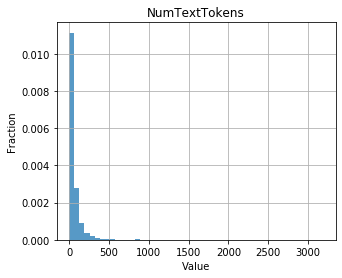

<Figure size 576x432 with 0 Axes>

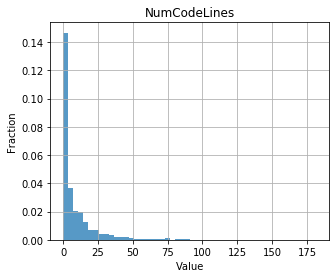

<Figure size 576x432 with 0 Axes>

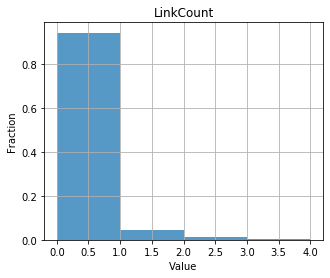

<Figure size 576x432 with 0 Axes>

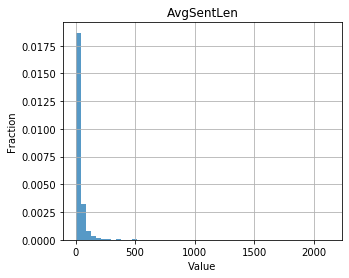

<Figure size 576x432 with 0 Axes>

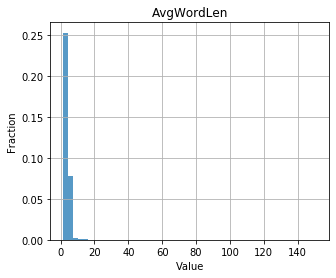

<Figure size 576x432 with 0 Axes>

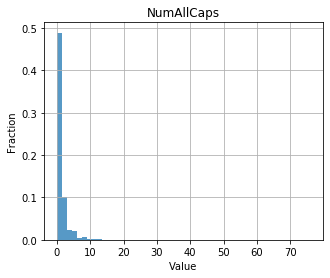

<Figure size 576x432 with 0 Axes>

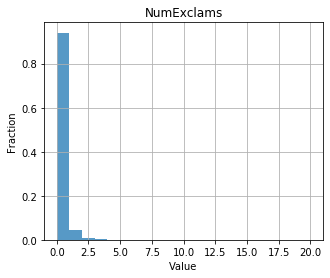

<Figure size 576x432 with 0 Axes>

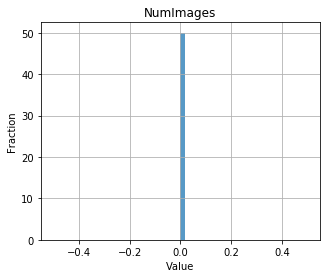

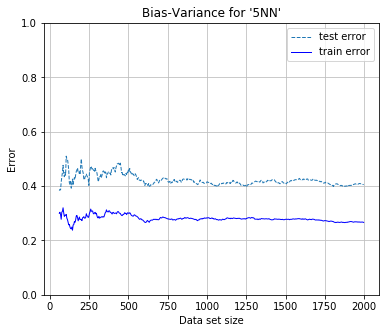

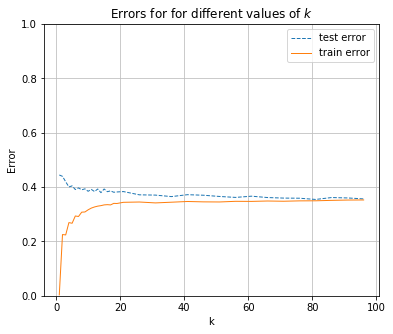

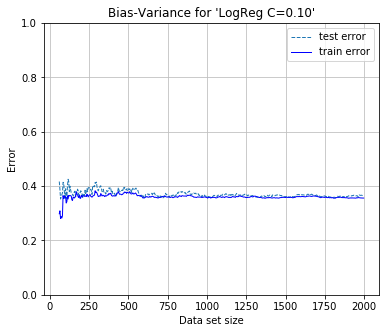

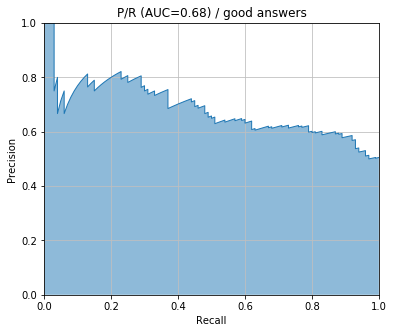

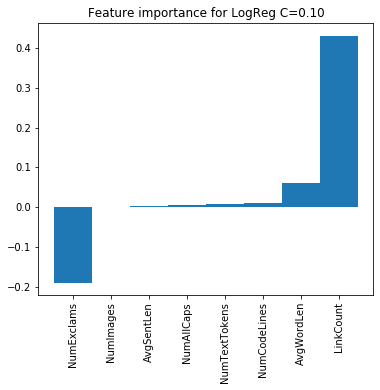

In [35]:
# classify.py
import time
start_time = time.time()

import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn import neighbors

# question Id -> {'features'->feature vector, 'answers'->[answer Ids]}, 'scores'->[scores]}
# scores will be added on-the-fly as the are not in meta
meta, id_to_idx, idx_to_id = load_meta(chosen_meta)

import nltk

# The sorting below is only to ensure reproducable numbers. Further down
# we will occasionally skip a fold when it contains instances of only
# one label. The two lines below ensure that the behavior is exactly the
# same for different runs.
all_questions = sorted([q for q, v in meta.items() if v['ParentId'] == -1])
all_answers = sorted([q for q, v in meta.items() if v['ParentId'] != -1])

feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))


def prepare_sent_features():
    for pid, text in fetch_posts(chosen, with_index=True):
        if not text:
            meta[pid]['AvgSentLen'] = meta[pid]['AvgWordLen'] = 0
        else:
            from platform import python_version
            if python_version().startswith('2'):
                text = text.decode('utf-8')
            sent_lens = [len(nltk.word_tokenize(
                sent)) for sent in nltk.sent_tokenize(text)]
            meta[pid]['AvgSentLen'] = np.mean(sent_lens)
            meta[pid]['AvgWordLen'] = np.mean(
                [len(w) for w in nltk.word_tokenize(text)])

        meta[pid]['NumAllCaps'] = np.sum(
            [word.isupper() for word in nltk.word_tokenize(text)])

        meta[pid]['NumExclams'] = text.count('!')


prepare_sent_features()


def get_features(aid):
    return tuple(meta[aid][fn] for fn in feature_names)

qa_X = np.asarray([get_features(aid) for aid in all_answers])

classifying_answer = "good"
#classifying_answer = "poor"

if classifying_answer == "good":
    # Score > 0 tests => positive class is good answer
    qa_Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
elif classifying_answer == "poor":
    # Score <= 0 tests => positive class is poor answer
    qa_Y = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])
else:
    raise Exception("classifying_answer='%s' is not supported" %
                    classifying_answer)

for idx, feat in enumerate(feature_names):
    plot_feat_hist([(qa_X[:, idx], feat)])

#plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [1,0]], 'feat_hist_two.png')
#plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [3,4,5,6]], 'feat_hist_four.png')

avg_scores_summary = []


def measure(clf_class, parameters, name, data_size=None, plot=False):
    start_time_clf = time.time()
    if data_size is None:
        X = qa_X
        Y = qa_Y
    else:
        X = qa_X[:data_size]
        Y = qa_Y[:data_size]

    cv = KFold(n_splits = 10)

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []
    i = 0
    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for train, test in cv.split(X):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(
            y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter 5,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        print("Clone #%i" % i)
        i += 1
        print(classification_report(y_test, proba[:, label_idx] >
              threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], classifying_answer + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)

    summary = (name,
               np.mean(scores), np.std(scores),
               np.mean(roc_scores), np.std(roc_scores),
               np.mean(pr_scores), np.std(pr_scores),
               time.time() - start_time_clf)
    print(summary)
    avg_scores_summary.append(summary)
    precisions = precisions[medium]
    recalls = recalls[medium]
    thresholds = np.hstack(([0], thresholds[medium]))
    idx80 = precisions >= 0.8
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[idx80][0], recalls[
          idx80][0], thresholds[idx80][0]))

    return np.mean(train_errors), np.mean(test_errors)


def bias_variance_analysis(clf_class, parameters, name):
    #import ipdb;ipdb.set_trace()
    data_sizes = np.arange(60, 2000, 4)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error = measure(
            clf_class, parameters, name, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)


def k_complexity_analysis(clf_class, parameters):
    ks = np.hstack((np.arange(1, 20), np.arange(21, 100, 5)))

    train_errors = []
    test_errors = []

    for k in ks:
        parameters['n_neighbors'] = k
        train_error, test_error = measure(
            clf_class, parameters, "%dNN" % k, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)

for k in [5]:
# for k in [5, 10, 40]:
    #measure(neighbors.KNeighborsClassifier, {'n_neighbors': k}, "%iNN" % k)
    bias_variance_analysis(neighbors.KNeighborsClassifier, {
                           'n_neighbors': k}, "%iNN" % k)
    k_complexity_analysis(neighbors.KNeighborsClassifier, {'n_neighbors': k})

from sklearn.linear_model import LogisticRegression
for C in [0.1]:
# for C in [0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    bias_variance_analysis(LogisticRegression, {'penalty': 'l2', 'C': C}, name)
    measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, plot=True)

print("=" * 50)
from operator import itemgetter
for s in reversed(sorted(avg_scores_summary, key=itemgetter(1))):
    print("%-20s\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % s)

print("time spent:", time.time() - start_time)

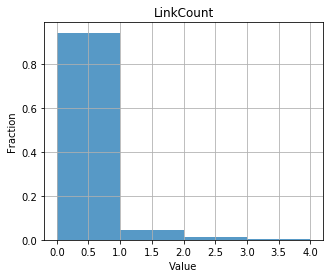

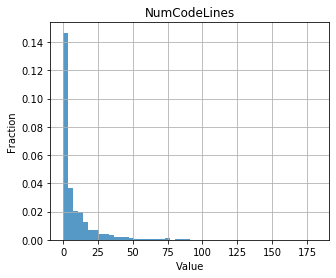

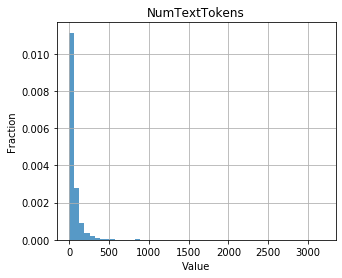

In [44]:
from IPython.display import Image, display
a = Image(filename='D:/feat_hist_LinkCount.png')
b = Image(filename='D:/feat_hist_NumCodeLines.png')
c = Image(filename='D:/feat_hist_NumTextTokens.png')
display(a, b, c)

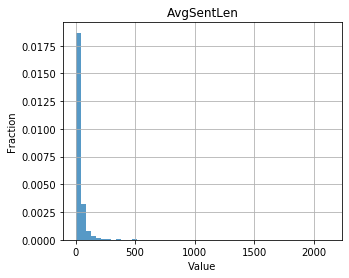

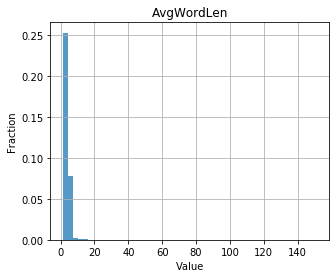

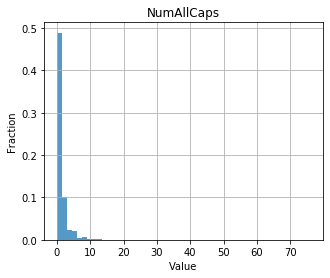

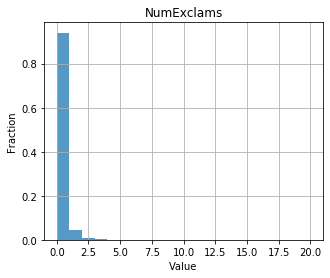

In [45]:
a = Image(filename='D:/feat_hist_AvgSentLen.png')
b = Image(filename='D:/feat_hist_AvgWordLen.png')
c = Image(filename='D:/feat_hist_NumAllCaps.png')
d = Image(filename='D:/feat_hist_NumExclams.png')
display(a, b, c, d)

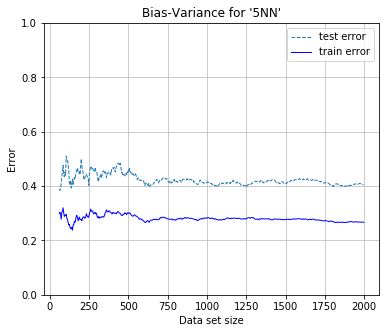

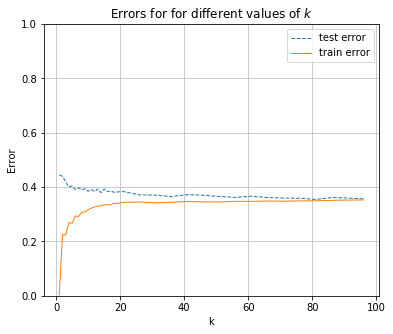

In [46]:
# High bias or low bias

a = Image(filename='D:/bv_5NN.png')
b = Image(filename='D:/kcomplexity.png')
display(a, b)

## <u>Using logistic regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[0.09437188] [1.80094112]
P(x=-1)=0.05	P(x=7)=0.85
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log


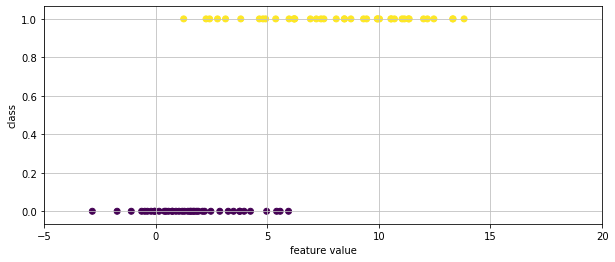

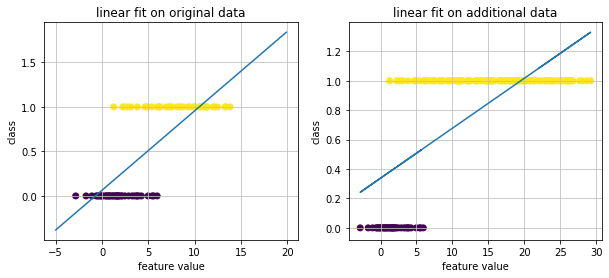

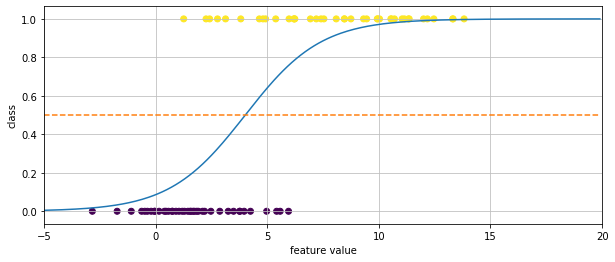

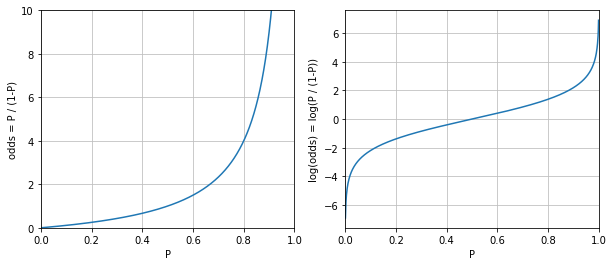

In [37]:
# log_reg_example.py
import os

import numpy as np
from scipy.stats import norm

from matplotlib import pyplot
np.random.seed(3)

num_per_class = 40
X = np.hstack((norm.rvs(2, size=num_per_class, scale=2),
              norm.rvs(8, size=num_per_class, scale=3)))
y = np.hstack((np.zeros(num_per_class),
               np.ones(num_per_class)))


def lr_model(clf, X):
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

from sklearn.linear_model import LogisticRegression
logclf = LogisticRegression()
print(logclf)
logclf.fit(X.reshape(num_per_class * 2, 1), y)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %
      (lr_model(logclf, -1), lr_model(logclf, 7)))
X_test = np.arange(-5, 20, 0.1)
pyplot.figure(figsize=(10, 4))
pyplot.xlim((-5, 20))
pyplot.scatter(X, y, c=y)
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_example_data.png"), bbox_inches="tight")


def lin_model(clf, X):
    return clf.intercept_ + clf.coef_ * X

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
print(clf)
clf.fit(X.reshape(num_per_class * 2, 1), y)
X_odds = np.arange(0, 1, 0.001)
pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.scatter(X, y, c=y)
pyplot.plot(X_test, lin_model(clf, X_test))
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.title("linear fit on original data")
pyplot.grid(True, linestyle='-', color='0.75')

X_ext = np.hstack((X, norm.rvs(20, size=100, scale=5)))
y_ext = np.hstack((y, np.ones(100)))
clf = LinearRegression()
clf.fit(X_ext.reshape(num_per_class * 2 + 100, 1), y_ext)
pyplot.subplot(1, 2, 2)
pyplot.scatter(X_ext, y_ext, c=y_ext)
pyplot.plot(X_ext, lin_model(clf, X_ext))
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.title("linear fit on additional data")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_log_linear_fit.png"), bbox_inches="tight")

pyplot.figure(figsize=(10, 4))
pyplot.xlim((-5, 20))
pyplot.scatter(X, y, c=y)
pyplot.plot(X_test, lr_model(logclf, X_test).ravel())
pyplot.plot(X_test, np.ones(X_test.shape[0]) * 0.5, "--")
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_example_fitted.png"), bbox_inches="tight")

X = np.arange(0, 1, 0.001)
pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.xlim((0, 1))
pyplot.ylim((0, 10))
pyplot.plot(X, X / (1 - X))
pyplot.xlabel("P")
pyplot.ylabel("odds = P / (1-P)")
pyplot.grid(True, linestyle='-', color='0.75')

pyplot.subplot(1, 2, 2)
pyplot.xlim((0, 1))
pyplot.plot(X, np.log(X / (1 - X)))
pyplot.xlabel("P")
pyplot.ylabel("log(odds) = log(P / (1-P))")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_log_odds.png"), bbox_inches="tight")

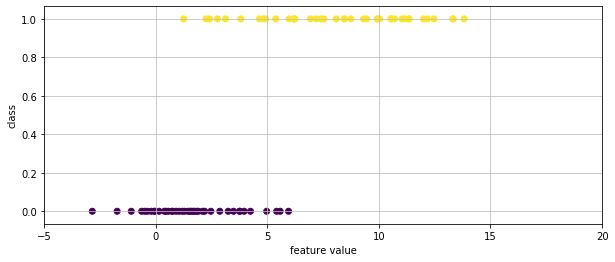

In [47]:
# Small example
Image(filename='D:/log_reg_example_data.png')

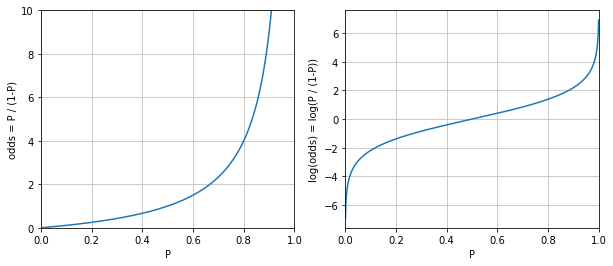

In [49]:
# The odds ratio is bounded by 0, but goes to infinity (left graph)
# map all probabilities between 0 and 1 to the full range from negative to positive infinity by taking logarithm (right graph)

Image(filename = 'D:/log_reg_log_odds.png')

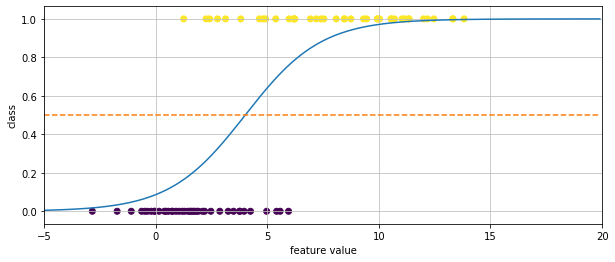

In [51]:
# Fitted logistic regression model for inital example

Image(filename = 'D:/log_reg_example_fitted.png')

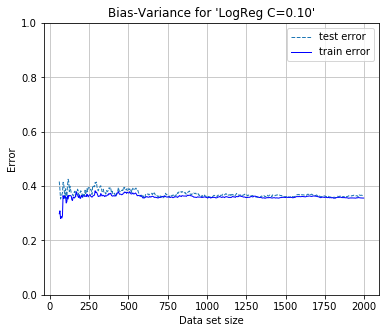

In [52]:
# Bias-Variance chart for best candidate of Original Problem (Logistic Regression C = 0.10)

Image(filename = 'D:/bv_LogReg_C=0.10.png')

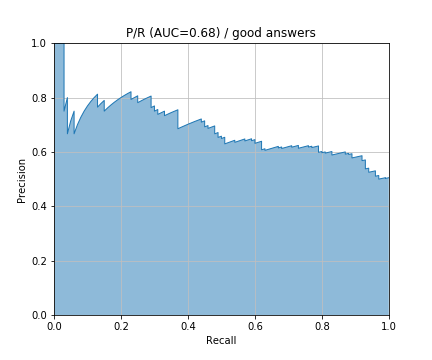

In [53]:
# Area Under Curve (AUC) for classifying good answers

Image(filename = 'D:/pr_LogReg_C=0.10.png')

In [57]:
# Ship it
# serialize the classifier after training and then seserialize on site

import pickle

pickle.dump(clf, open("D:/logreg.dat", 'wb')) #Serialize
clf = pickle.load(open("D:/logreg.dat", 'rb')) #Deserialize